In [0]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

import sys

import numpy as np

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator, 做分辨真假用
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator, 做假圖用
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator, 
            # ---------------------
            # noise 是隨機生成噪音, 讓 Generator 生成的結果讓 Discriminator 辨認是 real(1)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
#         fig.savefig("images/%d.png" % epoch)
        plt.show()

11410 [D loss: 0.662422, acc.: 64.06%] [G loss: 0.892152]
11411 [D loss: 0.644826, acc.: 64.06%] [G loss: 0.899824]
11412 [D loss: 0.682451, acc.: 53.91%] [G loss: 0.866374]
11413 [D loss: 0.686616, acc.: 50.78%] [G loss: 0.836944]
11414 [D loss: 0.687251, acc.: 59.38%] [G loss: 0.882355]
11415 [D loss: 0.685041, acc.: 59.38%] [G loss: 0.875208]
11416 [D loss: 0.623508, acc.: 67.97%] [G loss: 0.847593]
11417 [D loss: 0.628820, acc.: 67.19%] [G loss: 0.848722]
11418 [D loss: 0.657023, acc.: 59.38%] [G loss: 0.859486]
11419 [D loss: 0.616646, acc.: 64.06%] [G loss: 0.898840]
11420 [D loss: 0.648424, acc.: 62.50%] [G loss: 0.922855]
11421 [D loss: 0.705729, acc.: 52.34%] [G loss: 0.920095]
11422 [D loss: 0.720697, acc.: 50.78%] [G loss: 0.882655]
11423 [D loss: 0.685588, acc.: 52.34%] [G loss: 0.892278]
11424 [D loss: 0.623782, acc.: 64.84%] [G loss: 0.926906]
11425 [D loss: 0.626424, acc.: 66.41%] [G loss: 0.913146]
11426 [D loss: 0.671567, acc.: 60.16%] [G loss: 0.903539]
11427 [D loss:

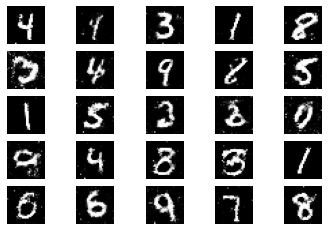

11501 [D loss: 0.643345, acc.: 62.50%] [G loss: 0.908060]
11502 [D loss: 0.652908, acc.: 61.72%] [G loss: 0.853110]
11503 [D loss: 0.663262, acc.: 59.38%] [G loss: 0.878020]
11504 [D loss: 0.683489, acc.: 59.38%] [G loss: 0.973516]
11505 [D loss: 0.629900, acc.: 67.97%] [G loss: 0.924945]
11506 [D loss: 0.690643, acc.: 56.25%] [G loss: 0.937423]
11507 [D loss: 0.617502, acc.: 70.31%] [G loss: 0.894258]
11508 [D loss: 0.712816, acc.: 52.34%] [G loss: 0.880398]
11509 [D loss: 0.634749, acc.: 69.53%] [G loss: 0.826258]
11510 [D loss: 0.669311, acc.: 60.16%] [G loss: 0.885831]
11511 [D loss: 0.731552, acc.: 58.59%] [G loss: 0.885717]
11512 [D loss: 0.699156, acc.: 56.25%] [G loss: 0.872560]
11513 [D loss: 0.704765, acc.: 50.78%] [G loss: 0.863376]
11514 [D loss: 0.701564, acc.: 53.12%] [G loss: 0.866277]
11515 [D loss: 0.673859, acc.: 60.16%] [G loss: 0.912042]
11516 [D loss: 0.666495, acc.: 53.12%] [G loss: 0.939680]
11517 [D loss: 0.644372, acc.: 69.53%] [G loss: 0.864628]
11518 [D loss:

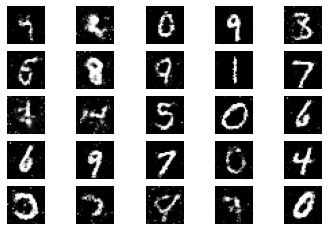

11601 [D loss: 0.681726, acc.: 57.03%] [G loss: 0.890229]
11602 [D loss: 0.631371, acc.: 63.28%] [G loss: 0.904690]
11603 [D loss: 0.636093, acc.: 65.62%] [G loss: 0.865566]
11604 [D loss: 0.657688, acc.: 64.06%] [G loss: 0.885956]
11605 [D loss: 0.632214, acc.: 65.62%] [G loss: 0.913447]
11606 [D loss: 0.671320, acc.: 58.59%] [G loss: 0.992292]
11607 [D loss: 0.705823, acc.: 54.69%] [G loss: 0.872990]
11608 [D loss: 0.681842, acc.: 58.59%] [G loss: 0.916535]
11609 [D loss: 0.625379, acc.: 60.94%] [G loss: 0.872467]
11610 [D loss: 0.701616, acc.: 50.78%] [G loss: 0.912396]
11611 [D loss: 0.640963, acc.: 67.97%] [G loss: 0.901730]
11612 [D loss: 0.659736, acc.: 58.59%] [G loss: 0.894616]
11613 [D loss: 0.658435, acc.: 63.28%] [G loss: 0.946708]
11614 [D loss: 0.660547, acc.: 60.16%] [G loss: 0.943216]
11615 [D loss: 0.680539, acc.: 57.03%] [G loss: 0.895371]
11616 [D loss: 0.668479, acc.: 60.94%] [G loss: 0.850080]
11617 [D loss: 0.703887, acc.: 55.47%] [G loss: 0.929829]
11618 [D loss:

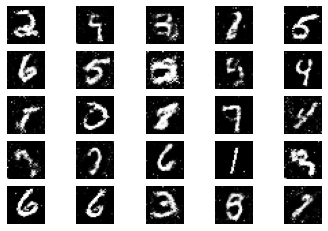

11701 [D loss: 0.651985, acc.: 58.59%] [G loss: 0.837475]
11702 [D loss: 0.621723, acc.: 67.97%] [G loss: 0.934935]
11703 [D loss: 0.673314, acc.: 60.94%] [G loss: 0.859677]
11704 [D loss: 0.680167, acc.: 57.81%] [G loss: 0.952845]
11705 [D loss: 0.679149, acc.: 53.91%] [G loss: 0.893314]
11706 [D loss: 0.676594, acc.: 56.25%] [G loss: 0.929671]
11707 [D loss: 0.672572, acc.: 55.47%] [G loss: 0.911285]
11708 [D loss: 0.678250, acc.: 55.47%] [G loss: 0.897288]
11709 [D loss: 0.676298, acc.: 55.47%] [G loss: 0.835094]
11710 [D loss: 0.615200, acc.: 64.84%] [G loss: 0.969312]
11711 [D loss: 0.654923, acc.: 60.94%] [G loss: 0.890035]
11712 [D loss: 0.695415, acc.: 51.56%] [G loss: 0.876343]
11713 [D loss: 0.661156, acc.: 56.25%] [G loss: 0.931614]
11714 [D loss: 0.637050, acc.: 59.38%] [G loss: 0.951128]
11715 [D loss: 0.646861, acc.: 57.81%] [G loss: 0.837716]
11716 [D loss: 0.628197, acc.: 63.28%] [G loss: 0.912713]
11717 [D loss: 0.657093, acc.: 60.94%] [G loss: 0.879864]
11718 [D loss:

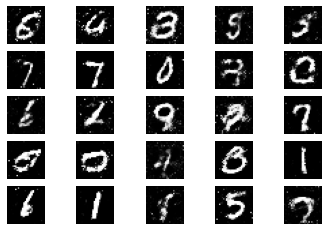

11801 [D loss: 0.663589, acc.: 57.81%] [G loss: 0.892504]
11802 [D loss: 0.648667, acc.: 62.50%] [G loss: 0.909058]
11803 [D loss: 0.618867, acc.: 69.53%] [G loss: 0.936444]
11804 [D loss: 0.645326, acc.: 62.50%] [G loss: 0.891941]
11805 [D loss: 0.647074, acc.: 63.28%] [G loss: 0.885800]
11806 [D loss: 0.660724, acc.: 57.81%] [G loss: 0.844337]
11807 [D loss: 0.651073, acc.: 60.16%] [G loss: 0.898115]
11808 [D loss: 0.656395, acc.: 57.03%] [G loss: 0.909546]
11809 [D loss: 0.676234, acc.: 57.81%] [G loss: 0.935431]
11810 [D loss: 0.723647, acc.: 53.12%] [G loss: 0.939936]
11811 [D loss: 0.657315, acc.: 59.38%] [G loss: 0.887438]
11812 [D loss: 0.661202, acc.: 57.03%] [G loss: 0.928931]
11813 [D loss: 0.682179, acc.: 58.59%] [G loss: 0.907867]
11814 [D loss: 0.658160, acc.: 60.16%] [G loss: 0.874578]
11815 [D loss: 0.661177, acc.: 64.06%] [G loss: 0.850288]
11816 [D loss: 0.704455, acc.: 52.34%] [G loss: 0.845110]
11817 [D loss: 0.642046, acc.: 66.41%] [G loss: 0.845436]
11818 [D loss:

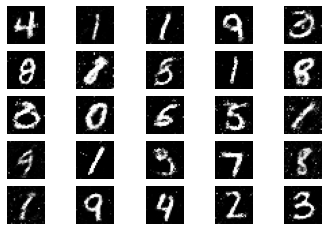

11901 [D loss: 0.654236, acc.: 63.28%] [G loss: 0.888875]
11902 [D loss: 0.652366, acc.: 61.72%] [G loss: 0.858398]
11903 [D loss: 0.649287, acc.: 63.28%] [G loss: 0.869531]
11904 [D loss: 0.616737, acc.: 67.19%] [G loss: 0.912309]
11905 [D loss: 0.700978, acc.: 59.38%] [G loss: 0.858216]
11906 [D loss: 0.594846, acc.: 67.97%] [G loss: 0.901636]
11907 [D loss: 0.700771, acc.: 57.03%] [G loss: 0.957336]
11908 [D loss: 0.715837, acc.: 50.00%] [G loss: 0.890983]
11909 [D loss: 0.730712, acc.: 46.88%] [G loss: 0.906069]
11910 [D loss: 0.652281, acc.: 69.53%] [G loss: 0.948394]
11911 [D loss: 0.662182, acc.: 56.25%] [G loss: 0.906988]
11912 [D loss: 0.643442, acc.: 63.28%] [G loss: 0.816502]
11913 [D loss: 0.625451, acc.: 66.41%] [G loss: 0.925458]
11914 [D loss: 0.618380, acc.: 65.62%] [G loss: 0.885839]
11915 [D loss: 0.690084, acc.: 56.25%] [G loss: 0.878473]
11916 [D loss: 0.647943, acc.: 67.19%] [G loss: 0.862517]
11917 [D loss: 0.654064, acc.: 61.72%] [G loss: 0.903190]
11918 [D loss:

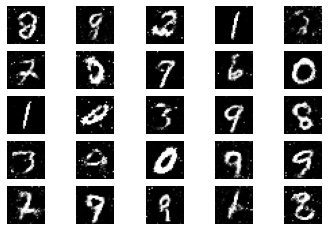

12001 [D loss: 0.666594, acc.: 60.16%] [G loss: 0.851905]
12002 [D loss: 0.626704, acc.: 67.19%] [G loss: 0.896740]
12003 [D loss: 0.684057, acc.: 54.69%] [G loss: 0.913919]
12004 [D loss: 0.680012, acc.: 54.69%] [G loss: 0.870129]
12005 [D loss: 0.685197, acc.: 57.81%] [G loss: 0.914136]
12006 [D loss: 0.685138, acc.: 57.03%] [G loss: 0.922441]
12007 [D loss: 0.713957, acc.: 55.47%] [G loss: 0.903414]
12008 [D loss: 0.663970, acc.: 60.94%] [G loss: 0.956969]
12009 [D loss: 0.647166, acc.: 64.84%] [G loss: 0.931617]
12010 [D loss: 0.625851, acc.: 68.75%] [G loss: 0.964682]
12011 [D loss: 0.665897, acc.: 60.16%] [G loss: 0.919871]
12012 [D loss: 0.674004, acc.: 57.03%] [G loss: 0.918428]
12013 [D loss: 0.701354, acc.: 51.56%] [G loss: 0.915888]
12014 [D loss: 0.643331, acc.: 64.06%] [G loss: 0.948306]
12015 [D loss: 0.646012, acc.: 64.84%] [G loss: 0.922112]
12016 [D loss: 0.672658, acc.: 57.03%] [G loss: 0.947905]
12017 [D loss: 0.634358, acc.: 63.28%] [G loss: 0.914311]
12018 [D loss:

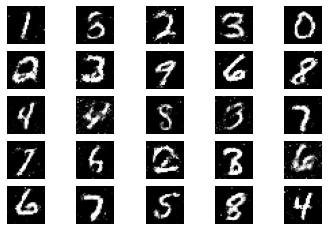

12101 [D loss: 0.670761, acc.: 58.59%] [G loss: 0.881907]
12102 [D loss: 0.664585, acc.: 60.94%] [G loss: 0.920030]
12103 [D loss: 0.622578, acc.: 73.44%] [G loss: 0.968086]
12104 [D loss: 0.644602, acc.: 60.94%] [G loss: 0.919158]
12105 [D loss: 0.649007, acc.: 67.19%] [G loss: 0.885521]
12106 [D loss: 0.621720, acc.: 63.28%] [G loss: 0.925509]
12107 [D loss: 0.663016, acc.: 60.16%] [G loss: 0.909269]
12108 [D loss: 0.620705, acc.: 61.72%] [G loss: 0.835227]
12109 [D loss: 0.684932, acc.: 57.81%] [G loss: 0.900086]
12110 [D loss: 0.672958, acc.: 60.16%] [G loss: 0.961832]
12111 [D loss: 0.651113, acc.: 59.38%] [G loss: 0.952136]
12112 [D loss: 0.689840, acc.: 57.03%] [G loss: 0.958874]
12113 [D loss: 0.705878, acc.: 54.69%] [G loss: 0.944851]
12114 [D loss: 0.681670, acc.: 55.47%] [G loss: 0.938493]
12115 [D loss: 0.633929, acc.: 64.06%] [G loss: 0.917400]
12116 [D loss: 0.652352, acc.: 57.81%] [G loss: 0.828234]
12117 [D loss: 0.685770, acc.: 60.94%] [G loss: 0.824722]
12118 [D loss:

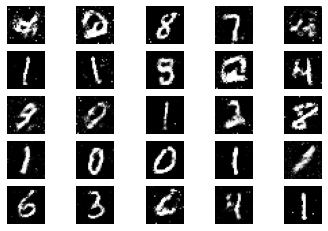

12201 [D loss: 0.638931, acc.: 60.16%] [G loss: 0.847475]
12202 [D loss: 0.683599, acc.: 58.59%] [G loss: 0.844075]
12203 [D loss: 0.634680, acc.: 64.06%] [G loss: 0.895455]
12204 [D loss: 0.636717, acc.: 61.72%] [G loss: 0.885544]
12205 [D loss: 0.661332, acc.: 61.72%] [G loss: 0.920039]
12206 [D loss: 0.667363, acc.: 60.94%] [G loss: 0.880695]
12207 [D loss: 0.657622, acc.: 62.50%] [G loss: 0.903735]
12208 [D loss: 0.703129, acc.: 52.34%] [G loss: 0.870017]
12209 [D loss: 0.639534, acc.: 65.62%] [G loss: 0.883953]
12210 [D loss: 0.654527, acc.: 60.94%] [G loss: 0.899187]
12211 [D loss: 0.664031, acc.: 62.50%] [G loss: 0.947561]
12212 [D loss: 0.647133, acc.: 58.59%] [G loss: 0.847414]
12213 [D loss: 0.651597, acc.: 60.94%] [G loss: 0.906642]
12214 [D loss: 0.619387, acc.: 69.53%] [G loss: 0.866671]
12215 [D loss: 0.666974, acc.: 60.94%] [G loss: 0.962459]
12216 [D loss: 0.652766, acc.: 64.06%] [G loss: 0.904571]
12217 [D loss: 0.647692, acc.: 63.28%] [G loss: 0.901995]
12218 [D loss:

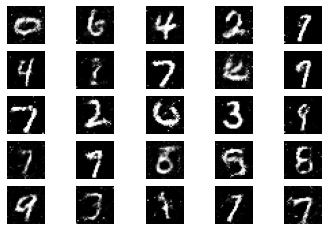

12301 [D loss: 0.686934, acc.: 55.47%] [G loss: 0.866212]
12302 [D loss: 0.647389, acc.: 58.59%] [G loss: 0.884747]
12303 [D loss: 0.654726, acc.: 59.38%] [G loss: 0.896812]
12304 [D loss: 0.680486, acc.: 61.72%] [G loss: 0.856633]
12305 [D loss: 0.659308, acc.: 58.59%] [G loss: 0.815980]
12306 [D loss: 0.674604, acc.: 61.72%] [G loss: 0.886902]
12307 [D loss: 0.667548, acc.: 64.06%] [G loss: 0.905524]
12308 [D loss: 0.642360, acc.: 62.50%] [G loss: 0.891177]
12309 [D loss: 0.682178, acc.: 58.59%] [G loss: 0.897474]
12310 [D loss: 0.694797, acc.: 52.34%] [G loss: 0.914737]
12311 [D loss: 0.638496, acc.: 60.16%] [G loss: 0.919033]
12312 [D loss: 0.682113, acc.: 60.16%] [G loss: 0.953035]
12313 [D loss: 0.648614, acc.: 59.38%] [G loss: 0.888028]
12314 [D loss: 0.650860, acc.: 64.06%] [G loss: 0.871466]
12315 [D loss: 0.640210, acc.: 63.28%] [G loss: 0.894469]
12316 [D loss: 0.636296, acc.: 59.38%] [G loss: 0.876754]
12317 [D loss: 0.679406, acc.: 50.78%] [G loss: 0.850533]
12318 [D loss:

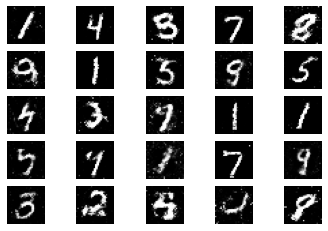

12401 [D loss: 0.667082, acc.: 56.25%] [G loss: 0.878358]
12402 [D loss: 0.703478, acc.: 53.91%] [G loss: 0.896588]
12403 [D loss: 0.665200, acc.: 57.03%] [G loss: 0.924322]
12404 [D loss: 0.649103, acc.: 60.94%] [G loss: 0.846967]
12405 [D loss: 0.666240, acc.: 59.38%] [G loss: 0.887418]
12406 [D loss: 0.656959, acc.: 59.38%] [G loss: 0.897313]
12407 [D loss: 0.645144, acc.: 60.16%] [G loss: 0.911272]
12408 [D loss: 0.645777, acc.: 64.06%] [G loss: 0.883146]
12409 [D loss: 0.662903, acc.: 59.38%] [G loss: 0.798892]
12410 [D loss: 0.675744, acc.: 58.59%] [G loss: 0.856685]
12411 [D loss: 0.665108, acc.: 59.38%] [G loss: 0.808870]
12412 [D loss: 0.650206, acc.: 63.28%] [G loss: 0.935200]
12413 [D loss: 0.669679, acc.: 59.38%] [G loss: 0.855316]
12414 [D loss: 0.637768, acc.: 67.97%] [G loss: 0.866309]
12415 [D loss: 0.672038, acc.: 55.47%] [G loss: 0.845288]
12416 [D loss: 0.631035, acc.: 65.62%] [G loss: 0.947799]
12417 [D loss: 0.627697, acc.: 64.84%] [G loss: 0.924833]
12418 [D loss:

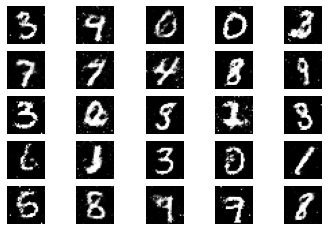

12501 [D loss: 0.628641, acc.: 62.50%] [G loss: 0.967429]
12502 [D loss: 0.661690, acc.: 59.38%] [G loss: 0.925994]
12503 [D loss: 0.627874, acc.: 62.50%] [G loss: 0.981232]
12504 [D loss: 0.688391, acc.: 58.59%] [G loss: 0.851886]
12505 [D loss: 0.646976, acc.: 66.41%] [G loss: 0.856296]
12506 [D loss: 0.645434, acc.: 59.38%] [G loss: 0.856227]
12507 [D loss: 0.607159, acc.: 66.41%] [G loss: 0.853668]
12508 [D loss: 0.669120, acc.: 58.59%] [G loss: 0.873462]
12509 [D loss: 0.633098, acc.: 60.94%] [G loss: 0.936680]
12510 [D loss: 0.711229, acc.: 51.56%] [G loss: 0.891927]
12511 [D loss: 0.642437, acc.: 64.06%] [G loss: 0.943544]
12512 [D loss: 0.663661, acc.: 60.16%] [G loss: 0.853755]
12513 [D loss: 0.624811, acc.: 61.72%] [G loss: 0.881802]
12514 [D loss: 0.721419, acc.: 49.22%] [G loss: 0.950338]
12515 [D loss: 0.668839, acc.: 60.16%] [G loss: 0.919834]
12516 [D loss: 0.651137, acc.: 60.94%] [G loss: 0.885683]
12517 [D loss: 0.614029, acc.: 66.41%] [G loss: 0.844522]
12518 [D loss:

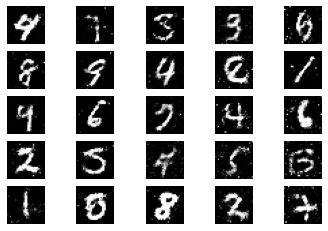

12601 [D loss: 0.656857, acc.: 57.03%] [G loss: 0.927095]
12602 [D loss: 0.688129, acc.: 62.50%] [G loss: 0.905684]
12603 [D loss: 0.713431, acc.: 50.78%] [G loss: 0.883471]
12604 [D loss: 0.638944, acc.: 63.28%] [G loss: 0.905670]
12605 [D loss: 0.667172, acc.: 57.81%] [G loss: 0.857478]
12606 [D loss: 0.659092, acc.: 60.16%] [G loss: 0.897391]
12607 [D loss: 0.632136, acc.: 64.06%] [G loss: 0.902075]
12608 [D loss: 0.670976, acc.: 57.81%] [G loss: 0.873868]
12609 [D loss: 0.640893, acc.: 63.28%] [G loss: 0.854204]
12610 [D loss: 0.648177, acc.: 61.72%] [G loss: 0.837170]
12611 [D loss: 0.631666, acc.: 60.94%] [G loss: 0.890254]
12612 [D loss: 0.706388, acc.: 49.22%] [G loss: 0.897481]
12613 [D loss: 0.658085, acc.: 65.62%] [G loss: 0.938110]
12614 [D loss: 0.650900, acc.: 63.28%] [G loss: 0.841098]
12615 [D loss: 0.660166, acc.: 60.94%] [G loss: 0.854653]
12616 [D loss: 0.671032, acc.: 60.94%] [G loss: 0.946848]
12617 [D loss: 0.665584, acc.: 62.50%] [G loss: 0.918706]
12618 [D loss:

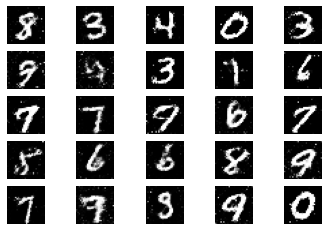

12701 [D loss: 0.636425, acc.: 64.84%] [G loss: 0.903147]
12702 [D loss: 0.684293, acc.: 59.38%] [G loss: 0.943230]
12703 [D loss: 0.673179, acc.: 56.25%] [G loss: 0.941437]
12704 [D loss: 0.629081, acc.: 67.19%] [G loss: 0.877887]
12705 [D loss: 0.612514, acc.: 67.97%] [G loss: 0.932669]
12706 [D loss: 0.671801, acc.: 59.38%] [G loss: 0.873035]
12707 [D loss: 0.675426, acc.: 63.28%] [G loss: 0.847473]
12708 [D loss: 0.633393, acc.: 64.06%] [G loss: 0.867622]
12709 [D loss: 0.662315, acc.: 59.38%] [G loss: 0.874023]
12710 [D loss: 0.649127, acc.: 56.25%] [G loss: 0.914403]
12711 [D loss: 0.673138, acc.: 60.16%] [G loss: 0.907359]
12712 [D loss: 0.683457, acc.: 57.81%] [G loss: 0.867957]
12713 [D loss: 0.706213, acc.: 53.12%] [G loss: 0.863174]
12714 [D loss: 0.681719, acc.: 54.69%] [G loss: 0.913148]
12715 [D loss: 0.676737, acc.: 56.25%] [G loss: 0.954326]
12716 [D loss: 0.654444, acc.: 62.50%] [G loss: 0.905679]
12717 [D loss: 0.637552, acc.: 67.97%] [G loss: 0.902131]
12718 [D loss:

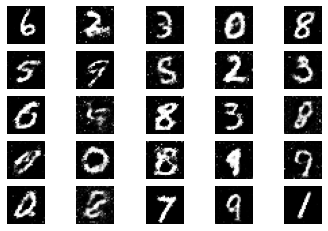

12801 [D loss: 0.639850, acc.: 64.06%] [G loss: 0.841664]
12802 [D loss: 0.646407, acc.: 60.16%] [G loss: 0.862041]
12803 [D loss: 0.656154, acc.: 60.16%] [G loss: 0.863912]
12804 [D loss: 0.691563, acc.: 49.22%] [G loss: 0.856771]
12805 [D loss: 0.645097, acc.: 57.81%] [G loss: 0.955328]
12806 [D loss: 0.672933, acc.: 59.38%] [G loss: 0.908488]
12807 [D loss: 0.687510, acc.: 63.28%] [G loss: 0.913386]
12808 [D loss: 0.646781, acc.: 60.16%] [G loss: 0.945327]
12809 [D loss: 0.640951, acc.: 68.75%] [G loss: 0.890000]
12810 [D loss: 0.686839, acc.: 56.25%] [G loss: 0.848222]
12811 [D loss: 0.695664, acc.: 57.81%] [G loss: 0.951715]
12812 [D loss: 0.625262, acc.: 67.19%] [G loss: 0.935935]
12813 [D loss: 0.677336, acc.: 60.16%] [G loss: 0.861774]
12814 [D loss: 0.666030, acc.: 64.06%] [G loss: 0.882530]
12815 [D loss: 0.661639, acc.: 58.59%] [G loss: 0.973307]
12816 [D loss: 0.635932, acc.: 66.41%] [G loss: 1.014335]
12817 [D loss: 0.692492, acc.: 56.25%] [G loss: 0.853773]
12818 [D loss:

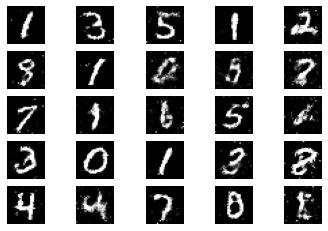

12901 [D loss: 0.659735, acc.: 58.59%] [G loss: 0.879616]
12902 [D loss: 0.657325, acc.: 66.41%] [G loss: 0.938020]
12903 [D loss: 0.647044, acc.: 60.94%] [G loss: 0.865925]
12904 [D loss: 0.733039, acc.: 48.44%] [G loss: 0.927919]
12905 [D loss: 0.633833, acc.: 62.50%] [G loss: 0.889212]
12906 [D loss: 0.661311, acc.: 57.81%] [G loss: 0.854292]
12907 [D loss: 0.645340, acc.: 62.50%] [G loss: 0.942798]
12908 [D loss: 0.642383, acc.: 66.41%] [G loss: 0.910936]
12909 [D loss: 0.660643, acc.: 57.81%] [G loss: 0.980468]
12910 [D loss: 0.636995, acc.: 61.72%] [G loss: 0.954785]
12911 [D loss: 0.661540, acc.: 55.47%] [G loss: 0.958380]
12912 [D loss: 0.627335, acc.: 63.28%] [G loss: 0.904480]
12913 [D loss: 0.652861, acc.: 56.25%] [G loss: 0.861149]
12914 [D loss: 0.632745, acc.: 62.50%] [G loss: 0.900821]
12915 [D loss: 0.666471, acc.: 57.81%] [G loss: 0.899739]
12916 [D loss: 0.649003, acc.: 60.16%] [G loss: 0.812805]
12917 [D loss: 0.653370, acc.: 59.38%] [G loss: 0.879999]
12918 [D loss:

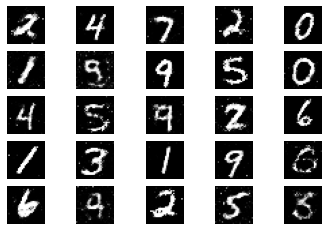

13001 [D loss: 0.688556, acc.: 53.91%] [G loss: 0.836965]
13002 [D loss: 0.649799, acc.: 65.62%] [G loss: 0.916916]
13003 [D loss: 0.637234, acc.: 61.72%] [G loss: 0.820585]
13004 [D loss: 0.683044, acc.: 57.03%] [G loss: 0.898564]
13005 [D loss: 0.660656, acc.: 58.59%] [G loss: 0.843951]
13006 [D loss: 0.663581, acc.: 58.59%] [G loss: 0.881015]
13007 [D loss: 0.646341, acc.: 66.41%] [G loss: 0.936422]
13008 [D loss: 0.672436, acc.: 56.25%] [G loss: 0.902987]
13009 [D loss: 0.652965, acc.: 60.94%] [G loss: 0.909443]
13010 [D loss: 0.650071, acc.: 60.94%] [G loss: 0.859277]
13011 [D loss: 0.674656, acc.: 53.12%] [G loss: 0.851717]
13012 [D loss: 0.669709, acc.: 60.94%] [G loss: 0.863566]
13013 [D loss: 0.630716, acc.: 66.41%] [G loss: 0.802416]
13014 [D loss: 0.654318, acc.: 62.50%] [G loss: 0.895459]
13015 [D loss: 0.660236, acc.: 58.59%] [G loss: 0.870166]
13016 [D loss: 0.639604, acc.: 64.06%] [G loss: 0.802414]
13017 [D loss: 0.674126, acc.: 53.91%] [G loss: 0.829542]
13018 [D loss:

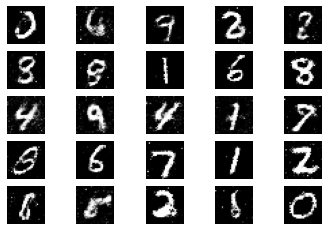

13101 [D loss: 0.627265, acc.: 62.50%] [G loss: 0.927611]
13102 [D loss: 0.650781, acc.: 64.84%] [G loss: 0.898056]
13103 [D loss: 0.616321, acc.: 68.75%] [G loss: 0.911521]
13104 [D loss: 0.635595, acc.: 64.84%] [G loss: 0.866245]
13105 [D loss: 0.629106, acc.: 64.84%] [G loss: 0.908955]
13106 [D loss: 0.683174, acc.: 57.81%] [G loss: 0.961691]
13107 [D loss: 0.664496, acc.: 57.03%] [G loss: 0.916259]
13108 [D loss: 0.641618, acc.: 61.72%] [G loss: 0.969731]
13109 [D loss: 0.652575, acc.: 59.38%] [G loss: 0.965577]
13110 [D loss: 0.620779, acc.: 63.28%] [G loss: 0.926694]
13111 [D loss: 0.713382, acc.: 51.56%] [G loss: 0.848827]
13112 [D loss: 0.630363, acc.: 62.50%] [G loss: 0.907131]
13113 [D loss: 0.620004, acc.: 64.06%] [G loss: 0.871708]
13114 [D loss: 0.703040, acc.: 50.78%] [G loss: 0.898239]
13115 [D loss: 0.638142, acc.: 63.28%] [G loss: 0.895472]
13116 [D loss: 0.649816, acc.: 63.28%] [G loss: 0.941365]
13117 [D loss: 0.633561, acc.: 64.06%] [G loss: 0.958852]
13118 [D loss:

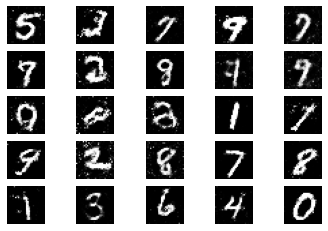

13201 [D loss: 0.677988, acc.: 54.69%] [G loss: 0.839058]
13202 [D loss: 0.649032, acc.: 62.50%] [G loss: 0.874223]
13203 [D loss: 0.662299, acc.: 58.59%] [G loss: 0.935689]
13204 [D loss: 0.697520, acc.: 51.56%] [G loss: 0.901435]
13205 [D loss: 0.651192, acc.: 64.06%] [G loss: 0.905880]
13206 [D loss: 0.681713, acc.: 62.50%] [G loss: 0.905851]
13207 [D loss: 0.684540, acc.: 55.47%] [G loss: 0.892848]
13208 [D loss: 0.641540, acc.: 61.72%] [G loss: 0.864982]
13209 [D loss: 0.661745, acc.: 53.91%] [G loss: 0.841476]
13210 [D loss: 0.638549, acc.: 67.19%] [G loss: 0.859661]
13211 [D loss: 0.682059, acc.: 60.94%] [G loss: 0.832880]
13212 [D loss: 0.627281, acc.: 67.19%] [G loss: 0.863908]
13213 [D loss: 0.660614, acc.: 60.94%] [G loss: 0.930445]
13214 [D loss: 0.671658, acc.: 56.25%] [G loss: 0.881876]
13215 [D loss: 0.643699, acc.: 64.06%] [G loss: 0.921894]
13216 [D loss: 0.638011, acc.: 62.50%] [G loss: 0.870447]
13217 [D loss: 0.664982, acc.: 57.81%] [G loss: 0.827040]
13218 [D loss:

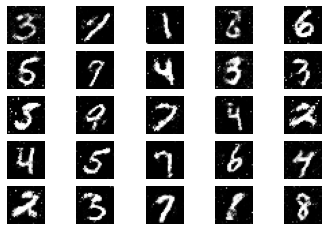

13301 [D loss: 0.652400, acc.: 64.84%] [G loss: 0.873501]
13302 [D loss: 0.674839, acc.: 53.12%] [G loss: 0.941932]
13303 [D loss: 0.662158, acc.: 54.69%] [G loss: 0.897555]
13304 [D loss: 0.687168, acc.: 54.69%] [G loss: 0.848214]
13305 [D loss: 0.671917, acc.: 56.25%] [G loss: 0.902658]
13306 [D loss: 0.669491, acc.: 52.34%] [G loss: 0.916651]
13307 [D loss: 0.639662, acc.: 64.06%] [G loss: 0.912327]
13308 [D loss: 0.687474, acc.: 54.69%] [G loss: 0.896578]
13309 [D loss: 0.683498, acc.: 53.91%] [G loss: 0.873588]
13310 [D loss: 0.641345, acc.: 63.28%] [G loss: 0.897512]
13311 [D loss: 0.632834, acc.: 62.50%] [G loss: 0.855644]
13312 [D loss: 0.622723, acc.: 64.84%] [G loss: 0.884767]
13313 [D loss: 0.660089, acc.: 62.50%] [G loss: 0.841254]
13314 [D loss: 0.672491, acc.: 59.38%] [G loss: 0.910035]
13315 [D loss: 0.634404, acc.: 63.28%] [G loss: 0.949499]
13316 [D loss: 0.666788, acc.: 58.59%] [G loss: 0.862162]
13317 [D loss: 0.620543, acc.: 71.09%] [G loss: 0.904280]
13318 [D loss:

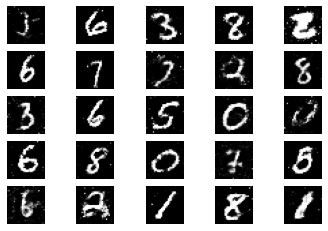

13401 [D loss: 0.697965, acc.: 54.69%] [G loss: 0.880637]
13402 [D loss: 0.684738, acc.: 55.47%] [G loss: 0.894591]
13403 [D loss: 0.694657, acc.: 53.12%] [G loss: 0.878514]
13404 [D loss: 0.700911, acc.: 52.34%] [G loss: 0.906721]
13405 [D loss: 0.643984, acc.: 60.94%] [G loss: 0.919215]
13406 [D loss: 0.645483, acc.: 61.72%] [G loss: 0.944622]
13407 [D loss: 0.642377, acc.: 64.06%] [G loss: 0.888608]
13408 [D loss: 0.637092, acc.: 65.62%] [G loss: 0.881855]
13409 [D loss: 0.648147, acc.: 62.50%] [G loss: 0.934433]
13410 [D loss: 0.662395, acc.: 58.59%] [G loss: 0.860430]
13411 [D loss: 0.654337, acc.: 67.97%] [G loss: 0.903678]
13412 [D loss: 0.667277, acc.: 58.59%] [G loss: 0.875469]
13413 [D loss: 0.697613, acc.: 56.25%] [G loss: 0.937638]
13414 [D loss: 0.638491, acc.: 67.97%] [G loss: 0.919158]
13415 [D loss: 0.671449, acc.: 59.38%] [G loss: 0.924101]
13416 [D loss: 0.658476, acc.: 57.03%] [G loss: 0.942807]
13417 [D loss: 0.638273, acc.: 62.50%] [G loss: 0.896755]
13418 [D loss:

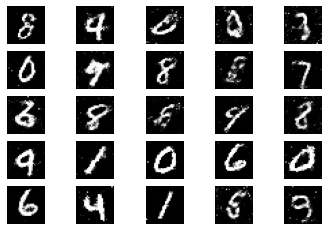

13501 [D loss: 0.663350, acc.: 57.03%] [G loss: 0.862017]
13502 [D loss: 0.618337, acc.: 67.19%] [G loss: 0.904862]
13503 [D loss: 0.646210, acc.: 58.59%] [G loss: 0.861719]
13504 [D loss: 0.674249, acc.: 55.47%] [G loss: 0.863221]
13505 [D loss: 0.654924, acc.: 57.03%] [G loss: 0.845825]
13506 [D loss: 0.635623, acc.: 64.06%] [G loss: 0.886572]
13507 [D loss: 0.653824, acc.: 58.59%] [G loss: 0.934488]
13508 [D loss: 0.650916, acc.: 60.94%] [G loss: 0.968442]
13509 [D loss: 0.664204, acc.: 59.38%] [G loss: 0.908081]
13510 [D loss: 0.664228, acc.: 63.28%] [G loss: 0.959110]
13511 [D loss: 0.648109, acc.: 61.72%] [G loss: 0.910123]
13512 [D loss: 0.684887, acc.: 56.25%] [G loss: 0.894110]
13513 [D loss: 0.619890, acc.: 65.62%] [G loss: 0.930808]
13514 [D loss: 0.613810, acc.: 59.38%] [G loss: 0.963112]
13515 [D loss: 0.714209, acc.: 55.47%] [G loss: 0.917517]
13516 [D loss: 0.658051, acc.: 59.38%] [G loss: 0.881464]
13517 [D loss: 0.651901, acc.: 60.16%] [G loss: 0.826687]
13518 [D loss:

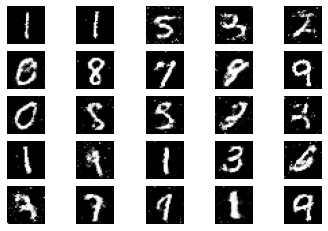

13601 [D loss: 0.659578, acc.: 58.59%] [G loss: 0.856885]
13602 [D loss: 0.676722, acc.: 55.47%] [G loss: 0.886835]
13603 [D loss: 0.662552, acc.: 60.16%] [G loss: 0.874132]
13604 [D loss: 0.662965, acc.: 58.59%] [G loss: 0.890189]
13605 [D loss: 0.651205, acc.: 59.38%] [G loss: 0.977598]
13606 [D loss: 0.660471, acc.: 63.28%] [G loss: 0.932188]
13607 [D loss: 0.657008, acc.: 62.50%] [G loss: 0.919563]
13608 [D loss: 0.661311, acc.: 60.94%] [G loss: 0.927628]
13609 [D loss: 0.673631, acc.: 59.38%] [G loss: 0.914986]
13610 [D loss: 0.614431, acc.: 70.31%] [G loss: 0.885935]
13611 [D loss: 0.620430, acc.: 67.19%] [G loss: 0.872646]
13612 [D loss: 0.642370, acc.: 61.72%] [G loss: 0.879734]
13613 [D loss: 0.643782, acc.: 65.62%] [G loss: 0.908844]
13614 [D loss: 0.648872, acc.: 60.16%] [G loss: 0.981006]
13615 [D loss: 0.675825, acc.: 58.59%] [G loss: 0.913327]
13616 [D loss: 0.652240, acc.: 60.16%] [G loss: 0.918784]
13617 [D loss: 0.675299, acc.: 57.81%] [G loss: 0.912955]
13618 [D loss:

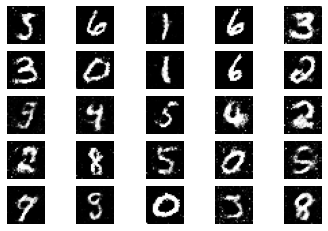

13701 [D loss: 0.649832, acc.: 59.38%] [G loss: 0.959312]
13702 [D loss: 0.657755, acc.: 58.59%] [G loss: 0.930240]
13703 [D loss: 0.624785, acc.: 67.19%] [G loss: 0.936376]
13704 [D loss: 0.686012, acc.: 55.47%] [G loss: 0.863756]
13705 [D loss: 0.677910, acc.: 60.94%] [G loss: 0.848167]
13706 [D loss: 0.679399, acc.: 60.16%] [G loss: 0.863396]
13707 [D loss: 0.674709, acc.: 55.47%] [G loss: 0.880430]
13708 [D loss: 0.644880, acc.: 62.50%] [G loss: 0.907206]
13709 [D loss: 0.659011, acc.: 58.59%] [G loss: 0.914848]
13710 [D loss: 0.679046, acc.: 56.25%] [G loss: 0.916442]
13711 [D loss: 0.660684, acc.: 61.72%] [G loss: 0.894715]
13712 [D loss: 0.654871, acc.: 59.38%] [G loss: 0.923884]
13713 [D loss: 0.691440, acc.: 52.34%] [G loss: 0.911261]
13714 [D loss: 0.681850, acc.: 59.38%] [G loss: 0.875399]
13715 [D loss: 0.633152, acc.: 58.59%] [G loss: 0.925769]
13716 [D loss: 0.638457, acc.: 60.16%] [G loss: 0.857346]
13717 [D loss: 0.653656, acc.: 59.38%] [G loss: 0.834420]
13718 [D loss:

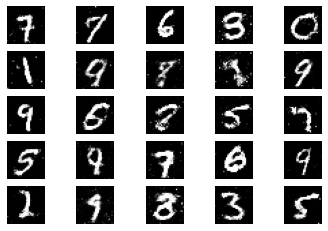

13801 [D loss: 0.708354, acc.: 52.34%] [G loss: 0.880794]
13802 [D loss: 0.675491, acc.: 60.94%] [G loss: 0.892647]
13803 [D loss: 0.637822, acc.: 63.28%] [G loss: 0.874869]
13804 [D loss: 0.686822, acc.: 54.69%] [G loss: 0.844037]
13805 [D loss: 0.658204, acc.: 61.72%] [G loss: 0.846073]
13806 [D loss: 0.637221, acc.: 61.72%] [G loss: 0.883468]
13807 [D loss: 0.642363, acc.: 60.16%] [G loss: 0.897941]
13808 [D loss: 0.638429, acc.: 64.84%] [G loss: 0.865042]
13809 [D loss: 0.685707, acc.: 57.81%] [G loss: 0.887463]
13810 [D loss: 0.673399, acc.: 57.03%] [G loss: 0.850957]
13811 [D loss: 0.656441, acc.: 58.59%] [G loss: 0.898313]
13812 [D loss: 0.679307, acc.: 57.03%] [G loss: 0.873539]
13813 [D loss: 0.657348, acc.: 61.72%] [G loss: 0.859549]
13814 [D loss: 0.684223, acc.: 63.28%] [G loss: 0.869383]
13815 [D loss: 0.658591, acc.: 62.50%] [G loss: 0.843332]
13816 [D loss: 0.689472, acc.: 50.78%] [G loss: 0.884047]
13817 [D loss: 0.692535, acc.: 53.12%] [G loss: 0.818916]
13818 [D loss:

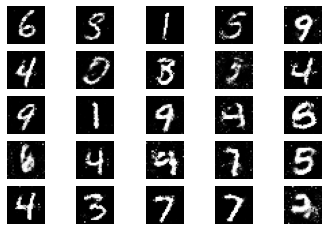

13901 [D loss: 0.653481, acc.: 60.16%] [G loss: 0.899780]
13902 [D loss: 0.735834, acc.: 51.56%] [G loss: 0.866727]
13903 [D loss: 0.673429, acc.: 59.38%] [G loss: 0.884963]
13904 [D loss: 0.647071, acc.: 65.62%] [G loss: 0.877737]
13905 [D loss: 0.642867, acc.: 66.41%] [G loss: 0.897742]
13906 [D loss: 0.643412, acc.: 66.41%] [G loss: 0.927374]
13907 [D loss: 0.668654, acc.: 60.16%] [G loss: 0.838402]
13908 [D loss: 0.643490, acc.: 64.06%] [G loss: 0.863086]
13909 [D loss: 0.606585, acc.: 65.62%] [G loss: 0.887024]
13910 [D loss: 0.668572, acc.: 58.59%] [G loss: 0.860504]
13911 [D loss: 0.633230, acc.: 65.62%] [G loss: 0.883974]
13912 [D loss: 0.667434, acc.: 59.38%] [G loss: 0.924145]
13913 [D loss: 0.694311, acc.: 51.56%] [G loss: 0.922010]
13914 [D loss: 0.667971, acc.: 61.72%] [G loss: 0.828703]
13915 [D loss: 0.649241, acc.: 64.06%] [G loss: 0.886004]
13916 [D loss: 0.656716, acc.: 66.41%] [G loss: 0.880623]
13917 [D loss: 0.607611, acc.: 64.84%] [G loss: 0.908458]
13918 [D loss:

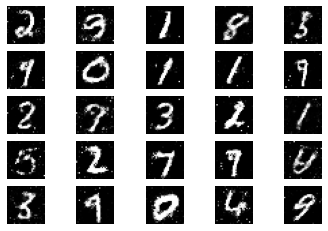

14001 [D loss: 0.682267, acc.: 53.91%] [G loss: 0.872285]
14002 [D loss: 0.650526, acc.: 62.50%] [G loss: 0.900293]
14003 [D loss: 0.671063, acc.: 59.38%] [G loss: 0.892745]
14004 [D loss: 0.666863, acc.: 63.28%] [G loss: 0.939185]
14005 [D loss: 0.658056, acc.: 61.72%] [G loss: 0.884768]
14006 [D loss: 0.682243, acc.: 57.03%] [G loss: 0.963353]
14007 [D loss: 0.632557, acc.: 67.97%] [G loss: 0.856827]
14008 [D loss: 0.658808, acc.: 55.47%] [G loss: 0.914695]
14009 [D loss: 0.659946, acc.: 58.59%] [G loss: 0.888843]
14010 [D loss: 0.659436, acc.: 59.38%] [G loss: 0.944247]
14011 [D loss: 0.619374, acc.: 62.50%] [G loss: 0.916575]
14012 [D loss: 0.694437, acc.: 52.34%] [G loss: 0.944292]
14013 [D loss: 0.677378, acc.: 58.59%] [G loss: 0.955522]
14014 [D loss: 0.661233, acc.: 64.06%] [G loss: 0.918885]
14015 [D loss: 0.653997, acc.: 58.59%] [G loss: 0.892326]
14016 [D loss: 0.643867, acc.: 62.50%] [G loss: 0.839635]
14017 [D loss: 0.681370, acc.: 57.03%] [G loss: 0.915142]
14018 [D loss:

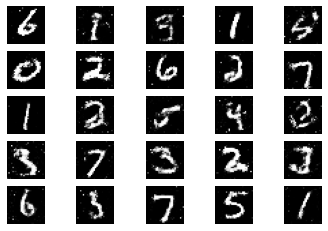

14101 [D loss: 0.697781, acc.: 56.25%] [G loss: 0.906513]
14102 [D loss: 0.634803, acc.: 63.28%] [G loss: 0.890792]
14103 [D loss: 0.653034, acc.: 61.72%] [G loss: 0.914870]
14104 [D loss: 0.645594, acc.: 64.84%] [G loss: 0.920470]
14105 [D loss: 0.643721, acc.: 58.59%] [G loss: 0.907540]
14106 [D loss: 0.671873, acc.: 53.91%] [G loss: 0.865127]
14107 [D loss: 0.680387, acc.: 54.69%] [G loss: 0.904429]
14108 [D loss: 0.642635, acc.: 63.28%] [G loss: 0.892900]
14109 [D loss: 0.644135, acc.: 61.72%] [G loss: 0.933144]
14110 [D loss: 0.695662, acc.: 57.03%] [G loss: 0.880070]
14111 [D loss: 0.634458, acc.: 68.75%] [G loss: 0.960920]
14112 [D loss: 0.641365, acc.: 69.53%] [G loss: 0.930249]
14113 [D loss: 0.629917, acc.: 65.62%] [G loss: 0.861361]
14114 [D loss: 0.671754, acc.: 58.59%] [G loss: 0.889907]
14115 [D loss: 0.628076, acc.: 64.84%] [G loss: 0.884920]
14116 [D loss: 0.627874, acc.: 67.97%] [G loss: 0.860228]
14117 [D loss: 0.632452, acc.: 62.50%] [G loss: 0.866410]
14118 [D loss:

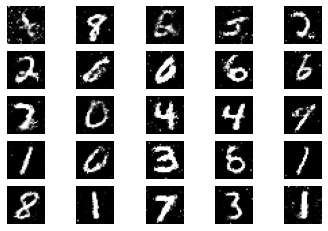

14201 [D loss: 0.687042, acc.: 53.91%] [G loss: 0.924303]
14202 [D loss: 0.685911, acc.: 57.81%] [G loss: 0.932178]
14203 [D loss: 0.655852, acc.: 56.25%] [G loss: 0.886027]
14204 [D loss: 0.659752, acc.: 58.59%] [G loss: 0.911766]
14205 [D loss: 0.667518, acc.: 60.16%] [G loss: 0.896741]
14206 [D loss: 0.658239, acc.: 62.50%] [G loss: 0.923964]
14207 [D loss: 0.661669, acc.: 60.94%] [G loss: 0.912697]
14208 [D loss: 0.682687, acc.: 53.12%] [G loss: 0.927974]
14209 [D loss: 0.646991, acc.: 59.38%] [G loss: 0.925576]
14210 [D loss: 0.656008, acc.: 63.28%] [G loss: 0.936974]
14211 [D loss: 0.635521, acc.: 62.50%] [G loss: 0.886334]
14212 [D loss: 0.647385, acc.: 64.06%] [G loss: 0.914001]
14213 [D loss: 0.660910, acc.: 56.25%] [G loss: 0.941960]
14214 [D loss: 0.679870, acc.: 56.25%] [G loss: 0.988925]
14215 [D loss: 0.699005, acc.: 52.34%] [G loss: 0.900333]
14216 [D loss: 0.663437, acc.: 65.62%] [G loss: 0.909855]
14217 [D loss: 0.625883, acc.: 62.50%] [G loss: 0.878221]
14218 [D loss:

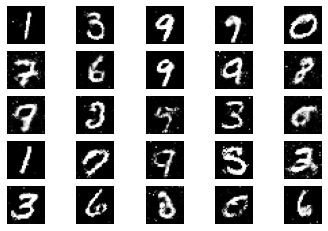

14301 [D loss: 0.646226, acc.: 60.94%] [G loss: 0.902087]
14302 [D loss: 0.672596, acc.: 54.69%] [G loss: 1.003392]
14303 [D loss: 0.659234, acc.: 64.06%] [G loss: 0.936583]
14304 [D loss: 0.662567, acc.: 59.38%] [G loss: 0.879011]
14305 [D loss: 0.687154, acc.: 55.47%] [G loss: 0.850174]
14306 [D loss: 0.677459, acc.: 59.38%] [G loss: 0.930011]
14307 [D loss: 0.634157, acc.: 67.19%] [G loss: 0.935792]
14308 [D loss: 0.664759, acc.: 61.72%] [G loss: 0.929159]
14309 [D loss: 0.656931, acc.: 57.81%] [G loss: 0.891559]
14310 [D loss: 0.633985, acc.: 63.28%] [G loss: 0.897391]
14311 [D loss: 0.680084, acc.: 59.38%] [G loss: 0.959791]
14312 [D loss: 0.608126, acc.: 70.31%] [G loss: 0.947664]
14313 [D loss: 0.633514, acc.: 64.06%] [G loss: 0.863486]
14314 [D loss: 0.625827, acc.: 64.06%] [G loss: 0.993241]
14315 [D loss: 0.652281, acc.: 63.28%] [G loss: 0.908294]
14316 [D loss: 0.667352, acc.: 58.59%] [G loss: 0.928157]
14317 [D loss: 0.615671, acc.: 67.97%] [G loss: 0.856523]
14318 [D loss:

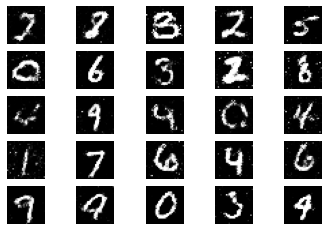

14401 [D loss: 0.673322, acc.: 59.38%] [G loss: 0.888295]
14402 [D loss: 0.696726, acc.: 60.16%] [G loss: 0.911578]
14403 [D loss: 0.626921, acc.: 62.50%] [G loss: 0.871227]
14404 [D loss: 0.661435, acc.: 64.84%] [G loss: 0.903963]
14405 [D loss: 0.650314, acc.: 57.81%] [G loss: 0.925904]
14406 [D loss: 0.633333, acc.: 63.28%] [G loss: 0.923841]
14407 [D loss: 0.653782, acc.: 52.34%] [G loss: 0.957199]
14408 [D loss: 0.653171, acc.: 63.28%] [G loss: 0.851437]
14409 [D loss: 0.645091, acc.: 61.72%] [G loss: 0.878201]
14410 [D loss: 0.636674, acc.: 64.84%] [G loss: 0.906282]
14411 [D loss: 0.640445, acc.: 64.06%] [G loss: 0.978838]
14412 [D loss: 0.687432, acc.: 56.25%] [G loss: 1.009138]
14413 [D loss: 0.686099, acc.: 58.59%] [G loss: 0.920617]
14414 [D loss: 0.699778, acc.: 55.47%] [G loss: 0.890148]
14415 [D loss: 0.660166, acc.: 63.28%] [G loss: 0.918282]
14416 [D loss: 0.624059, acc.: 64.06%] [G loss: 0.967081]
14417 [D loss: 0.674156, acc.: 57.81%] [G loss: 0.875802]
14418 [D loss:

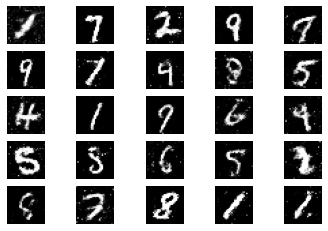

14501 [D loss: 0.621107, acc.: 63.28%] [G loss: 0.868828]
14502 [D loss: 0.679991, acc.: 58.59%] [G loss: 0.903263]
14503 [D loss: 0.661417, acc.: 57.81%] [G loss: 0.887177]
14504 [D loss: 0.676866, acc.: 58.59%] [G loss: 0.855178]
14505 [D loss: 0.658861, acc.: 60.16%] [G loss: 0.895179]
14506 [D loss: 0.670736, acc.: 55.47%] [G loss: 0.855184]
14507 [D loss: 0.610139, acc.: 69.53%] [G loss: 0.896022]
14508 [D loss: 0.688677, acc.: 56.25%] [G loss: 0.830838]
14509 [D loss: 0.684628, acc.: 53.12%] [G loss: 0.953801]
14510 [D loss: 0.659792, acc.: 59.38%] [G loss: 0.924089]
14511 [D loss: 0.663888, acc.: 64.84%] [G loss: 0.920393]
14512 [D loss: 0.667675, acc.: 59.38%] [G loss: 0.967545]
14513 [D loss: 0.633167, acc.: 62.50%] [G loss: 0.938702]
14514 [D loss: 0.682285, acc.: 54.69%] [G loss: 0.831959]
14515 [D loss: 0.652369, acc.: 61.72%] [G loss: 0.891242]
14516 [D loss: 0.646529, acc.: 60.94%] [G loss: 0.864874]
14517 [D loss: 0.654328, acc.: 57.81%] [G loss: 0.891775]
14518 [D loss:

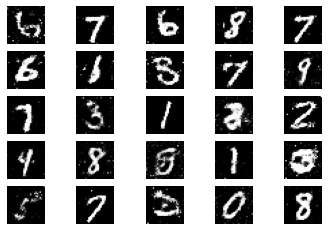

14601 [D loss: 0.662682, acc.: 57.81%] [G loss: 0.907169]
14602 [D loss: 0.649390, acc.: 60.16%] [G loss: 0.907477]
14603 [D loss: 0.628136, acc.: 69.53%] [G loss: 0.903939]
14604 [D loss: 0.668517, acc.: 57.81%] [G loss: 0.876786]
14605 [D loss: 0.665416, acc.: 65.62%] [G loss: 0.884219]
14606 [D loss: 0.694093, acc.: 52.34%] [G loss: 0.855185]
14607 [D loss: 0.666600, acc.: 60.94%] [G loss: 0.861699]
14608 [D loss: 0.655333, acc.: 61.72%] [G loss: 0.919116]
14609 [D loss: 0.647466, acc.: 66.41%] [G loss: 0.931999]
14610 [D loss: 0.680794, acc.: 58.59%] [G loss: 0.890924]
14611 [D loss: 0.674790, acc.: 53.91%] [G loss: 0.874807]
14612 [D loss: 0.655152, acc.: 64.06%] [G loss: 0.826229]
14613 [D loss: 0.635600, acc.: 67.97%] [G loss: 0.896468]
14614 [D loss: 0.630470, acc.: 64.06%] [G loss: 0.990211]
14615 [D loss: 0.664575, acc.: 59.38%] [G loss: 0.912144]
14616 [D loss: 0.612830, acc.: 67.97%] [G loss: 0.909695]
14617 [D loss: 0.700249, acc.: 50.00%] [G loss: 0.956832]
14618 [D loss:

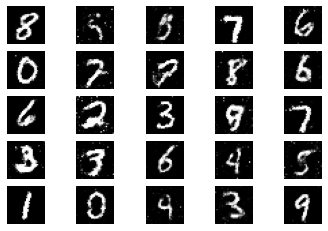

14701 [D loss: 0.678241, acc.: 57.03%] [G loss: 0.910893]
14702 [D loss: 0.670913, acc.: 59.38%] [G loss: 0.960932]
14703 [D loss: 0.678407, acc.: 57.03%] [G loss: 0.923696]
14704 [D loss: 0.666275, acc.: 54.69%] [G loss: 0.845804]
14705 [D loss: 0.674145, acc.: 53.12%] [G loss: 0.890813]
14706 [D loss: 0.690954, acc.: 50.00%] [G loss: 0.881608]
14707 [D loss: 0.643793, acc.: 60.94%] [G loss: 0.848470]
14708 [D loss: 0.644799, acc.: 63.28%] [G loss: 0.912199]
14709 [D loss: 0.680492, acc.: 54.69%] [G loss: 0.916709]
14710 [D loss: 0.679728, acc.: 55.47%] [G loss: 0.883785]
14711 [D loss: 0.665890, acc.: 58.59%] [G loss: 0.895124]
14712 [D loss: 0.652913, acc.: 59.38%] [G loss: 0.875067]
14713 [D loss: 0.657510, acc.: 58.59%] [G loss: 0.893331]
14714 [D loss: 0.693653, acc.: 54.69%] [G loss: 0.926234]
14715 [D loss: 0.628944, acc.: 67.19%] [G loss: 0.860139]
14716 [D loss: 0.678654, acc.: 57.03%] [G loss: 0.936328]
14717 [D loss: 0.631835, acc.: 71.88%] [G loss: 0.887942]
14718 [D loss:

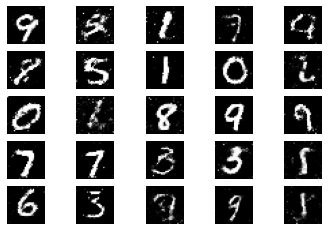

14801 [D loss: 0.634383, acc.: 64.06%] [G loss: 0.855305]
14802 [D loss: 0.649766, acc.: 64.06%] [G loss: 0.920582]
14803 [D loss: 0.594222, acc.: 71.09%] [G loss: 0.880526]
14804 [D loss: 0.699882, acc.: 57.03%] [G loss: 0.936875]
14805 [D loss: 0.703982, acc.: 50.00%] [G loss: 0.867972]
14806 [D loss: 0.630812, acc.: 62.50%] [G loss: 0.878380]
14807 [D loss: 0.678114, acc.: 56.25%] [G loss: 0.913280]
14808 [D loss: 0.634288, acc.: 60.94%] [G loss: 0.876970]
14809 [D loss: 0.680778, acc.: 57.03%] [G loss: 0.943953]
14810 [D loss: 0.691512, acc.: 55.47%] [G loss: 0.881453]
14811 [D loss: 0.647837, acc.: 58.59%] [G loss: 0.872306]
14812 [D loss: 0.673799, acc.: 57.03%] [G loss: 0.897406]
14813 [D loss: 0.651645, acc.: 57.81%] [G loss: 0.890116]
14814 [D loss: 0.707438, acc.: 51.56%] [G loss: 0.870069]
14815 [D loss: 0.646255, acc.: 61.72%] [G loss: 0.893133]
14816 [D loss: 0.640571, acc.: 66.41%] [G loss: 0.932576]
14817 [D loss: 0.646143, acc.: 59.38%] [G loss: 0.845237]
14818 [D loss:

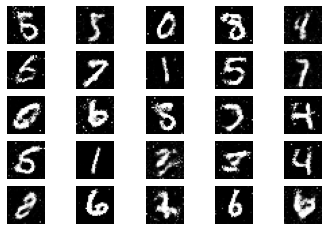

14901 [D loss: 0.636622, acc.: 68.75%] [G loss: 0.928287]
14902 [D loss: 0.639434, acc.: 65.62%] [G loss: 0.920164]
14903 [D loss: 0.617151, acc.: 64.06%] [G loss: 0.939670]
14904 [D loss: 0.653697, acc.: 64.84%] [G loss: 0.950869]
14905 [D loss: 0.646433, acc.: 60.94%] [G loss: 0.888896]
14906 [D loss: 0.646825, acc.: 57.03%] [G loss: 0.942117]
14907 [D loss: 0.651506, acc.: 60.94%] [G loss: 0.919856]
14908 [D loss: 0.648941, acc.: 60.16%] [G loss: 0.893112]
14909 [D loss: 0.679078, acc.: 57.81%] [G loss: 0.962401]
14910 [D loss: 0.677130, acc.: 56.25%] [G loss: 0.929250]
14911 [D loss: 0.635012, acc.: 66.41%] [G loss: 0.878722]
14912 [D loss: 0.602870, acc.: 66.41%] [G loss: 0.871724]
14913 [D loss: 0.645321, acc.: 57.03%] [G loss: 0.968083]
14914 [D loss: 0.680943, acc.: 61.72%] [G loss: 0.893483]
14915 [D loss: 0.663691, acc.: 55.47%] [G loss: 0.852498]
14916 [D loss: 0.636026, acc.: 66.41%] [G loss: 0.896885]
14917 [D loss: 0.658141, acc.: 59.38%] [G loss: 0.868320]
14918 [D loss:

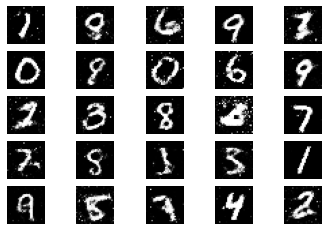

15001 [D loss: 0.678921, acc.: 57.03%] [G loss: 0.873912]
15002 [D loss: 0.685073, acc.: 54.69%] [G loss: 0.881226]
15003 [D loss: 0.672405, acc.: 63.28%] [G loss: 0.860157]
15004 [D loss: 0.653413, acc.: 57.81%] [G loss: 0.899842]
15005 [D loss: 0.683042, acc.: 55.47%] [G loss: 0.839050]
15006 [D loss: 0.671196, acc.: 55.47%] [G loss: 0.928760]
15007 [D loss: 0.644683, acc.: 67.97%] [G loss: 0.887099]
15008 [D loss: 0.668648, acc.: 55.47%] [G loss: 0.886883]
15009 [D loss: 0.654872, acc.: 62.50%] [G loss: 0.942281]
15010 [D loss: 0.642626, acc.: 63.28%] [G loss: 0.917626]
15011 [D loss: 0.674759, acc.: 59.38%] [G loss: 0.867686]
15012 [D loss: 0.649573, acc.: 61.72%] [G loss: 0.808898]
15013 [D loss: 0.677802, acc.: 57.03%] [G loss: 0.837414]
15014 [D loss: 0.644818, acc.: 58.59%] [G loss: 0.926434]
15015 [D loss: 0.647272, acc.: 60.94%] [G loss: 0.893142]
15016 [D loss: 0.645184, acc.: 64.84%] [G loss: 0.873587]
15017 [D loss: 0.678050, acc.: 59.38%] [G loss: 0.948826]
15018 [D loss:

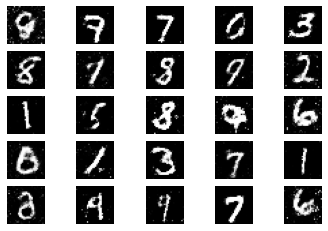

15101 [D loss: 0.634989, acc.: 63.28%] [G loss: 0.969233]
15102 [D loss: 0.649136, acc.: 58.59%] [G loss: 0.883810]
15103 [D loss: 0.673302, acc.: 58.59%] [G loss: 0.868690]
15104 [D loss: 0.648682, acc.: 62.50%] [G loss: 0.913961]
15105 [D loss: 0.676046, acc.: 57.03%] [G loss: 0.840993]
15106 [D loss: 0.642358, acc.: 66.41%] [G loss: 0.819516]
15107 [D loss: 0.698910, acc.: 57.81%] [G loss: 0.833118]
15108 [D loss: 0.701039, acc.: 50.78%] [G loss: 0.904711]
15109 [D loss: 0.675147, acc.: 57.03%] [G loss: 0.895817]
15110 [D loss: 0.630940, acc.: 65.62%] [G loss: 0.913075]
15111 [D loss: 0.655465, acc.: 60.94%] [G loss: 0.928207]
15112 [D loss: 0.619968, acc.: 65.62%] [G loss: 0.902851]
15113 [D loss: 0.664187, acc.: 57.81%] [G loss: 0.848909]
15114 [D loss: 0.638715, acc.: 60.94%] [G loss: 0.922144]
15115 [D loss: 0.708019, acc.: 47.66%] [G loss: 0.945829]
15116 [D loss: 0.625194, acc.: 66.41%] [G loss: 0.934823]
15117 [D loss: 0.638717, acc.: 70.31%] [G loss: 0.932974]
15118 [D loss:

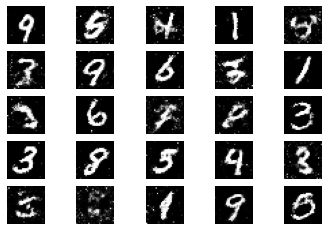

15201 [D loss: 0.679730, acc.: 56.25%] [G loss: 0.873552]
15202 [D loss: 0.634051, acc.: 66.41%] [G loss: 0.912094]
15203 [D loss: 0.646921, acc.: 65.62%] [G loss: 0.912499]
15204 [D loss: 0.681460, acc.: 53.91%] [G loss: 0.871075]
15205 [D loss: 0.639293, acc.: 66.41%] [G loss: 0.877661]
15206 [D loss: 0.624778, acc.: 62.50%] [G loss: 0.923536]
15207 [D loss: 0.620138, acc.: 60.94%] [G loss: 1.013086]
15208 [D loss: 0.680781, acc.: 57.03%] [G loss: 0.905837]
15209 [D loss: 0.631021, acc.: 65.62%] [G loss: 0.911689]
15210 [D loss: 0.679536, acc.: 59.38%] [G loss: 0.920554]
15211 [D loss: 0.621693, acc.: 64.06%] [G loss: 0.967244]
15212 [D loss: 0.636796, acc.: 58.59%] [G loss: 0.877450]
15213 [D loss: 0.674793, acc.: 58.59%] [G loss: 0.917372]
15214 [D loss: 0.658989, acc.: 57.03%] [G loss: 0.956857]
15215 [D loss: 0.689494, acc.: 53.12%] [G loss: 0.926202]
15216 [D loss: 0.614145, acc.: 64.06%] [G loss: 0.888670]
15217 [D loss: 0.667202, acc.: 53.12%] [G loss: 0.916267]
15218 [D loss:

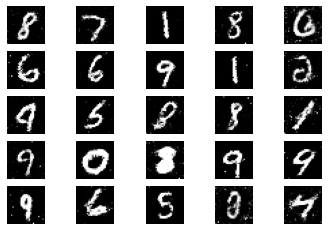

15301 [D loss: 0.672673, acc.: 56.25%] [G loss: 0.874617]
15302 [D loss: 0.683976, acc.: 52.34%] [G loss: 0.859683]
15303 [D loss: 0.664820, acc.: 59.38%] [G loss: 0.828803]
15304 [D loss: 0.642963, acc.: 60.16%] [G loss: 0.875907]
15305 [D loss: 0.624557, acc.: 67.19%] [G loss: 0.868121]
15306 [D loss: 0.663067, acc.: 59.38%] [G loss: 0.960104]
15307 [D loss: 0.641923, acc.: 58.59%] [G loss: 0.901780]
15308 [D loss: 0.656150, acc.: 58.59%] [G loss: 0.898022]
15309 [D loss: 0.668027, acc.: 57.81%] [G loss: 0.865721]
15310 [D loss: 0.604938, acc.: 66.41%] [G loss: 0.846859]
15311 [D loss: 0.653607, acc.: 57.03%] [G loss: 0.822354]
15312 [D loss: 0.716593, acc.: 52.34%] [G loss: 0.943164]
15313 [D loss: 0.646623, acc.: 59.38%] [G loss: 0.889027]
15314 [D loss: 0.680131, acc.: 55.47%] [G loss: 0.866532]
15315 [D loss: 0.624059, acc.: 65.62%] [G loss: 0.907163]
15316 [D loss: 0.630158, acc.: 67.19%] [G loss: 0.853206]
15317 [D loss: 0.663649, acc.: 59.38%] [G loss: 0.836178]
15318 [D loss:

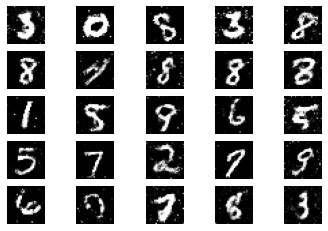

15401 [D loss: 0.667062, acc.: 61.72%] [G loss: 0.946606]
15402 [D loss: 0.649263, acc.: 60.16%] [G loss: 0.896935]
15403 [D loss: 0.657812, acc.: 57.03%] [G loss: 0.876590]
15404 [D loss: 0.655893, acc.: 61.72%] [G loss: 0.903320]
15405 [D loss: 0.732031, acc.: 49.22%] [G loss: 0.806077]
15406 [D loss: 0.662374, acc.: 56.25%] [G loss: 0.960769]
15407 [D loss: 0.630845, acc.: 60.16%] [G loss: 0.952284]
15408 [D loss: 0.655043, acc.: 58.59%] [G loss: 0.874376]
15409 [D loss: 0.668264, acc.: 54.69%] [G loss: 0.869818]
15410 [D loss: 0.624736, acc.: 67.97%] [G loss: 0.896813]
15411 [D loss: 0.691344, acc.: 49.22%] [G loss: 0.908171]
15412 [D loss: 0.676454, acc.: 60.94%] [G loss: 0.904573]
15413 [D loss: 0.665253, acc.: 62.50%] [G loss: 0.959298]
15414 [D loss: 0.660789, acc.: 60.94%] [G loss: 0.881236]
15415 [D loss: 0.661182, acc.: 58.59%] [G loss: 0.940608]
15416 [D loss: 0.669713, acc.: 53.91%] [G loss: 0.897839]
15417 [D loss: 0.691403, acc.: 53.12%] [G loss: 0.836898]
15418 [D loss:

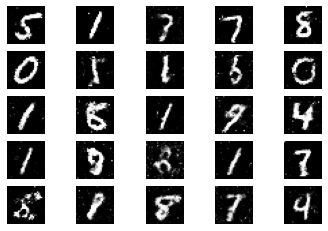

15501 [D loss: 0.706326, acc.: 54.69%] [G loss: 0.919145]
15502 [D loss: 0.697101, acc.: 57.03%] [G loss: 0.895320]
15503 [D loss: 0.656657, acc.: 64.06%] [G loss: 0.878248]
15504 [D loss: 0.681726, acc.: 53.12%] [G loss: 0.916490]
15505 [D loss: 0.700315, acc.: 53.91%] [G loss: 0.914827]
15506 [D loss: 0.629380, acc.: 67.97%] [G loss: 0.907978]
15507 [D loss: 0.674590, acc.: 55.47%] [G loss: 0.866460]
15508 [D loss: 0.668240, acc.: 60.94%] [G loss: 0.836173]
15509 [D loss: 0.687537, acc.: 49.22%] [G loss: 0.899400]
15510 [D loss: 0.667278, acc.: 61.72%] [G loss: 0.883967]
15511 [D loss: 0.614920, acc.: 65.62%] [G loss: 0.871408]
15512 [D loss: 0.712925, acc.: 53.12%] [G loss: 0.925991]
15513 [D loss: 0.671917, acc.: 58.59%] [G loss: 0.870424]
15514 [D loss: 0.620957, acc.: 63.28%] [G loss: 0.876635]
15515 [D loss: 0.633202, acc.: 63.28%] [G loss: 0.814447]
15516 [D loss: 0.702279, acc.: 57.03%] [G loss: 0.888824]
15517 [D loss: 0.681149, acc.: 54.69%] [G loss: 0.907119]
15518 [D loss:

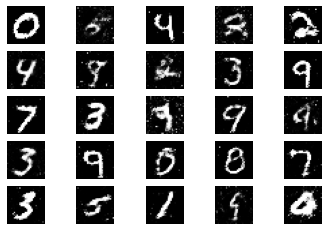

15601 [D loss: 0.631637, acc.: 69.53%] [G loss: 0.896852]
15602 [D loss: 0.636793, acc.: 64.06%] [G loss: 0.889151]
15603 [D loss: 0.663660, acc.: 58.59%] [G loss: 0.892990]
15604 [D loss: 0.706449, acc.: 50.00%] [G loss: 0.871976]
15605 [D loss: 0.656106, acc.: 59.38%] [G loss: 0.863893]
15606 [D loss: 0.706286, acc.: 55.47%] [G loss: 0.869635]
15607 [D loss: 0.667998, acc.: 58.59%] [G loss: 0.847471]
15608 [D loss: 0.646452, acc.: 65.62%] [G loss: 0.934441]
15609 [D loss: 0.654982, acc.: 60.94%] [G loss: 0.909444]
15610 [D loss: 0.682806, acc.: 53.91%] [G loss: 0.931154]
15611 [D loss: 0.673126, acc.: 63.28%] [G loss: 0.935539]
15612 [D loss: 0.665818, acc.: 59.38%] [G loss: 0.902660]
15613 [D loss: 0.652988, acc.: 59.38%] [G loss: 0.943480]
15614 [D loss: 0.637935, acc.: 57.81%] [G loss: 0.886781]
15615 [D loss: 0.708929, acc.: 55.47%] [G loss: 0.885184]
15616 [D loss: 0.624066, acc.: 69.53%] [G loss: 0.833213]
15617 [D loss: 0.689268, acc.: 53.91%] [G loss: 0.835231]
15618 [D loss:

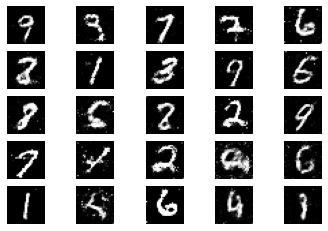

15701 [D loss: 0.705165, acc.: 51.56%] [G loss: 0.902732]
15702 [D loss: 0.633277, acc.: 57.03%] [G loss: 0.904372]
15703 [D loss: 0.687766, acc.: 53.91%] [G loss: 0.855365]
15704 [D loss: 0.645370, acc.: 64.84%] [G loss: 0.892810]
15705 [D loss: 0.678308, acc.: 56.25%] [G loss: 0.848786]
15706 [D loss: 0.645393, acc.: 64.06%] [G loss: 0.918519]
15707 [D loss: 0.688440, acc.: 59.38%] [G loss: 0.878214]
15708 [D loss: 0.665541, acc.: 60.16%] [G loss: 0.920085]
15709 [D loss: 0.677167, acc.: 53.12%] [G loss: 0.857573]
15710 [D loss: 0.678124, acc.: 57.81%] [G loss: 0.904071]
15711 [D loss: 0.646783, acc.: 61.72%] [G loss: 0.884334]
15712 [D loss: 0.671894, acc.: 60.94%] [G loss: 0.885655]
15713 [D loss: 0.647046, acc.: 67.97%] [G loss: 0.912917]
15714 [D loss: 0.668157, acc.: 57.81%] [G loss: 0.912337]
15715 [D loss: 0.629652, acc.: 70.31%] [G loss: 0.976427]
15716 [D loss: 0.658441, acc.: 53.91%] [G loss: 0.928591]
15717 [D loss: 0.695548, acc.: 53.91%] [G loss: 0.901279]
15718 [D loss:

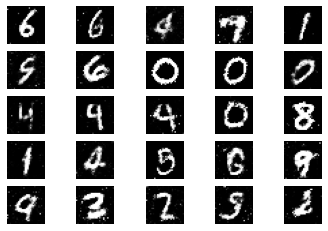

15801 [D loss: 0.670507, acc.: 63.28%] [G loss: 0.868168]
15802 [D loss: 0.680089, acc.: 55.47%] [G loss: 0.853023]
15803 [D loss: 0.647624, acc.: 59.38%] [G loss: 0.915938]
15804 [D loss: 0.688617, acc.: 54.69%] [G loss: 0.978754]
15805 [D loss: 0.638495, acc.: 60.94%] [G loss: 0.913556]
15806 [D loss: 0.596679, acc.: 69.53%] [G loss: 0.898708]
15807 [D loss: 0.662975, acc.: 60.94%] [G loss: 0.895682]
15808 [D loss: 0.651622, acc.: 63.28%] [G loss: 0.894788]
15809 [D loss: 0.672226, acc.: 54.69%] [G loss: 0.805093]
15810 [D loss: 0.652304, acc.: 65.62%] [G loss: 0.844004]
15811 [D loss: 0.669043, acc.: 57.03%] [G loss: 0.949456]
15812 [D loss: 0.676889, acc.: 60.94%] [G loss: 0.966052]
15813 [D loss: 0.649275, acc.: 58.59%] [G loss: 0.999320]
15814 [D loss: 0.678007, acc.: 55.47%] [G loss: 0.912250]
15815 [D loss: 0.659456, acc.: 59.38%] [G loss: 0.897632]
15816 [D loss: 0.667208, acc.: 55.47%] [G loss: 0.918862]
15817 [D loss: 0.685617, acc.: 59.38%] [G loss: 0.869609]
15818 [D loss:

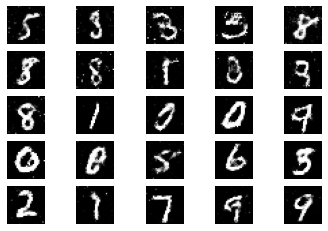

15901 [D loss: 0.647427, acc.: 67.19%] [G loss: 0.957525]
15902 [D loss: 0.665453, acc.: 61.72%] [G loss: 0.855135]
15903 [D loss: 0.668283, acc.: 62.50%] [G loss: 0.958489]
15904 [D loss: 0.617117, acc.: 64.06%] [G loss: 0.917266]
15905 [D loss: 0.637145, acc.: 60.94%] [G loss: 0.880903]
15906 [D loss: 0.644287, acc.: 59.38%] [G loss: 0.897302]
15907 [D loss: 0.581222, acc.: 69.53%] [G loss: 0.920947]
15908 [D loss: 0.714478, acc.: 53.12%] [G loss: 0.877947]
15909 [D loss: 0.688934, acc.: 57.81%] [G loss: 0.881393]
15910 [D loss: 0.692968, acc.: 61.72%] [G loss: 0.986469]
15911 [D loss: 0.664132, acc.: 63.28%] [G loss: 0.960636]
15912 [D loss: 0.640292, acc.: 67.19%] [G loss: 0.987835]
15913 [D loss: 0.667585, acc.: 57.81%] [G loss: 0.912287]
15914 [D loss: 0.659971, acc.: 60.94%] [G loss: 0.949922]
15915 [D loss: 0.649643, acc.: 64.06%] [G loss: 0.938233]
15916 [D loss: 0.655350, acc.: 61.72%] [G loss: 0.939628]
15917 [D loss: 0.659310, acc.: 59.38%] [G loss: 0.882668]
15918 [D loss:

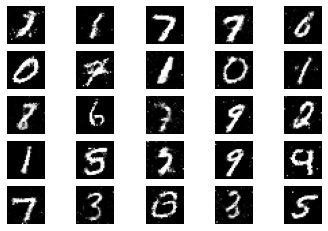

16001 [D loss: 0.651675, acc.: 62.50%] [G loss: 0.880970]
16002 [D loss: 0.689549, acc.: 56.25%] [G loss: 0.905534]
16003 [D loss: 0.632495, acc.: 64.06%] [G loss: 0.892514]
16004 [D loss: 0.642194, acc.: 61.72%] [G loss: 0.957915]
16005 [D loss: 0.641573, acc.: 65.62%] [G loss: 0.994023]
16006 [D loss: 0.649182, acc.: 59.38%] [G loss: 0.914767]
16007 [D loss: 0.704061, acc.: 56.25%] [G loss: 0.885693]
16008 [D loss: 0.620642, acc.: 63.28%] [G loss: 0.914295]
16009 [D loss: 0.642081, acc.: 65.62%] [G loss: 0.959419]
16010 [D loss: 0.657616, acc.: 60.16%] [G loss: 0.892762]
16011 [D loss: 0.651091, acc.: 56.25%] [G loss: 0.861326]
16012 [D loss: 0.604508, acc.: 69.53%] [G loss: 0.935877]
16013 [D loss: 0.707902, acc.: 53.12%] [G loss: 0.904565]
16014 [D loss: 0.606153, acc.: 67.19%] [G loss: 0.952699]
16015 [D loss: 0.696150, acc.: 56.25%] [G loss: 0.940858]
16016 [D loss: 0.662467, acc.: 58.59%] [G loss: 0.899207]
16017 [D loss: 0.632423, acc.: 67.19%] [G loss: 0.825216]
16018 [D loss:

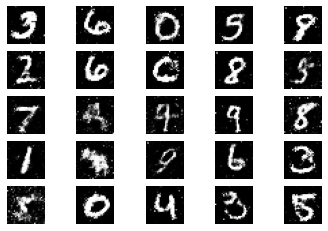

16101 [D loss: 0.699174, acc.: 51.56%] [G loss: 0.855462]
16102 [D loss: 0.657457, acc.: 60.94%] [G loss: 0.909541]
16103 [D loss: 0.659412, acc.: 60.94%] [G loss: 0.809645]
16104 [D loss: 0.665471, acc.: 58.59%] [G loss: 0.867709]
16105 [D loss: 0.660408, acc.: 62.50%] [G loss: 0.882154]
16106 [D loss: 0.694326, acc.: 57.81%] [G loss: 0.906251]
16107 [D loss: 0.650392, acc.: 61.72%] [G loss: 0.923223]
16108 [D loss: 0.638770, acc.: 59.38%] [G loss: 0.902983]
16109 [D loss: 0.656551, acc.: 60.94%] [G loss: 0.854759]
16110 [D loss: 0.648155, acc.: 58.59%] [G loss: 0.919399]
16111 [D loss: 0.671809, acc.: 61.72%] [G loss: 0.904451]
16112 [D loss: 0.665969, acc.: 55.47%] [G loss: 0.928146]
16113 [D loss: 0.675406, acc.: 60.16%] [G loss: 0.873452]
16114 [D loss: 0.659586, acc.: 55.47%] [G loss: 0.910398]
16115 [D loss: 0.660391, acc.: 58.59%] [G loss: 0.912539]
16116 [D loss: 0.691594, acc.: 52.34%] [G loss: 0.845701]
16117 [D loss: 0.649811, acc.: 58.59%] [G loss: 0.932993]
16118 [D loss:

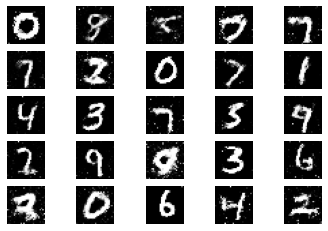

16201 [D loss: 0.619593, acc.: 65.62%] [G loss: 0.927072]
16202 [D loss: 0.683835, acc.: 53.12%] [G loss: 0.950030]
16203 [D loss: 0.650612, acc.: 67.97%] [G loss: 0.939830]
16204 [D loss: 0.649616, acc.: 57.81%] [G loss: 0.898126]
16205 [D loss: 0.695321, acc.: 57.03%] [G loss: 0.831702]
16206 [D loss: 0.654533, acc.: 60.94%] [G loss: 0.865268]
16207 [D loss: 0.709958, acc.: 50.00%] [G loss: 0.867481]
16208 [D loss: 0.667794, acc.: 54.69%] [G loss: 0.850659]
16209 [D loss: 0.623676, acc.: 66.41%] [G loss: 0.882466]
16210 [D loss: 0.649663, acc.: 60.94%] [G loss: 0.872407]
16211 [D loss: 0.655382, acc.: 59.38%] [G loss: 0.884568]
16212 [D loss: 0.650884, acc.: 64.06%] [G loss: 0.959034]
16213 [D loss: 0.678598, acc.: 64.84%] [G loss: 0.860427]
16214 [D loss: 0.673917, acc.: 53.91%] [G loss: 0.927715]
16215 [D loss: 0.613696, acc.: 65.62%] [G loss: 0.885846]
16216 [D loss: 0.680489, acc.: 57.81%] [G loss: 0.860906]
16217 [D loss: 0.659004, acc.: 59.38%] [G loss: 0.922170]
16218 [D loss:

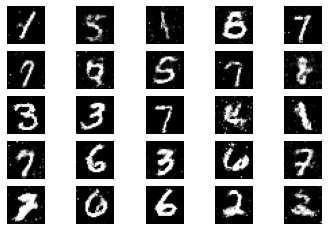

16301 [D loss: 0.685237, acc.: 57.81%] [G loss: 0.872290]
16302 [D loss: 0.667249, acc.: 59.38%] [G loss: 0.882008]
16303 [D loss: 0.631628, acc.: 66.41%] [G loss: 0.894057]
16304 [D loss: 0.636118, acc.: 63.28%] [G loss: 0.862033]
16305 [D loss: 0.674443, acc.: 57.03%] [G loss: 0.916642]
16306 [D loss: 0.624245, acc.: 67.19%] [G loss: 0.960428]
16307 [D loss: 0.664606, acc.: 58.59%] [G loss: 0.902266]
16308 [D loss: 0.642713, acc.: 63.28%] [G loss: 0.888971]
16309 [D loss: 0.639058, acc.: 61.72%] [G loss: 0.967092]
16310 [D loss: 0.690015, acc.: 60.94%] [G loss: 0.913755]
16311 [D loss: 0.705626, acc.: 57.81%] [G loss: 0.818650]
16312 [D loss: 0.623770, acc.: 64.84%] [G loss: 0.885876]
16313 [D loss: 0.661002, acc.: 60.16%] [G loss: 0.981311]
16314 [D loss: 0.700712, acc.: 51.56%] [G loss: 0.976080]
16315 [D loss: 0.624645, acc.: 63.28%] [G loss: 0.881725]
16316 [D loss: 0.674025, acc.: 55.47%] [G loss: 0.921406]
16317 [D loss: 0.675835, acc.: 59.38%] [G loss: 0.879434]
16318 [D loss:

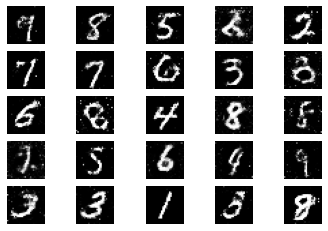

16401 [D loss: 0.640649, acc.: 59.38%] [G loss: 0.877419]
16402 [D loss: 0.651829, acc.: 59.38%] [G loss: 0.883851]
16403 [D loss: 0.638419, acc.: 60.94%] [G loss: 0.879559]
16404 [D loss: 0.676475, acc.: 52.34%] [G loss: 0.935234]
16405 [D loss: 0.688859, acc.: 53.91%] [G loss: 0.876518]
16406 [D loss: 0.652591, acc.: 59.38%] [G loss: 0.864791]
16407 [D loss: 0.620415, acc.: 67.19%] [G loss: 0.874886]
16408 [D loss: 0.644461, acc.: 65.62%] [G loss: 0.910414]
16409 [D loss: 0.684439, acc.: 60.94%] [G loss: 0.939065]
16410 [D loss: 0.734815, acc.: 52.34%] [G loss: 0.928346]
16411 [D loss: 0.675781, acc.: 58.59%] [G loss: 0.916988]
16412 [D loss: 0.683852, acc.: 50.78%] [G loss: 0.883732]
16413 [D loss: 0.616887, acc.: 67.97%] [G loss: 0.952717]
16414 [D loss: 0.609582, acc.: 65.62%] [G loss: 0.915095]
16415 [D loss: 0.686483, acc.: 54.69%] [G loss: 0.926284]
16416 [D loss: 0.688112, acc.: 56.25%] [G loss: 0.939311]
16417 [D loss: 0.661673, acc.: 57.81%] [G loss: 0.900370]
16418 [D loss:

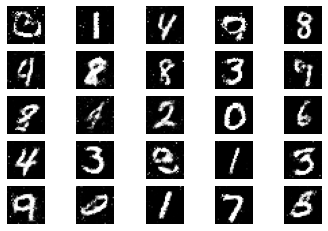

16501 [D loss: 0.665890, acc.: 57.03%] [G loss: 0.872963]
16502 [D loss: 0.661741, acc.: 62.50%] [G loss: 0.882143]
16503 [D loss: 0.716868, acc.: 57.03%] [G loss: 0.947089]
16504 [D loss: 0.645190, acc.: 62.50%] [G loss: 0.960029]
16505 [D loss: 0.650986, acc.: 60.94%] [G loss: 0.884339]
16506 [D loss: 0.634036, acc.: 62.50%] [G loss: 0.917244]
16507 [D loss: 0.715932, acc.: 56.25%] [G loss: 0.922459]
16508 [D loss: 0.674788, acc.: 57.03%] [G loss: 0.976347]
16509 [D loss: 0.630704, acc.: 63.28%] [G loss: 0.900221]
16510 [D loss: 0.651564, acc.: 57.81%] [G loss: 0.941478]
16511 [D loss: 0.660866, acc.: 61.72%] [G loss: 0.890224]
16512 [D loss: 0.634647, acc.: 61.72%] [G loss: 0.926310]
16513 [D loss: 0.660219, acc.: 56.25%] [G loss: 0.952609]
16514 [D loss: 0.649628, acc.: 57.81%] [G loss: 1.002430]
16515 [D loss: 0.633652, acc.: 62.50%] [G loss: 0.871025]
16516 [D loss: 0.657731, acc.: 60.16%] [G loss: 0.901031]
16517 [D loss: 0.652998, acc.: 60.94%] [G loss: 0.860117]
16518 [D loss:

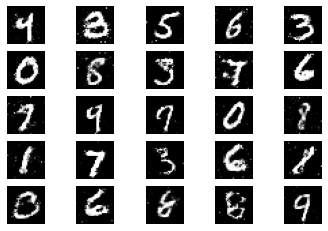

16601 [D loss: 0.673363, acc.: 61.72%] [G loss: 0.882675]
16602 [D loss: 0.667898, acc.: 56.25%] [G loss: 0.891456]
16603 [D loss: 0.637637, acc.: 64.84%] [G loss: 0.912672]
16604 [D loss: 0.655447, acc.: 58.59%] [G loss: 0.877711]
16605 [D loss: 0.666653, acc.: 58.59%] [G loss: 0.927688]
16606 [D loss: 0.681425, acc.: 53.91%] [G loss: 0.938492]
16607 [D loss: 0.657234, acc.: 60.94%] [G loss: 0.892578]
16608 [D loss: 0.674513, acc.: 53.12%] [G loss: 0.867617]
16609 [D loss: 0.659585, acc.: 53.91%] [G loss: 0.908037]
16610 [D loss: 0.638366, acc.: 67.19%] [G loss: 0.837025]
16611 [D loss: 0.699614, acc.: 53.91%] [G loss: 0.828192]
16612 [D loss: 0.640968, acc.: 64.84%] [G loss: 0.920953]
16613 [D loss: 0.636353, acc.: 62.50%] [G loss: 0.895068]
16614 [D loss: 0.673822, acc.: 56.25%] [G loss: 0.896679]
16615 [D loss: 0.713484, acc.: 47.66%] [G loss: 0.974355]
16616 [D loss: 0.648691, acc.: 60.94%] [G loss: 0.865192]
16617 [D loss: 0.663399, acc.: 60.94%] [G loss: 0.910668]
16618 [D loss:

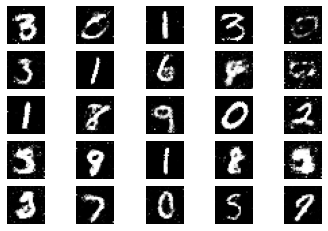

16701 [D loss: 0.661583, acc.: 59.38%] [G loss: 0.860663]
16702 [D loss: 0.677190, acc.: 54.69%] [G loss: 0.855714]
16703 [D loss: 0.664307, acc.: 57.03%] [G loss: 0.885193]
16704 [D loss: 0.683237, acc.: 56.25%] [G loss: 0.920531]
16705 [D loss: 0.634601, acc.: 68.75%] [G loss: 0.920348]
16706 [D loss: 0.665505, acc.: 59.38%] [G loss: 0.867539]
16707 [D loss: 0.655389, acc.: 59.38%] [G loss: 0.929731]
16708 [D loss: 0.618785, acc.: 67.97%] [G loss: 0.979560]
16709 [D loss: 0.696519, acc.: 59.38%] [G loss: 0.820971]
16710 [D loss: 0.659323, acc.: 63.28%] [G loss: 0.900372]
16711 [D loss: 0.712939, acc.: 57.03%] [G loss: 0.918638]
16712 [D loss: 0.662168, acc.: 57.81%] [G loss: 0.880112]
16713 [D loss: 0.663861, acc.: 61.72%] [G loss: 0.909611]
16714 [D loss: 0.698095, acc.: 53.12%] [G loss: 0.944571]
16715 [D loss: 0.667555, acc.: 59.38%] [G loss: 0.913671]
16716 [D loss: 0.635304, acc.: 60.16%] [G loss: 0.966173]
16717 [D loss: 0.711271, acc.: 50.78%] [G loss: 0.933026]
16718 [D loss:

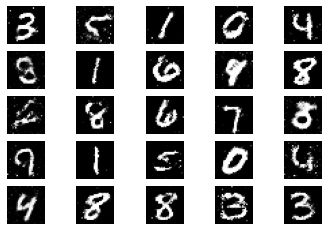

16801 [D loss: 0.705451, acc.: 59.38%] [G loss: 0.834452]
16802 [D loss: 0.640352, acc.: 64.06%] [G loss: 0.857965]
16803 [D loss: 0.683797, acc.: 58.59%] [G loss: 0.853641]
16804 [D loss: 0.694174, acc.: 57.81%] [G loss: 0.860723]
16805 [D loss: 0.653897, acc.: 65.62%] [G loss: 0.884347]
16806 [D loss: 0.609783, acc.: 67.19%] [G loss: 0.933687]
16807 [D loss: 0.617131, acc.: 64.84%] [G loss: 0.880919]
16808 [D loss: 0.646422, acc.: 61.72%] [G loss: 0.896311]
16809 [D loss: 0.624507, acc.: 63.28%] [G loss: 0.904045]
16810 [D loss: 0.651788, acc.: 64.06%] [G loss: 0.972994]
16811 [D loss: 0.662036, acc.: 61.72%] [G loss: 0.857825]
16812 [D loss: 0.677079, acc.: 57.81%] [G loss: 0.912423]
16813 [D loss: 0.660328, acc.: 59.38%] [G loss: 0.911676]
16814 [D loss: 0.703306, acc.: 53.12%] [G loss: 0.946278]
16815 [D loss: 0.657377, acc.: 64.06%] [G loss: 0.850308]
16816 [D loss: 0.702865, acc.: 50.00%] [G loss: 0.874954]
16817 [D loss: 0.616084, acc.: 67.97%] [G loss: 0.934486]
16818 [D loss:

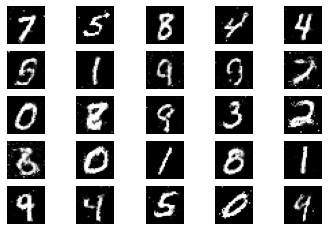

16901 [D loss: 0.693029, acc.: 55.47%] [G loss: 0.925867]
16902 [D loss: 0.636259, acc.: 64.84%] [G loss: 0.906630]
16903 [D loss: 0.708769, acc.: 53.91%] [G loss: 0.960222]
16904 [D loss: 0.659631, acc.: 60.16%] [G loss: 0.883327]
16905 [D loss: 0.644581, acc.: 64.84%] [G loss: 0.844645]
16906 [D loss: 0.658341, acc.: 57.81%] [G loss: 0.903561]
16907 [D loss: 0.621073, acc.: 58.59%] [G loss: 0.873700]
16908 [D loss: 0.656496, acc.: 60.94%] [G loss: 0.836238]
16909 [D loss: 0.649593, acc.: 63.28%] [G loss: 0.885280]
16910 [D loss: 0.714513, acc.: 55.47%] [G loss: 0.900667]
16911 [D loss: 0.630663, acc.: 67.97%] [G loss: 0.863348]
16912 [D loss: 0.678425, acc.: 57.03%] [G loss: 0.845318]
16913 [D loss: 0.668471, acc.: 60.94%] [G loss: 0.871059]
16914 [D loss: 0.639479, acc.: 63.28%] [G loss: 0.895906]
16915 [D loss: 0.661685, acc.: 60.16%] [G loss: 0.960391]
16916 [D loss: 0.614655, acc.: 66.41%] [G loss: 0.912937]
16917 [D loss: 0.666377, acc.: 60.94%] [G loss: 0.931833]
16918 [D loss:

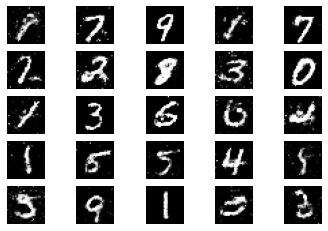

17001 [D loss: 0.651276, acc.: 64.06%] [G loss: 0.957049]
17002 [D loss: 0.668465, acc.: 58.59%] [G loss: 0.937859]
17003 [D loss: 0.684929, acc.: 56.25%] [G loss: 0.921685]
17004 [D loss: 0.651358, acc.: 58.59%] [G loss: 1.001568]
17005 [D loss: 0.689367, acc.: 50.00%] [G loss: 0.927070]
17006 [D loss: 0.647123, acc.: 60.16%] [G loss: 0.933076]
17007 [D loss: 0.637244, acc.: 64.84%] [G loss: 0.927471]
17008 [D loss: 0.686731, acc.: 57.03%] [G loss: 0.936688]
17009 [D loss: 0.633742, acc.: 64.06%] [G loss: 0.926661]
17010 [D loss: 0.615521, acc.: 67.97%] [G loss: 0.928616]
17011 [D loss: 0.680630, acc.: 57.81%] [G loss: 0.880260]
17012 [D loss: 0.641646, acc.: 62.50%] [G loss: 0.906094]
17013 [D loss: 0.699231, acc.: 51.56%] [G loss: 1.002391]
17014 [D loss: 0.632091, acc.: 60.94%] [G loss: 0.889061]
17015 [D loss: 0.663391, acc.: 64.84%] [G loss: 0.881431]
17016 [D loss: 0.659185, acc.: 57.81%] [G loss: 0.904152]
17017 [D loss: 0.681451, acc.: 58.59%] [G loss: 0.858409]
17018 [D loss:

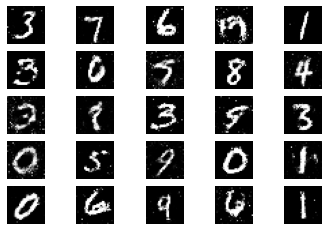

17101 [D loss: 0.673975, acc.: 62.50%] [G loss: 0.964666]
17102 [D loss: 0.632444, acc.: 64.06%] [G loss: 0.968978]
17103 [D loss: 0.679679, acc.: 63.28%] [G loss: 0.871232]
17104 [D loss: 0.588900, acc.: 71.88%] [G loss: 0.896345]
17105 [D loss: 0.637680, acc.: 71.88%] [G loss: 0.837952]
17106 [D loss: 0.664002, acc.: 58.59%] [G loss: 0.931683]
17107 [D loss: 0.644476, acc.: 58.59%] [G loss: 0.918550]
17108 [D loss: 0.659342, acc.: 60.16%] [G loss: 0.893570]
17109 [D loss: 0.639271, acc.: 59.38%] [G loss: 0.957016]
17110 [D loss: 0.642639, acc.: 59.38%] [G loss: 0.988751]
17111 [D loss: 0.685595, acc.: 55.47%] [G loss: 0.920030]
17112 [D loss: 0.646650, acc.: 62.50%] [G loss: 0.831380]
17113 [D loss: 0.633227, acc.: 64.06%] [G loss: 0.900655]
17114 [D loss: 0.662090, acc.: 61.72%] [G loss: 0.882750]
17115 [D loss: 0.636276, acc.: 57.81%] [G loss: 0.878209]
17116 [D loss: 0.610067, acc.: 67.19%] [G loss: 0.902534]
17117 [D loss: 0.671444, acc.: 56.25%] [G loss: 0.866577]
17118 [D loss:

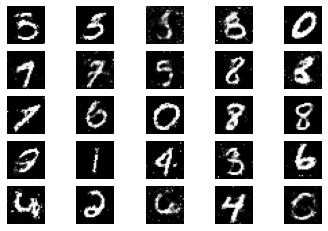

17201 [D loss: 0.681027, acc.: 57.81%] [G loss: 0.958539]
17202 [D loss: 0.648919, acc.: 63.28%] [G loss: 0.933310]
17203 [D loss: 0.640993, acc.: 64.84%] [G loss: 0.962527]
17204 [D loss: 0.681362, acc.: 58.59%] [G loss: 0.900090]
17205 [D loss: 0.644082, acc.: 58.59%] [G loss: 0.926471]
17206 [D loss: 0.635256, acc.: 65.62%] [G loss: 0.919451]
17207 [D loss: 0.655587, acc.: 62.50%] [G loss: 0.874226]
17208 [D loss: 0.677903, acc.: 55.47%] [G loss: 0.826427]
17209 [D loss: 0.669657, acc.: 50.00%] [G loss: 0.920327]
17210 [D loss: 0.624333, acc.: 63.28%] [G loss: 0.943232]
17211 [D loss: 0.658532, acc.: 60.16%] [G loss: 0.891474]
17212 [D loss: 0.655874, acc.: 63.28%] [G loss: 0.928199]
17213 [D loss: 0.632357, acc.: 71.09%] [G loss: 0.898632]
17214 [D loss: 0.669850, acc.: 58.59%] [G loss: 0.924671]
17215 [D loss: 0.644382, acc.: 60.16%] [G loss: 0.893174]
17216 [D loss: 0.642619, acc.: 63.28%] [G loss: 0.900500]
17217 [D loss: 0.668525, acc.: 57.81%] [G loss: 0.882425]
17218 [D loss:

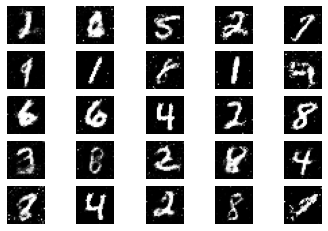

17301 [D loss: 0.684620, acc.: 60.16%] [G loss: 0.915928]
17302 [D loss: 0.637882, acc.: 66.41%] [G loss: 0.863589]
17303 [D loss: 0.652616, acc.: 52.34%] [G loss: 0.893023]
17304 [D loss: 0.718368, acc.: 53.12%] [G loss: 0.871790]
17305 [D loss: 0.644186, acc.: 61.72%] [G loss: 0.876253]
17306 [D loss: 0.638241, acc.: 62.50%] [G loss: 0.870803]
17307 [D loss: 0.602061, acc.: 69.53%] [G loss: 0.872698]
17308 [D loss: 0.623534, acc.: 61.72%] [G loss: 0.831656]
17309 [D loss: 0.670707, acc.: 56.25%] [G loss: 0.832978]
17310 [D loss: 0.691488, acc.: 57.03%] [G loss: 0.804771]
17311 [D loss: 0.682481, acc.: 54.69%] [G loss: 0.847570]
17312 [D loss: 0.634634, acc.: 65.62%] [G loss: 0.966148]
17313 [D loss: 0.598954, acc.: 70.31%] [G loss: 0.943709]
17314 [D loss: 0.652846, acc.: 60.16%] [G loss: 0.864745]
17315 [D loss: 0.701418, acc.: 51.56%] [G loss: 0.911327]
17316 [D loss: 0.692705, acc.: 55.47%] [G loss: 0.918663]
17317 [D loss: 0.636321, acc.: 66.41%] [G loss: 0.930233]
17318 [D loss:

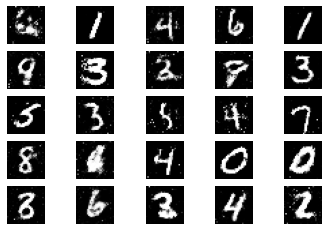

17401 [D loss: 0.685916, acc.: 54.69%] [G loss: 0.866316]
17402 [D loss: 0.628791, acc.: 61.72%] [G loss: 0.917077]
17403 [D loss: 0.686821, acc.: 57.03%] [G loss: 0.931718]
17404 [D loss: 0.691413, acc.: 57.03%] [G loss: 0.949487]
17405 [D loss: 0.646298, acc.: 60.94%] [G loss: 0.912940]
17406 [D loss: 0.656599, acc.: 60.16%] [G loss: 0.903479]
17407 [D loss: 0.663222, acc.: 60.94%] [G loss: 0.915053]
17408 [D loss: 0.652513, acc.: 59.38%] [G loss: 1.014632]
17409 [D loss: 0.644296, acc.: 60.94%] [G loss: 1.010719]
17410 [D loss: 0.738863, acc.: 46.88%] [G loss: 0.867387]
17411 [D loss: 0.666523, acc.: 58.59%] [G loss: 0.894016]
17412 [D loss: 0.661418, acc.: 63.28%] [G loss: 0.894191]
17413 [D loss: 0.658249, acc.: 57.03%] [G loss: 0.863167]
17414 [D loss: 0.630166, acc.: 66.41%] [G loss: 0.905195]
17415 [D loss: 0.636942, acc.: 67.19%] [G loss: 0.898573]
17416 [D loss: 0.618758, acc.: 67.97%] [G loss: 0.876997]
17417 [D loss: 0.657175, acc.: 62.50%] [G loss: 0.895237]
17418 [D loss:

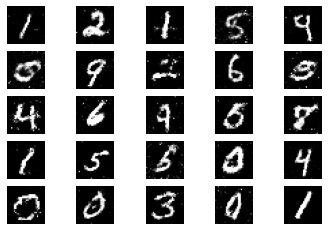

17501 [D loss: 0.648486, acc.: 60.16%] [G loss: 0.908536]
17502 [D loss: 0.597417, acc.: 69.53%] [G loss: 0.960383]
17503 [D loss: 0.631463, acc.: 63.28%] [G loss: 0.915343]
17504 [D loss: 0.643684, acc.: 61.72%] [G loss: 0.928119]
17505 [D loss: 0.675134, acc.: 54.69%] [G loss: 0.885818]
17506 [D loss: 0.654079, acc.: 65.62%] [G loss: 0.847106]
17507 [D loss: 0.682245, acc.: 57.03%] [G loss: 0.851960]
17508 [D loss: 0.633113, acc.: 66.41%] [G loss: 0.867963]
17509 [D loss: 0.667802, acc.: 58.59%] [G loss: 0.869048]
17510 [D loss: 0.688062, acc.: 57.03%] [G loss: 0.898737]
17511 [D loss: 0.635085, acc.: 59.38%] [G loss: 0.861717]
17512 [D loss: 0.630674, acc.: 64.84%] [G loss: 0.939568]
17513 [D loss: 0.677339, acc.: 53.12%] [G loss: 0.872460]
17514 [D loss: 0.603359, acc.: 65.62%] [G loss: 0.918172]
17515 [D loss: 0.680093, acc.: 53.12%] [G loss: 0.917962]
17516 [D loss: 0.671222, acc.: 57.81%] [G loss: 0.919309]
17517 [D loss: 0.664387, acc.: 62.50%] [G loss: 0.889020]
17518 [D loss:

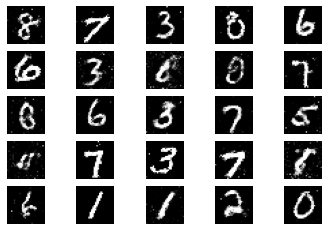

17601 [D loss: 0.637243, acc.: 64.06%] [G loss: 0.877402]
17602 [D loss: 0.682840, acc.: 59.38%] [G loss: 0.898353]
17603 [D loss: 0.649147, acc.: 60.16%] [G loss: 0.881700]
17604 [D loss: 0.685340, acc.: 52.34%] [G loss: 0.945489]
17605 [D loss: 0.647430, acc.: 64.06%] [G loss: 0.943930]
17606 [D loss: 0.670410, acc.: 60.94%] [G loss: 0.927731]
17607 [D loss: 0.634565, acc.: 60.16%] [G loss: 0.938850]
17608 [D loss: 0.625018, acc.: 62.50%] [G loss: 0.947667]
17609 [D loss: 0.678778, acc.: 55.47%] [G loss: 0.997348]
17610 [D loss: 0.630971, acc.: 66.41%] [G loss: 0.983679]
17611 [D loss: 0.652945, acc.: 60.16%] [G loss: 0.960250]
17612 [D loss: 0.636656, acc.: 64.84%] [G loss: 0.916560]
17613 [D loss: 0.652498, acc.: 57.81%] [G loss: 0.983290]
17614 [D loss: 0.668200, acc.: 57.81%] [G loss: 0.951279]
17615 [D loss: 0.641181, acc.: 61.72%] [G loss: 0.941138]
17616 [D loss: 0.659955, acc.: 57.03%] [G loss: 1.016348]
17617 [D loss: 0.645651, acc.: 61.72%] [G loss: 0.869418]
17618 [D loss:

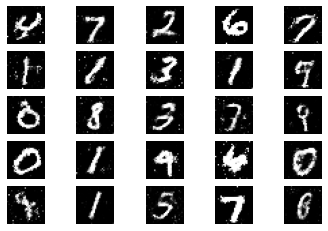

17701 [D loss: 0.681567, acc.: 56.25%] [G loss: 0.887654]
17702 [D loss: 0.628895, acc.: 67.97%] [G loss: 0.902882]
17703 [D loss: 0.626736, acc.: 62.50%] [G loss: 0.900632]
17704 [D loss: 0.671888, acc.: 60.16%] [G loss: 0.907020]
17705 [D loss: 0.651868, acc.: 60.16%] [G loss: 0.917718]
17706 [D loss: 0.616798, acc.: 67.97%] [G loss: 0.960108]
17707 [D loss: 0.598816, acc.: 67.97%] [G loss: 0.946265]
17708 [D loss: 0.673310, acc.: 57.03%] [G loss: 0.900312]
17709 [D loss: 0.655897, acc.: 63.28%] [G loss: 0.870834]
17710 [D loss: 0.676563, acc.: 60.94%] [G loss: 0.915663]
17711 [D loss: 0.669864, acc.: 57.03%] [G loss: 0.907972]
17712 [D loss: 0.637676, acc.: 63.28%] [G loss: 0.884036]
17713 [D loss: 0.640500, acc.: 61.72%] [G loss: 0.869315]
17714 [D loss: 0.658538, acc.: 60.16%] [G loss: 0.921081]
17715 [D loss: 0.654162, acc.: 60.16%] [G loss: 0.950159]
17716 [D loss: 0.725100, acc.: 50.00%] [G loss: 0.891313]
17717 [D loss: 0.654203, acc.: 60.16%] [G loss: 0.848921]
17718 [D loss:

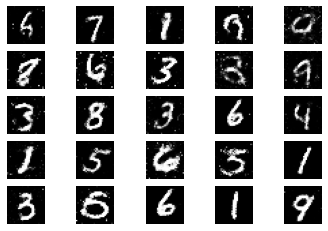

17801 [D loss: 0.631137, acc.: 57.81%] [G loss: 0.859867]
17802 [D loss: 0.642687, acc.: 64.06%] [G loss: 0.935244]
17803 [D loss: 0.671927, acc.: 54.69%] [G loss: 0.918363]
17804 [D loss: 0.661678, acc.: 62.50%] [G loss: 0.854236]
17805 [D loss: 0.650528, acc.: 58.59%] [G loss: 0.833861]
17806 [D loss: 0.670190, acc.: 58.59%] [G loss: 0.906885]
17807 [D loss: 0.663439, acc.: 60.94%] [G loss: 0.901164]
17808 [D loss: 0.658701, acc.: 64.84%] [G loss: 0.961556]
17809 [D loss: 0.634784, acc.: 67.19%] [G loss: 0.940911]
17810 [D loss: 0.663933, acc.: 60.94%] [G loss: 0.930496]
17811 [D loss: 0.634151, acc.: 66.41%] [G loss: 0.881067]
17812 [D loss: 0.624178, acc.: 68.75%] [G loss: 0.869227]
17813 [D loss: 0.662977, acc.: 62.50%] [G loss: 0.933165]
17814 [D loss: 0.682678, acc.: 59.38%] [G loss: 0.911680]
17815 [D loss: 0.619303, acc.: 69.53%] [G loss: 0.882440]
17816 [D loss: 0.594555, acc.: 71.09%] [G loss: 0.911281]
17817 [D loss: 0.612816, acc.: 64.84%] [G loss: 0.924855]
17818 [D loss:

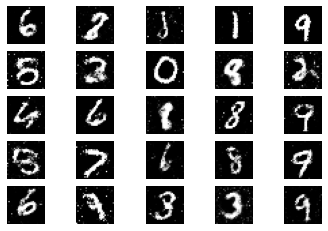

17901 [D loss: 0.662788, acc.: 62.50%] [G loss: 0.868596]
17902 [D loss: 0.642815, acc.: 61.72%] [G loss: 0.925051]
17903 [D loss: 0.650088, acc.: 60.94%] [G loss: 0.865037]
17904 [D loss: 0.654824, acc.: 64.06%] [G loss: 0.907235]
17905 [D loss: 0.665494, acc.: 56.25%] [G loss: 0.933928]
17906 [D loss: 0.674637, acc.: 52.34%] [G loss: 0.942639]
17907 [D loss: 0.662156, acc.: 56.25%] [G loss: 0.953797]
17908 [D loss: 0.668778, acc.: 58.59%] [G loss: 0.863467]
17909 [D loss: 0.609041, acc.: 66.41%] [G loss: 0.894019]
17910 [D loss: 0.636373, acc.: 59.38%] [G loss: 0.941137]
17911 [D loss: 0.641450, acc.: 64.84%] [G loss: 0.902031]
17912 [D loss: 0.638811, acc.: 60.16%] [G loss: 0.842765]
17913 [D loss: 0.667473, acc.: 57.81%] [G loss: 0.904932]
17914 [D loss: 0.638306, acc.: 63.28%] [G loss: 0.876439]
17915 [D loss: 0.638084, acc.: 62.50%] [G loss: 0.899298]
17916 [D loss: 0.630931, acc.: 67.19%] [G loss: 0.870457]
17917 [D loss: 0.649903, acc.: 60.94%] [G loss: 0.875933]
17918 [D loss:

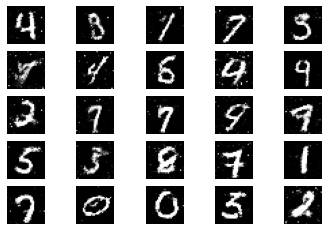

18001 [D loss: 0.665589, acc.: 64.84%] [G loss: 0.888801]
18002 [D loss: 0.666510, acc.: 57.81%] [G loss: 0.918524]
18003 [D loss: 0.645382, acc.: 61.72%] [G loss: 0.916220]
18004 [D loss: 0.626201, acc.: 61.72%] [G loss: 0.911403]
18005 [D loss: 0.639727, acc.: 60.94%] [G loss: 0.918466]
18006 [D loss: 0.673838, acc.: 52.34%] [G loss: 0.966281]
18007 [D loss: 0.667470, acc.: 60.94%] [G loss: 0.858798]
18008 [D loss: 0.644226, acc.: 64.06%] [G loss: 0.883487]
18009 [D loss: 0.645308, acc.: 59.38%] [G loss: 0.935501]
18010 [D loss: 0.639044, acc.: 64.84%] [G loss: 0.940257]
18011 [D loss: 0.650308, acc.: 54.69%] [G loss: 0.879647]
18012 [D loss: 0.679518, acc.: 60.16%] [G loss: 0.940542]
18013 [D loss: 0.653197, acc.: 62.50%] [G loss: 0.975735]
18014 [D loss: 0.681697, acc.: 56.25%] [G loss: 0.908983]
18015 [D loss: 0.634420, acc.: 63.28%] [G loss: 0.969038]
18016 [D loss: 0.629689, acc.: 64.06%] [G loss: 0.905942]
18017 [D loss: 0.616828, acc.: 66.41%] [G loss: 0.927906]
18018 [D loss:

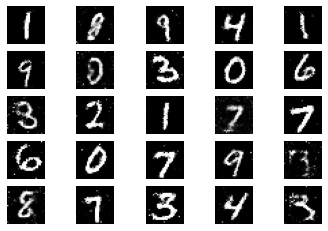

18101 [D loss: 0.633977, acc.: 60.94%] [G loss: 0.881338]
18102 [D loss: 0.629625, acc.: 67.19%] [G loss: 0.967959]
18103 [D loss: 0.664836, acc.: 60.16%] [G loss: 0.919523]
18104 [D loss: 0.693406, acc.: 58.59%] [G loss: 0.923695]
18105 [D loss: 0.620344, acc.: 63.28%] [G loss: 0.957396]
18106 [D loss: 0.643539, acc.: 68.75%] [G loss: 0.890043]
18107 [D loss: 0.630847, acc.: 62.50%] [G loss: 0.911553]
18108 [D loss: 0.689695, acc.: 54.69%] [G loss: 0.988811]
18109 [D loss: 0.660678, acc.: 57.03%] [G loss: 0.927752]
18110 [D loss: 0.710836, acc.: 50.78%] [G loss: 0.934132]
18111 [D loss: 0.690931, acc.: 60.94%] [G loss: 0.866077]
18112 [D loss: 0.675294, acc.: 62.50%] [G loss: 0.894046]
18113 [D loss: 0.662819, acc.: 62.50%] [G loss: 0.878985]
18114 [D loss: 0.653685, acc.: 62.50%] [G loss: 0.833022]
18115 [D loss: 0.666585, acc.: 59.38%] [G loss: 0.879562]
18116 [D loss: 0.710448, acc.: 54.69%] [G loss: 0.907278]
18117 [D loss: 0.632139, acc.: 64.84%] [G loss: 0.925871]
18118 [D loss:

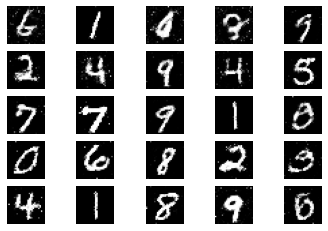

18201 [D loss: 0.667711, acc.: 57.81%] [G loss: 0.944411]
18202 [D loss: 0.683644, acc.: 61.72%] [G loss: 0.924264]
18203 [D loss: 0.617292, acc.: 67.19%] [G loss: 0.952523]
18204 [D loss: 0.685518, acc.: 54.69%] [G loss: 0.890021]
18205 [D loss: 0.663921, acc.: 58.59%] [G loss: 0.830902]
18206 [D loss: 0.695887, acc.: 58.59%] [G loss: 0.899889]
18207 [D loss: 0.637528, acc.: 64.06%] [G loss: 0.927747]
18208 [D loss: 0.627382, acc.: 64.84%] [G loss: 0.862834]
18209 [D loss: 0.689987, acc.: 57.03%] [G loss: 0.911015]
18210 [D loss: 0.673755, acc.: 57.81%] [G loss: 0.863320]
18211 [D loss: 0.653730, acc.: 59.38%] [G loss: 0.867246]
18212 [D loss: 0.646322, acc.: 63.28%] [G loss: 0.900944]
18213 [D loss: 0.635328, acc.: 62.50%] [G loss: 0.976824]
18214 [D loss: 0.627393, acc.: 61.72%] [G loss: 0.916860]
18215 [D loss: 0.674238, acc.: 58.59%] [G loss: 0.899598]
18216 [D loss: 0.587406, acc.: 71.88%] [G loss: 0.956354]
18217 [D loss: 0.614333, acc.: 62.50%] [G loss: 0.993356]
18218 [D loss:

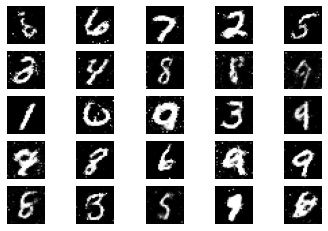

18301 [D loss: 0.611138, acc.: 67.19%] [G loss: 0.943430]
18302 [D loss: 0.642043, acc.: 62.50%] [G loss: 0.950588]
18303 [D loss: 0.625350, acc.: 62.50%] [G loss: 0.921834]
18304 [D loss: 0.688880, acc.: 54.69%] [G loss: 0.887256]
18305 [D loss: 0.670496, acc.: 60.94%] [G loss: 0.883794]
18306 [D loss: 0.654148, acc.: 69.53%] [G loss: 0.970895]
18307 [D loss: 0.629262, acc.: 66.41%] [G loss: 0.932184]
18308 [D loss: 0.685391, acc.: 57.03%] [G loss: 0.914834]
18309 [D loss: 0.672108, acc.: 58.59%] [G loss: 0.788816]
18310 [D loss: 0.627706, acc.: 67.19%] [G loss: 0.907657]
18311 [D loss: 0.651989, acc.: 63.28%] [G loss: 0.924097]
18312 [D loss: 0.702372, acc.: 50.00%] [G loss: 0.882342]
18313 [D loss: 0.657637, acc.: 60.94%] [G loss: 0.876847]
18314 [D loss: 0.632110, acc.: 61.72%] [G loss: 0.846745]
18315 [D loss: 0.656965, acc.: 58.59%] [G loss: 0.881325]
18316 [D loss: 0.649129, acc.: 64.84%] [G loss: 0.852740]
18317 [D loss: 0.691802, acc.: 53.91%] [G loss: 0.890777]
18318 [D loss:

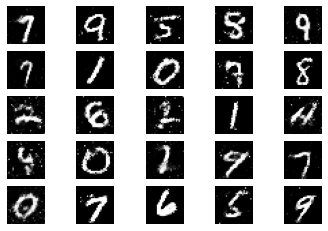

18401 [D loss: 0.648851, acc.: 66.41%] [G loss: 0.967975]
18402 [D loss: 0.687979, acc.: 52.34%] [G loss: 0.897414]
18403 [D loss: 0.648827, acc.: 62.50%] [G loss: 0.864078]
18404 [D loss: 0.673779, acc.: 57.81%] [G loss: 0.922700]
18405 [D loss: 0.666967, acc.: 59.38%] [G loss: 0.904984]
18406 [D loss: 0.671760, acc.: 57.81%] [G loss: 0.890384]
18407 [D loss: 0.614385, acc.: 65.62%] [G loss: 0.921005]
18408 [D loss: 0.671112, acc.: 60.94%] [G loss: 0.905251]
18409 [D loss: 0.723095, acc.: 47.66%] [G loss: 0.887597]
18410 [D loss: 0.668602, acc.: 60.16%] [G loss: 0.860860]
18411 [D loss: 0.641712, acc.: 64.06%] [G loss: 0.901097]
18412 [D loss: 0.625891, acc.: 63.28%] [G loss: 1.013783]
18413 [D loss: 0.700217, acc.: 56.25%] [G loss: 0.951409]
18414 [D loss: 0.674522, acc.: 54.69%] [G loss: 0.918889]
18415 [D loss: 0.654915, acc.: 58.59%] [G loss: 0.928038]
18416 [D loss: 0.676498, acc.: 53.91%] [G loss: 0.913996]
18417 [D loss: 0.628015, acc.: 64.84%] [G loss: 0.945721]
18418 [D loss:

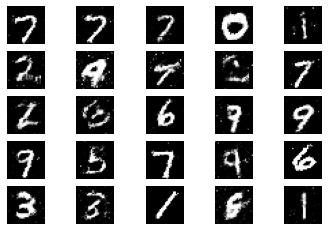

18501 [D loss: 0.645767, acc.: 59.38%] [G loss: 0.914840]
18502 [D loss: 0.668051, acc.: 59.38%] [G loss: 0.905743]
18503 [D loss: 0.646037, acc.: 64.06%] [G loss: 0.923291]
18504 [D loss: 0.619313, acc.: 63.28%] [G loss: 0.915569]
18505 [D loss: 0.633229, acc.: 67.19%] [G loss: 0.889984]
18506 [D loss: 0.652526, acc.: 58.59%] [G loss: 0.954547]
18507 [D loss: 0.645496, acc.: 65.62%] [G loss: 0.903912]
18508 [D loss: 0.652626, acc.: 59.38%] [G loss: 0.882915]
18509 [D loss: 0.729948, acc.: 54.69%] [G loss: 0.900966]
18510 [D loss: 0.653167, acc.: 59.38%] [G loss: 0.897532]
18511 [D loss: 0.666766, acc.: 60.94%] [G loss: 0.897733]
18512 [D loss: 0.650972, acc.: 64.06%] [G loss: 0.865129]
18513 [D loss: 0.653504, acc.: 61.72%] [G loss: 0.865104]
18514 [D loss: 0.661347, acc.: 60.16%] [G loss: 0.855105]
18515 [D loss: 0.647236, acc.: 65.62%] [G loss: 0.866289]
18516 [D loss: 0.650032, acc.: 67.97%] [G loss: 0.949571]
18517 [D loss: 0.635078, acc.: 61.72%] [G loss: 0.872809]
18518 [D loss:

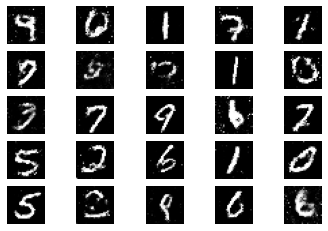

18601 [D loss: 0.666214, acc.: 65.62%] [G loss: 0.951650]
18602 [D loss: 0.625991, acc.: 62.50%] [G loss: 0.928251]
18603 [D loss: 0.637824, acc.: 60.16%] [G loss: 0.997394]
18604 [D loss: 0.679818, acc.: 57.81%] [G loss: 0.940232]
18605 [D loss: 0.677016, acc.: 63.28%] [G loss: 0.874953]
18606 [D loss: 0.630106, acc.: 70.31%] [G loss: 0.866601]
18607 [D loss: 0.617122, acc.: 62.50%] [G loss: 0.927664]
18608 [D loss: 0.658045, acc.: 64.06%] [G loss: 0.914467]
18609 [D loss: 0.614642, acc.: 65.62%] [G loss: 0.886017]
18610 [D loss: 0.662639, acc.: 55.47%] [G loss: 0.893883]
18611 [D loss: 0.647009, acc.: 64.84%] [G loss: 0.933530]
18612 [D loss: 0.681324, acc.: 62.50%] [G loss: 0.858816]
18613 [D loss: 0.623481, acc.: 69.53%] [G loss: 0.907083]
18614 [D loss: 0.689144, acc.: 50.00%] [G loss: 0.930652]
18615 [D loss: 0.617206, acc.: 60.94%] [G loss: 0.866210]
18616 [D loss: 0.618432, acc.: 63.28%] [G loss: 0.894179]
18617 [D loss: 0.624691, acc.: 64.84%] [G loss: 0.931200]
18618 [D loss:

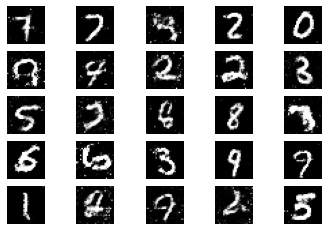

18701 [D loss: 0.641931, acc.: 62.50%] [G loss: 0.921332]
18702 [D loss: 0.623905, acc.: 71.09%] [G loss: 0.889173]
18703 [D loss: 0.715918, acc.: 53.12%] [G loss: 0.834890]
18704 [D loss: 0.652334, acc.: 57.03%] [G loss: 0.955270]
18705 [D loss: 0.643723, acc.: 62.50%] [G loss: 0.937003]
18706 [D loss: 0.665932, acc.: 57.81%] [G loss: 0.969677]
18707 [D loss: 0.626697, acc.: 65.62%] [G loss: 0.963546]
18708 [D loss: 0.682673, acc.: 59.38%] [G loss: 0.911020]
18709 [D loss: 0.643431, acc.: 63.28%] [G loss: 0.880287]
18710 [D loss: 0.620587, acc.: 64.84%] [G loss: 0.862604]
18711 [D loss: 0.663756, acc.: 53.91%] [G loss: 0.896283]
18712 [D loss: 0.724557, acc.: 49.22%] [G loss: 0.913915]
18713 [D loss: 0.624222, acc.: 67.19%] [G loss: 0.944262]
18714 [D loss: 0.611792, acc.: 71.09%] [G loss: 0.888641]
18715 [D loss: 0.644389, acc.: 64.06%] [G loss: 0.916977]
18716 [D loss: 0.686264, acc.: 55.47%] [G loss: 0.936085]
18717 [D loss: 0.618384, acc.: 60.16%] [G loss: 0.940494]
18718 [D loss:

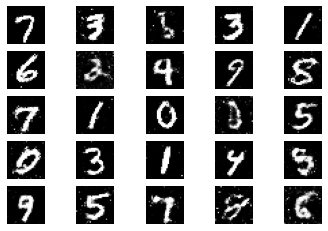

18801 [D loss: 0.689390, acc.: 54.69%] [G loss: 0.845607]
18802 [D loss: 0.639220, acc.: 60.16%] [G loss: 0.894483]
18803 [D loss: 0.644507, acc.: 65.62%] [G loss: 0.944753]
18804 [D loss: 0.642300, acc.: 62.50%] [G loss: 0.885619]
18805 [D loss: 0.643396, acc.: 58.59%] [G loss: 0.928606]
18806 [D loss: 0.650432, acc.: 62.50%] [G loss: 0.848426]
18807 [D loss: 0.672268, acc.: 56.25%] [G loss: 0.901853]
18808 [D loss: 0.661736, acc.: 60.94%] [G loss: 0.952358]
18809 [D loss: 0.601142, acc.: 70.31%] [G loss: 0.849902]
18810 [D loss: 0.681829, acc.: 57.03%] [G loss: 0.861287]
18811 [D loss: 0.623767, acc.: 66.41%] [G loss: 0.861992]
18812 [D loss: 0.651077, acc.: 58.59%] [G loss: 0.852291]
18813 [D loss: 0.652267, acc.: 63.28%] [G loss: 0.883519]
18814 [D loss: 0.606481, acc.: 69.53%] [G loss: 0.858175]
18815 [D loss: 0.645114, acc.: 65.62%] [G loss: 0.843622]
18816 [D loss: 0.674548, acc.: 58.59%] [G loss: 0.900511]
18817 [D loss: 0.635309, acc.: 57.81%] [G loss: 0.873782]
18818 [D loss:

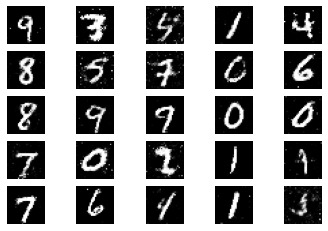

18901 [D loss: 0.663094, acc.: 64.06%] [G loss: 0.886116]
18902 [D loss: 0.644997, acc.: 57.03%] [G loss: 0.887436]
18903 [D loss: 0.621697, acc.: 63.28%] [G loss: 0.873465]
18904 [D loss: 0.652366, acc.: 59.38%] [G loss: 0.916742]
18905 [D loss: 0.643102, acc.: 61.72%] [G loss: 0.938892]
18906 [D loss: 0.680637, acc.: 54.69%] [G loss: 0.937346]
18907 [D loss: 0.636993, acc.: 58.59%] [G loss: 0.939285]
18908 [D loss: 0.616215, acc.: 64.84%] [G loss: 0.951541]
18909 [D loss: 0.674225, acc.: 61.72%] [G loss: 0.911039]
18910 [D loss: 0.697665, acc.: 52.34%] [G loss: 0.844873]
18911 [D loss: 0.642523, acc.: 63.28%] [G loss: 0.960075]
18912 [D loss: 0.688596, acc.: 57.03%] [G loss: 0.872275]
18913 [D loss: 0.673600, acc.: 59.38%] [G loss: 0.926785]
18914 [D loss: 0.627305, acc.: 63.28%] [G loss: 0.878274]
18915 [D loss: 0.645062, acc.: 64.84%] [G loss: 0.882851]
18916 [D loss: 0.629934, acc.: 60.94%] [G loss: 0.928496]
18917 [D loss: 0.659723, acc.: 57.81%] [G loss: 0.950176]
18918 [D loss:

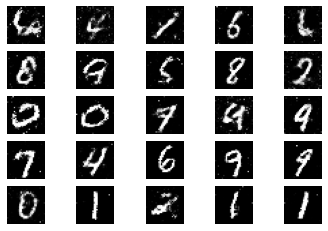

19001 [D loss: 0.705254, acc.: 54.69%] [G loss: 0.864822]
19002 [D loss: 0.675174, acc.: 58.59%] [G loss: 0.955615]
19003 [D loss: 0.629990, acc.: 68.75%] [G loss: 0.912847]
19004 [D loss: 0.623550, acc.: 63.28%] [G loss: 0.936591]
19005 [D loss: 0.648721, acc.: 63.28%] [G loss: 0.880812]
19006 [D loss: 0.679251, acc.: 59.38%] [G loss: 0.969646]
19007 [D loss: 0.640250, acc.: 65.62%] [G loss: 0.952270]
19008 [D loss: 0.632042, acc.: 64.06%] [G loss: 0.869930]
19009 [D loss: 0.672743, acc.: 58.59%] [G loss: 0.920527]
19010 [D loss: 0.685252, acc.: 56.25%] [G loss: 0.841404]
19011 [D loss: 0.681255, acc.: 55.47%] [G loss: 0.904898]
19012 [D loss: 0.600520, acc.: 68.75%] [G loss: 0.921200]
19013 [D loss: 0.648727, acc.: 62.50%] [G loss: 0.945717]
19014 [D loss: 0.651263, acc.: 60.16%] [G loss: 0.907862]
19015 [D loss: 0.597213, acc.: 67.19%] [G loss: 0.946581]
19016 [D loss: 0.671066, acc.: 57.03%] [G loss: 0.891971]
19017 [D loss: 0.639909, acc.: 61.72%] [G loss: 0.867017]
19018 [D loss:

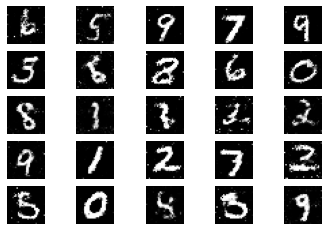

19101 [D loss: 0.650233, acc.: 62.50%] [G loss: 0.908580]
19102 [D loss: 0.661381, acc.: 53.91%] [G loss: 0.974716]
19103 [D loss: 0.658284, acc.: 63.28%] [G loss: 0.891572]
19104 [D loss: 0.652803, acc.: 63.28%] [G loss: 0.936092]
19105 [D loss: 0.646448, acc.: 60.94%] [G loss: 0.942173]
19106 [D loss: 0.671244, acc.: 60.94%] [G loss: 0.965909]
19107 [D loss: 0.662032, acc.: 62.50%] [G loss: 0.902792]
19108 [D loss: 0.657254, acc.: 62.50%] [G loss: 0.889038]
19109 [D loss: 0.669070, acc.: 60.94%] [G loss: 0.894275]
19110 [D loss: 0.665815, acc.: 57.81%] [G loss: 0.932838]
19111 [D loss: 0.675132, acc.: 55.47%] [G loss: 0.922120]
19112 [D loss: 0.676675, acc.: 58.59%] [G loss: 0.889823]
19113 [D loss: 0.684731, acc.: 56.25%] [G loss: 0.938934]
19114 [D loss: 0.664240, acc.: 57.03%] [G loss: 0.927118]
19115 [D loss: 0.638938, acc.: 62.50%] [G loss: 0.932059]
19116 [D loss: 0.667619, acc.: 54.69%] [G loss: 0.898723]
19117 [D loss: 0.664668, acc.: 57.03%] [G loss: 0.916847]
19118 [D loss:

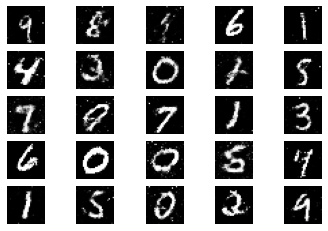

19201 [D loss: 0.647045, acc.: 61.72%] [G loss: 0.933016]
19202 [D loss: 0.643618, acc.: 66.41%] [G loss: 0.928455]
19203 [D loss: 0.612912, acc.: 65.62%] [G loss: 0.926796]
19204 [D loss: 0.702309, acc.: 53.91%] [G loss: 0.936897]
19205 [D loss: 0.661064, acc.: 58.59%] [G loss: 0.873924]
19206 [D loss: 0.664539, acc.: 56.25%] [G loss: 0.919500]
19207 [D loss: 0.715340, acc.: 53.91%] [G loss: 0.910209]
19208 [D loss: 0.653214, acc.: 57.03%] [G loss: 0.950561]
19209 [D loss: 0.673355, acc.: 54.69%] [G loss: 0.868846]
19210 [D loss: 0.661562, acc.: 58.59%] [G loss: 0.928516]
19211 [D loss: 0.638431, acc.: 64.84%] [G loss: 0.901071]
19212 [D loss: 0.662196, acc.: 60.16%] [G loss: 0.870609]
19213 [D loss: 0.655631, acc.: 58.59%] [G loss: 0.888512]
19214 [D loss: 0.670263, acc.: 60.16%] [G loss: 0.896856]
19215 [D loss: 0.667797, acc.: 56.25%] [G loss: 0.908275]
19216 [D loss: 0.627136, acc.: 66.41%] [G loss: 0.963241]
19217 [D loss: 0.651857, acc.: 57.81%] [G loss: 0.844441]
19218 [D loss:

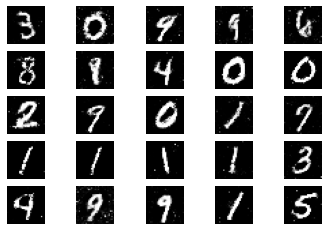

19301 [D loss: 0.619653, acc.: 62.50%] [G loss: 0.941765]
19302 [D loss: 0.650182, acc.: 61.72%] [G loss: 0.894619]
19303 [D loss: 0.675329, acc.: 52.34%] [G loss: 0.915276]
19304 [D loss: 0.654142, acc.: 57.81%] [G loss: 0.950776]
19305 [D loss: 0.617717, acc.: 62.50%] [G loss: 0.905919]
19306 [D loss: 0.702777, acc.: 50.78%] [G loss: 0.887058]
19307 [D loss: 0.640139, acc.: 58.59%] [G loss: 0.879231]
19308 [D loss: 0.642430, acc.: 62.50%] [G loss: 0.985600]
19309 [D loss: 0.671859, acc.: 53.12%] [G loss: 0.930636]
19310 [D loss: 0.675544, acc.: 53.91%] [G loss: 0.958208]
19311 [D loss: 0.590474, acc.: 71.88%] [G loss: 0.988986]
19312 [D loss: 0.643445, acc.: 63.28%] [G loss: 0.955309]
19313 [D loss: 0.707341, acc.: 53.91%] [G loss: 0.932224]
19314 [D loss: 0.625335, acc.: 64.84%] [G loss: 0.838770]
19315 [D loss: 0.646806, acc.: 61.72%] [G loss: 0.922813]
19316 [D loss: 0.661541, acc.: 54.69%] [G loss: 0.856985]
19317 [D loss: 0.609542, acc.: 63.28%] [G loss: 0.897339]
19318 [D loss:

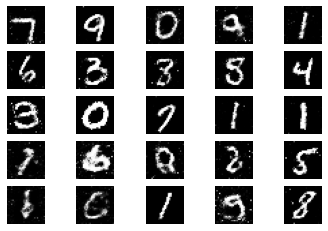

19401 [D loss: 0.683344, acc.: 57.03%] [G loss: 0.874052]
19402 [D loss: 0.668278, acc.: 57.81%] [G loss: 0.883825]
19403 [D loss: 0.673473, acc.: 52.34%] [G loss: 0.900093]
19404 [D loss: 0.615370, acc.: 65.62%] [G loss: 0.905083]
19405 [D loss: 0.623341, acc.: 60.94%] [G loss: 0.895808]
19406 [D loss: 0.693049, acc.: 56.25%] [G loss: 0.847670]
19407 [D loss: 0.689116, acc.: 53.12%] [G loss: 0.876587]
19408 [D loss: 0.656097, acc.: 60.16%] [G loss: 0.872049]
19409 [D loss: 0.667234, acc.: 57.81%] [G loss: 0.903568]
19410 [D loss: 0.637047, acc.: 59.38%] [G loss: 0.928883]
19411 [D loss: 0.608233, acc.: 71.09%] [G loss: 0.938514]
19412 [D loss: 0.645222, acc.: 65.62%] [G loss: 0.903905]
19413 [D loss: 0.647778, acc.: 62.50%] [G loss: 0.899288]
19414 [D loss: 0.645343, acc.: 60.94%] [G loss: 0.890355]
19415 [D loss: 0.663801, acc.: 59.38%] [G loss: 0.932508]
19416 [D loss: 0.659124, acc.: 60.16%] [G loss: 1.023514]
19417 [D loss: 0.646849, acc.: 65.62%] [G loss: 0.881486]
19418 [D loss:

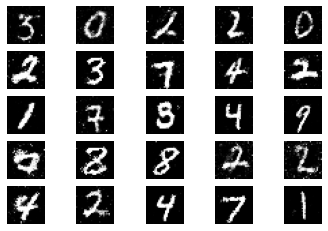

19501 [D loss: 0.618683, acc.: 64.06%] [G loss: 0.964218]
19502 [D loss: 0.661221, acc.: 60.94%] [G loss: 0.898709]
19503 [D loss: 0.640803, acc.: 62.50%] [G loss: 0.917780]
19504 [D loss: 0.660724, acc.: 63.28%] [G loss: 0.876531]
19505 [D loss: 0.662864, acc.: 58.59%] [G loss: 0.958412]
19506 [D loss: 0.626999, acc.: 64.84%] [G loss: 0.906737]
19507 [D loss: 0.637887, acc.: 65.62%] [G loss: 0.975600]
19508 [D loss: 0.702980, acc.: 51.56%] [G loss: 0.937420]
19509 [D loss: 0.627581, acc.: 64.06%] [G loss: 0.932881]
19510 [D loss: 0.629091, acc.: 64.06%] [G loss: 0.978191]
19511 [D loss: 0.701843, acc.: 52.34%] [G loss: 0.963621]
19512 [D loss: 0.623744, acc.: 64.06%] [G loss: 0.952221]
19513 [D loss: 0.654910, acc.: 54.69%] [G loss: 0.910629]
19514 [D loss: 0.671385, acc.: 54.69%] [G loss: 0.899732]
19515 [D loss: 0.657584, acc.: 60.16%] [G loss: 0.922291]
19516 [D loss: 0.643406, acc.: 63.28%] [G loss: 0.936979]
19517 [D loss: 0.650397, acc.: 60.94%] [G loss: 0.928749]
19518 [D loss:

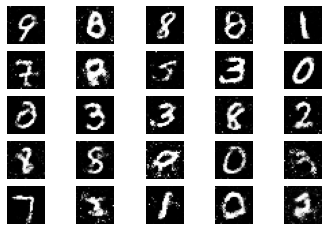

19601 [D loss: 0.702432, acc.: 53.91%] [G loss: 0.934004]
19602 [D loss: 0.635174, acc.: 64.84%] [G loss: 0.903954]
19603 [D loss: 0.651807, acc.: 61.72%] [G loss: 0.924935]
19604 [D loss: 0.681142, acc.: 53.91%] [G loss: 0.968920]
19605 [D loss: 0.612576, acc.: 68.75%] [G loss: 0.918268]
19606 [D loss: 0.668539, acc.: 57.03%] [G loss: 0.914412]
19607 [D loss: 0.654288, acc.: 60.16%] [G loss: 0.984885]
19608 [D loss: 0.663058, acc.: 64.84%] [G loss: 0.962467]
19609 [D loss: 0.641583, acc.: 60.94%] [G loss: 0.978251]
19610 [D loss: 0.605841, acc.: 69.53%] [G loss: 0.951978]
19611 [D loss: 0.617311, acc.: 71.09%] [G loss: 0.935040]
19612 [D loss: 0.678553, acc.: 56.25%] [G loss: 0.840486]
19613 [D loss: 0.606434, acc.: 63.28%] [G loss: 0.957947]
19614 [D loss: 0.680121, acc.: 54.69%] [G loss: 0.922416]
19615 [D loss: 0.627605, acc.: 62.50%] [G loss: 0.936058]
19616 [D loss: 0.602640, acc.: 70.31%] [G loss: 0.830705]
19617 [D loss: 0.676347, acc.: 59.38%] [G loss: 0.925205]
19618 [D loss:

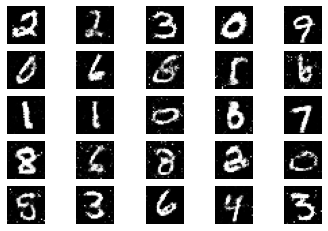

19701 [D loss: 0.626443, acc.: 62.50%] [G loss: 0.890378]
19702 [D loss: 0.640172, acc.: 62.50%] [G loss: 0.910918]
19703 [D loss: 0.603326, acc.: 63.28%] [G loss: 0.883642]
19704 [D loss: 0.661999, acc.: 66.41%] [G loss: 0.956945]
19705 [D loss: 0.686125, acc.: 55.47%] [G loss: 0.854634]
19706 [D loss: 0.739144, acc.: 49.22%] [G loss: 0.889627]
19707 [D loss: 0.689487, acc.: 59.38%] [G loss: 0.900548]
19708 [D loss: 0.636588, acc.: 63.28%] [G loss: 0.917054]
19709 [D loss: 0.641264, acc.: 60.94%] [G loss: 0.873571]
19710 [D loss: 0.691616, acc.: 59.38%] [G loss: 0.903582]
19711 [D loss: 0.644469, acc.: 62.50%] [G loss: 0.909263]
19712 [D loss: 0.666117, acc.: 64.84%] [G loss: 0.891936]
19713 [D loss: 0.671509, acc.: 54.69%] [G loss: 0.908672]
19714 [D loss: 0.641323, acc.: 62.50%] [G loss: 0.861016]
19715 [D loss: 0.655862, acc.: 61.72%] [G loss: 0.877709]
19716 [D loss: 0.657873, acc.: 61.72%] [G loss: 0.901046]
19717 [D loss: 0.672983, acc.: 57.81%] [G loss: 0.924720]
19718 [D loss:

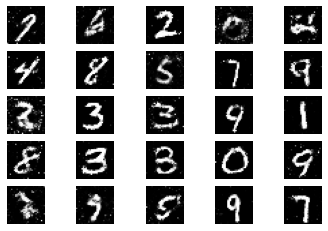

19801 [D loss: 0.672763, acc.: 64.06%] [G loss: 0.953763]
19802 [D loss: 0.664252, acc.: 57.81%] [G loss: 0.957497]
19803 [D loss: 0.661846, acc.: 61.72%] [G loss: 0.921131]
19804 [D loss: 0.667939, acc.: 54.69%] [G loss: 0.888810]
19805 [D loss: 0.639788, acc.: 67.19%] [G loss: 0.929575]
19806 [D loss: 0.658200, acc.: 61.72%] [G loss: 0.868076]
19807 [D loss: 0.666725, acc.: 58.59%] [G loss: 0.885587]
19808 [D loss: 0.660611, acc.: 61.72%] [G loss: 0.862519]
19809 [D loss: 0.649715, acc.: 64.06%] [G loss: 0.885991]
19810 [D loss: 0.636924, acc.: 64.06%] [G loss: 0.887936]
19811 [D loss: 0.630436, acc.: 64.84%] [G loss: 0.916807]
19812 [D loss: 0.615505, acc.: 65.62%] [G loss: 0.861503]
19813 [D loss: 0.653438, acc.: 60.16%] [G loss: 0.913406]
19814 [D loss: 0.708691, acc.: 51.56%] [G loss: 0.830008]
19815 [D loss: 0.636700, acc.: 64.06%] [G loss: 0.882960]
19816 [D loss: 0.647309, acc.: 66.41%] [G loss: 0.866482]
19817 [D loss: 0.623586, acc.: 61.72%] [G loss: 0.852620]
19818 [D loss:

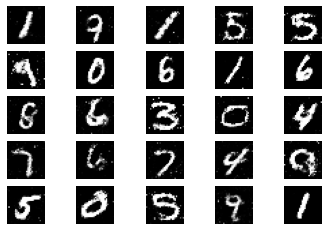

19901 [D loss: 0.668842, acc.: 60.94%] [G loss: 0.919924]
19902 [D loss: 0.693387, acc.: 57.03%] [G loss: 0.883692]
19903 [D loss: 0.599031, acc.: 67.19%] [G loss: 0.925344]
19904 [D loss: 0.617620, acc.: 66.41%] [G loss: 0.887874]
19905 [D loss: 0.683727, acc.: 55.47%] [G loss: 0.877175]
19906 [D loss: 0.650121, acc.: 59.38%] [G loss: 0.891055]
19907 [D loss: 0.660317, acc.: 56.25%] [G loss: 0.913483]
19908 [D loss: 0.653394, acc.: 64.84%] [G loss: 0.867096]
19909 [D loss: 0.667637, acc.: 60.16%] [G loss: 0.902862]
19910 [D loss: 0.648557, acc.: 64.84%] [G loss: 0.917199]
19911 [D loss: 0.692251, acc.: 53.91%] [G loss: 0.880811]
19912 [D loss: 0.620057, acc.: 64.84%] [G loss: 0.869220]
19913 [D loss: 0.661737, acc.: 61.72%] [G loss: 0.898685]
19914 [D loss: 0.648467, acc.: 58.59%] [G loss: 1.014770]
19915 [D loss: 0.662659, acc.: 59.38%] [G loss: 0.984788]
19916 [D loss: 0.629711, acc.: 64.06%] [G loss: 0.894980]
19917 [D loss: 0.664871, acc.: 60.94%] [G loss: 0.939582]
19918 [D loss:

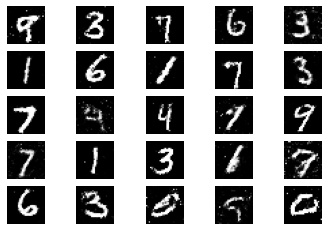

20001 [D loss: 0.631806, acc.: 65.62%] [G loss: 0.981121]
20002 [D loss: 0.622638, acc.: 62.50%] [G loss: 0.955606]
20003 [D loss: 0.662154, acc.: 57.81%] [G loss: 0.927953]
20004 [D loss: 0.634672, acc.: 64.84%] [G loss: 0.925367]
20005 [D loss: 0.657260, acc.: 58.59%] [G loss: 0.901588]
20006 [D loss: 0.655676, acc.: 60.94%] [G loss: 0.917890]
20007 [D loss: 0.646489, acc.: 61.72%] [G loss: 0.896829]
20008 [D loss: 0.678764, acc.: 58.59%] [G loss: 0.929565]
20009 [D loss: 0.669917, acc.: 60.16%] [G loss: 0.958329]
20010 [D loss: 0.649255, acc.: 57.81%] [G loss: 0.932809]
20011 [D loss: 0.690970, acc.: 51.56%] [G loss: 0.941556]
20012 [D loss: 0.688362, acc.: 51.56%] [G loss: 0.982034]
20013 [D loss: 0.644943, acc.: 59.38%] [G loss: 0.886854]
20014 [D loss: 0.628011, acc.: 62.50%] [G loss: 0.942092]
20015 [D loss: 0.636280, acc.: 61.72%] [G loss: 0.857741]
20016 [D loss: 0.674324, acc.: 57.03%] [G loss: 0.859849]
20017 [D loss: 0.641494, acc.: 60.16%] [G loss: 0.845430]
20018 [D loss:

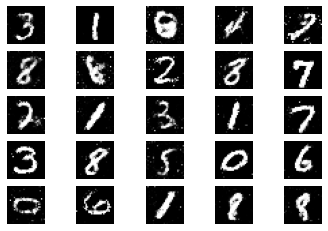

20101 [D loss: 0.638235, acc.: 63.28%] [G loss: 0.945670]
20102 [D loss: 0.652252, acc.: 55.47%] [G loss: 1.006208]
20103 [D loss: 0.643091, acc.: 61.72%] [G loss: 0.923260]
20104 [D loss: 0.653241, acc.: 58.59%] [G loss: 0.965265]
20105 [D loss: 0.621661, acc.: 66.41%] [G loss: 0.945250]
20106 [D loss: 0.661734, acc.: 59.38%] [G loss: 0.946371]
20107 [D loss: 0.648321, acc.: 58.59%] [G loss: 0.952302]
20108 [D loss: 0.633324, acc.: 64.06%] [G loss: 0.964483]
20109 [D loss: 0.620606, acc.: 67.97%] [G loss: 0.883003]
20110 [D loss: 0.624792, acc.: 64.84%] [G loss: 0.914191]
20111 [D loss: 0.648489, acc.: 62.50%] [G loss: 0.893441]
20112 [D loss: 0.710005, acc.: 51.56%] [G loss: 0.821579]
20113 [D loss: 0.638230, acc.: 64.06%] [G loss: 0.875892]
20114 [D loss: 0.638379, acc.: 63.28%] [G loss: 0.956138]
20115 [D loss: 0.672230, acc.: 60.16%] [G loss: 0.890512]
20116 [D loss: 0.679927, acc.: 58.59%] [G loss: 0.914953]
20117 [D loss: 0.699089, acc.: 50.00%] [G loss: 0.895006]
20118 [D loss:

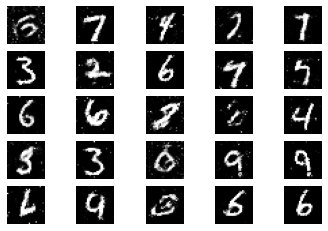

20201 [D loss: 0.686860, acc.: 57.03%] [G loss: 0.856234]
20202 [D loss: 0.618369, acc.: 60.16%] [G loss: 0.954667]
20203 [D loss: 0.679122, acc.: 56.25%] [G loss: 0.970791]
20204 [D loss: 0.652441, acc.: 58.59%] [G loss: 0.905859]
20205 [D loss: 0.673067, acc.: 53.12%] [G loss: 0.960744]
20206 [D loss: 0.654951, acc.: 59.38%] [G loss: 0.975481]
20207 [D loss: 0.683138, acc.: 55.47%] [G loss: 0.932016]
20208 [D loss: 0.618431, acc.: 63.28%] [G loss: 0.944922]
20209 [D loss: 0.688757, acc.: 54.69%] [G loss: 0.895120]
20210 [D loss: 0.635533, acc.: 62.50%] [G loss: 0.875321]
20211 [D loss: 0.631749, acc.: 61.72%] [G loss: 0.931706]
20212 [D loss: 0.659453, acc.: 64.06%] [G loss: 0.907207]
20213 [D loss: 0.679851, acc.: 58.59%] [G loss: 0.959044]
20214 [D loss: 0.630127, acc.: 67.19%] [G loss: 0.919210]
20215 [D loss: 0.649839, acc.: 55.47%] [G loss: 0.907498]
20216 [D loss: 0.637056, acc.: 62.50%] [G loss: 0.913366]
20217 [D loss: 0.650797, acc.: 57.03%] [G loss: 0.897389]
20218 [D loss:

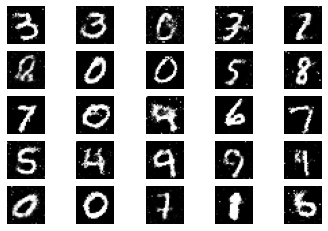

20301 [D loss: 0.636927, acc.: 64.84%] [G loss: 0.862463]
20302 [D loss: 0.657715, acc.: 60.94%] [G loss: 0.934864]
20303 [D loss: 0.615304, acc.: 65.62%] [G loss: 0.922474]
20304 [D loss: 0.647223, acc.: 64.06%] [G loss: 0.926275]
20305 [D loss: 0.617176, acc.: 66.41%] [G loss: 0.975857]
20306 [D loss: 0.678542, acc.: 57.81%] [G loss: 0.982898]
20307 [D loss: 0.665301, acc.: 60.16%] [G loss: 0.961814]
20308 [D loss: 0.643818, acc.: 58.59%] [G loss: 0.921163]
20309 [D loss: 0.640330, acc.: 64.84%] [G loss: 0.948554]
20310 [D loss: 0.642267, acc.: 66.41%] [G loss: 0.909687]
20311 [D loss: 0.665835, acc.: 57.81%] [G loss: 0.937088]
20312 [D loss: 0.654337, acc.: 62.50%] [G loss: 0.939102]
20313 [D loss: 0.673204, acc.: 58.59%] [G loss: 0.939422]
20314 [D loss: 0.654243, acc.: 62.50%] [G loss: 0.930722]
20315 [D loss: 0.680095, acc.: 50.78%] [G loss: 0.894313]
20316 [D loss: 0.637039, acc.: 67.19%] [G loss: 0.921048]
20317 [D loss: 0.653287, acc.: 62.50%] [G loss: 0.885074]
20318 [D loss:

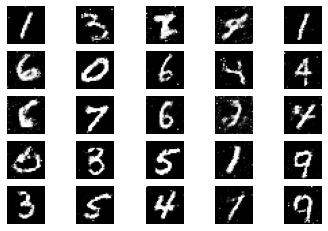

20401 [D loss: 0.636373, acc.: 66.41%] [G loss: 0.898403]
20402 [D loss: 0.666800, acc.: 59.38%] [G loss: 0.994203]
20403 [D loss: 0.629379, acc.: 60.94%] [G loss: 0.918780]
20404 [D loss: 0.677593, acc.: 59.38%] [G loss: 0.966247]
20405 [D loss: 0.653002, acc.: 62.50%] [G loss: 0.948121]
20406 [D loss: 0.636975, acc.: 67.97%] [G loss: 0.925134]
20407 [D loss: 0.636113, acc.: 62.50%] [G loss: 0.914288]
20408 [D loss: 0.694323, acc.: 57.81%] [G loss: 0.863507]
20409 [D loss: 0.661378, acc.: 58.59%] [G loss: 0.928134]
20410 [D loss: 0.638365, acc.: 63.28%] [G loss: 0.918638]
20411 [D loss: 0.682344, acc.: 58.59%] [G loss: 0.952984]
20412 [D loss: 0.682581, acc.: 55.47%] [G loss: 0.906307]
20413 [D loss: 0.699118, acc.: 53.91%] [G loss: 0.889675]
20414 [D loss: 0.665223, acc.: 62.50%] [G loss: 0.922873]
20415 [D loss: 0.643797, acc.: 60.94%] [G loss: 0.913585]
20416 [D loss: 0.665156, acc.: 57.03%] [G loss: 0.852853]
20417 [D loss: 0.710689, acc.: 50.78%] [G loss: 0.894703]
20418 [D loss:

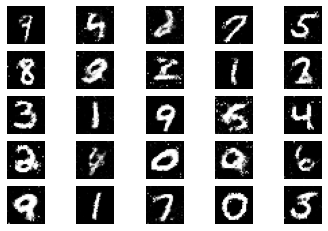

20501 [D loss: 0.658152, acc.: 59.38%] [G loss: 0.825917]
20502 [D loss: 0.652598, acc.: 61.72%] [G loss: 0.936693]
20503 [D loss: 0.688507, acc.: 58.59%] [G loss: 0.910815]
20504 [D loss: 0.652164, acc.: 61.72%] [G loss: 0.916536]
20505 [D loss: 0.644628, acc.: 63.28%] [G loss: 0.954930]
20506 [D loss: 0.671257, acc.: 54.69%] [G loss: 0.927394]
20507 [D loss: 0.678326, acc.: 59.38%] [G loss: 0.930399]
20508 [D loss: 0.652021, acc.: 60.94%] [G loss: 0.954208]
20509 [D loss: 0.695387, acc.: 61.72%] [G loss: 0.961090]
20510 [D loss: 0.627147, acc.: 65.62%] [G loss: 0.933450]
20511 [D loss: 0.658253, acc.: 64.84%] [G loss: 0.910933]
20512 [D loss: 0.670448, acc.: 58.59%] [G loss: 0.993098]
20513 [D loss: 0.660583, acc.: 62.50%] [G loss: 0.878269]
20514 [D loss: 0.633714, acc.: 58.59%] [G loss: 0.967071]
20515 [D loss: 0.725919, acc.: 53.91%] [G loss: 0.915595]
20516 [D loss: 0.652422, acc.: 57.81%] [G loss: 0.918988]
20517 [D loss: 0.610233, acc.: 64.06%] [G loss: 0.933223]
20518 [D loss:

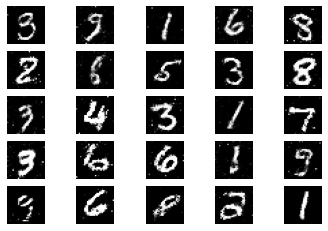

20601 [D loss: 0.649555, acc.: 60.94%] [G loss: 0.975937]
20602 [D loss: 0.613110, acc.: 71.09%] [G loss: 0.983639]
20603 [D loss: 0.666403, acc.: 55.47%] [G loss: 0.883490]
20604 [D loss: 0.672753, acc.: 56.25%] [G loss: 0.886195]
20605 [D loss: 0.600196, acc.: 68.75%] [G loss: 0.916486]
20606 [D loss: 0.682647, acc.: 57.81%] [G loss: 0.871882]
20607 [D loss: 0.678386, acc.: 58.59%] [G loss: 0.948047]
20608 [D loss: 0.592969, acc.: 67.97%] [G loss: 0.968483]
20609 [D loss: 0.662830, acc.: 56.25%] [G loss: 0.926357]
20610 [D loss: 0.660442, acc.: 57.03%] [G loss: 0.929445]
20611 [D loss: 0.624021, acc.: 63.28%] [G loss: 0.953211]
20612 [D loss: 0.636535, acc.: 59.38%] [G loss: 0.911297]
20613 [D loss: 0.673948, acc.: 52.34%] [G loss: 0.849985]
20614 [D loss: 0.651246, acc.: 61.72%] [G loss: 0.884917]
20615 [D loss: 0.625674, acc.: 65.62%] [G loss: 0.867832]
20616 [D loss: 0.636701, acc.: 62.50%] [G loss: 0.948515]
20617 [D loss: 0.666244, acc.: 58.59%] [G loss: 0.975058]
20618 [D loss:

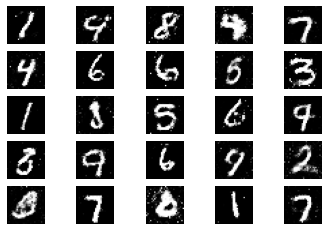

20701 [D loss: 0.642637, acc.: 61.72%] [G loss: 0.890916]
20702 [D loss: 0.694541, acc.: 57.03%] [G loss: 0.848984]
20703 [D loss: 0.635026, acc.: 67.97%] [G loss: 0.882425]
20704 [D loss: 0.642479, acc.: 60.16%] [G loss: 0.929971]
20705 [D loss: 0.646681, acc.: 64.84%] [G loss: 0.902624]
20706 [D loss: 0.618395, acc.: 65.62%] [G loss: 0.888518]
20707 [D loss: 0.663844, acc.: 60.94%] [G loss: 0.915971]
20708 [D loss: 0.634382, acc.: 64.84%] [G loss: 0.925672]
20709 [D loss: 0.614699, acc.: 71.09%] [G loss: 1.038059]
20710 [D loss: 0.662438, acc.: 60.94%] [G loss: 0.912839]
20711 [D loss: 0.669937, acc.: 59.38%] [G loss: 0.886109]
20712 [D loss: 0.648333, acc.: 56.25%] [G loss: 0.909787]
20713 [D loss: 0.687510, acc.: 57.03%] [G loss: 0.942437]
20714 [D loss: 0.688780, acc.: 57.03%] [G loss: 0.932579]
20715 [D loss: 0.663063, acc.: 56.25%] [G loss: 0.862843]
20716 [D loss: 0.614050, acc.: 67.97%] [G loss: 0.887161]
20717 [D loss: 0.645213, acc.: 59.38%] [G loss: 0.922920]
20718 [D loss:

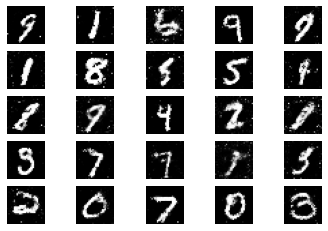

20801 [D loss: 0.672055, acc.: 55.47%] [G loss: 0.851334]
20802 [D loss: 0.649479, acc.: 55.47%] [G loss: 0.881806]
20803 [D loss: 0.643512, acc.: 61.72%] [G loss: 0.884888]
20804 [D loss: 0.673333, acc.: 55.47%] [G loss: 0.911690]
20805 [D loss: 0.692759, acc.: 57.03%] [G loss: 0.934358]
20806 [D loss: 0.699318, acc.: 60.94%] [G loss: 0.941579]
20807 [D loss: 0.651949, acc.: 64.06%] [G loss: 0.957194]
20808 [D loss: 0.700036, acc.: 51.56%] [G loss: 0.895774]
20809 [D loss: 0.653165, acc.: 60.94%] [G loss: 0.940268]
20810 [D loss: 0.633022, acc.: 62.50%] [G loss: 0.957372]
20811 [D loss: 0.663781, acc.: 60.16%] [G loss: 0.865002]
20812 [D loss: 0.665741, acc.: 61.72%] [G loss: 0.941029]
20813 [D loss: 0.683127, acc.: 61.72%] [G loss: 0.981044]
20814 [D loss: 0.629783, acc.: 60.94%] [G loss: 0.930128]
20815 [D loss: 0.666557, acc.: 64.06%] [G loss: 0.925086]
20816 [D loss: 0.696209, acc.: 50.00%] [G loss: 0.946055]
20817 [D loss: 0.648906, acc.: 59.38%] [G loss: 0.943524]
20818 [D loss:

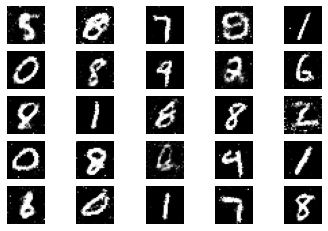

20901 [D loss: 0.673005, acc.: 60.94%] [G loss: 0.877109]
20902 [D loss: 0.671527, acc.: 62.50%] [G loss: 0.904117]
20903 [D loss: 0.645575, acc.: 62.50%] [G loss: 0.920752]
20904 [D loss: 0.664682, acc.: 57.03%] [G loss: 0.871877]
20905 [D loss: 0.641899, acc.: 62.50%] [G loss: 0.984440]
20906 [D loss: 0.627607, acc.: 63.28%] [G loss: 0.933178]
20907 [D loss: 0.689861, acc.: 59.38%] [G loss: 0.888019]
20908 [D loss: 0.634049, acc.: 62.50%] [G loss: 0.947190]
20909 [D loss: 0.682114, acc.: 58.59%] [G loss: 0.865880]
20910 [D loss: 0.649216, acc.: 60.16%] [G loss: 0.854091]
20911 [D loss: 0.715662, acc.: 51.56%] [G loss: 0.867969]
20912 [D loss: 0.607908, acc.: 65.62%] [G loss: 0.968066]
20913 [D loss: 0.608650, acc.: 66.41%] [G loss: 1.006377]
20914 [D loss: 0.675819, acc.: 55.47%] [G loss: 1.031567]
20915 [D loss: 0.650316, acc.: 62.50%] [G loss: 1.006256]
20916 [D loss: 0.651280, acc.: 61.72%] [G loss: 0.984582]
20917 [D loss: 0.647207, acc.: 58.59%] [G loss: 0.932429]
20918 [D loss:

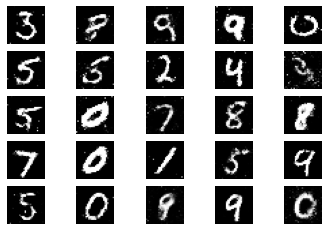

21001 [D loss: 0.682449, acc.: 58.59%] [G loss: 0.913608]
21002 [D loss: 0.655486, acc.: 60.16%] [G loss: 0.926513]
21003 [D loss: 0.637150, acc.: 61.72%] [G loss: 0.827885]
21004 [D loss: 0.651276, acc.: 62.50%] [G loss: 0.903277]
21005 [D loss: 0.680887, acc.: 54.69%] [G loss: 0.953966]
21006 [D loss: 0.650523, acc.: 60.16%] [G loss: 0.987363]
21007 [D loss: 0.687746, acc.: 57.03%] [G loss: 0.883776]
21008 [D loss: 0.619146, acc.: 70.31%] [G loss: 1.004658]
21009 [D loss: 0.631217, acc.: 67.97%] [G loss: 0.909704]
21010 [D loss: 0.657954, acc.: 64.06%] [G loss: 0.857529]
21011 [D loss: 0.645325, acc.: 62.50%] [G loss: 0.910450]
21012 [D loss: 0.683804, acc.: 57.03%] [G loss: 0.865970]
21013 [D loss: 0.681388, acc.: 57.03%] [G loss: 0.936133]
21014 [D loss: 0.628596, acc.: 61.72%] [G loss: 1.020552]
21015 [D loss: 0.691675, acc.: 57.81%] [G loss: 0.913226]
21016 [D loss: 0.628755, acc.: 64.06%] [G loss: 0.930682]
21017 [D loss: 0.646299, acc.: 57.81%] [G loss: 0.907649]
21018 [D loss:

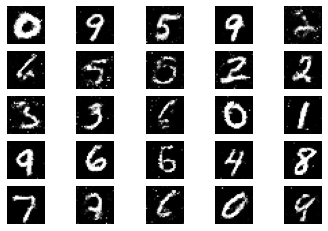

21101 [D loss: 0.709486, acc.: 47.66%] [G loss: 0.908465]
21102 [D loss: 0.635128, acc.: 64.06%] [G loss: 0.923596]
21103 [D loss: 0.666327, acc.: 59.38%] [G loss: 0.898232]
21104 [D loss: 0.676637, acc.: 60.94%] [G loss: 0.927366]
21105 [D loss: 0.673234, acc.: 57.81%] [G loss: 0.901568]
21106 [D loss: 0.662675, acc.: 57.03%] [G loss: 0.938751]
21107 [D loss: 0.648520, acc.: 62.50%] [G loss: 0.942725]
21108 [D loss: 0.661490, acc.: 60.16%] [G loss: 0.959107]
21109 [D loss: 0.650351, acc.: 61.72%] [G loss: 0.887769]
21110 [D loss: 0.631052, acc.: 67.97%] [G loss: 0.896195]
21111 [D loss: 0.658277, acc.: 60.94%] [G loss: 0.913442]
21112 [D loss: 0.606796, acc.: 67.19%] [G loss: 0.828874]
21113 [D loss: 0.690742, acc.: 55.47%] [G loss: 0.897486]
21114 [D loss: 0.676372, acc.: 58.59%] [G loss: 0.884631]
21115 [D loss: 0.705588, acc.: 59.38%] [G loss: 0.871639]
21116 [D loss: 0.637381, acc.: 60.16%] [G loss: 0.865616]
21117 [D loss: 0.662330, acc.: 59.38%] [G loss: 0.975094]
21118 [D loss:

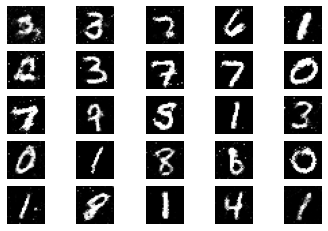

21201 [D loss: 0.638189, acc.: 60.94%] [G loss: 0.864362]
21202 [D loss: 0.656866, acc.: 58.59%] [G loss: 0.872374]
21203 [D loss: 0.682108, acc.: 57.81%] [G loss: 0.860700]
21204 [D loss: 0.665693, acc.: 61.72%] [G loss: 0.868901]
21205 [D loss: 0.622133, acc.: 68.75%] [G loss: 0.900079]
21206 [D loss: 0.671557, acc.: 64.06%] [G loss: 0.942532]
21207 [D loss: 0.650352, acc.: 62.50%] [G loss: 0.930893]
21208 [D loss: 0.660780, acc.: 59.38%] [G loss: 0.924116]
21209 [D loss: 0.660775, acc.: 63.28%] [G loss: 0.908030]
21210 [D loss: 0.651892, acc.: 61.72%] [G loss: 0.885369]
21211 [D loss: 0.671629, acc.: 58.59%] [G loss: 0.902910]
21212 [D loss: 0.659515, acc.: 64.06%] [G loss: 0.885233]
21213 [D loss: 0.706141, acc.: 54.69%] [G loss: 0.948233]
21214 [D loss: 0.706983, acc.: 51.56%] [G loss: 0.913308]
21215 [D loss: 0.646307, acc.: 57.81%] [G loss: 0.854079]
21216 [D loss: 0.625360, acc.: 68.75%] [G loss: 0.871158]
21217 [D loss: 0.646083, acc.: 59.38%] [G loss: 0.927273]
21218 [D loss:

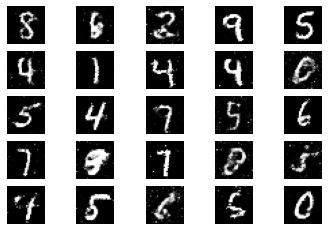

21301 [D loss: 0.665176, acc.: 54.69%] [G loss: 0.878340]
21302 [D loss: 0.659463, acc.: 63.28%] [G loss: 0.926141]
21303 [D loss: 0.659980, acc.: 57.03%] [G loss: 0.861003]
21304 [D loss: 0.633428, acc.: 61.72%] [G loss: 0.922673]
21305 [D loss: 0.634220, acc.: 60.94%] [G loss: 0.907259]
21306 [D loss: 0.596291, acc.: 73.44%] [G loss: 0.880974]
21307 [D loss: 0.672561, acc.: 61.72%] [G loss: 0.920494]
21308 [D loss: 0.668684, acc.: 60.94%] [G loss: 0.897948]
21309 [D loss: 0.654055, acc.: 60.94%] [G loss: 0.880354]
21310 [D loss: 0.652020, acc.: 58.59%] [G loss: 0.927518]
21311 [D loss: 0.596174, acc.: 68.75%] [G loss: 0.904970]
21312 [D loss: 0.662286, acc.: 64.06%] [G loss: 0.928831]
21313 [D loss: 0.673104, acc.: 55.47%] [G loss: 0.847888]
21314 [D loss: 0.617279, acc.: 64.06%] [G loss: 0.904064]
21315 [D loss: 0.665081, acc.: 62.50%] [G loss: 0.882494]
21316 [D loss: 0.612099, acc.: 64.06%] [G loss: 0.903066]
21317 [D loss: 0.657695, acc.: 59.38%] [G loss: 0.948669]
21318 [D loss:

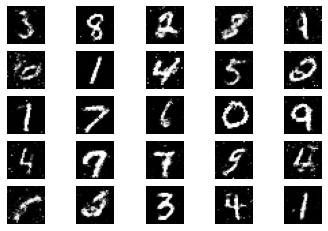

21401 [D loss: 0.642117, acc.: 60.94%] [G loss: 0.995822]
21402 [D loss: 0.637992, acc.: 63.28%] [G loss: 0.961233]
21403 [D loss: 0.669784, acc.: 61.72%] [G loss: 0.949021]
21404 [D loss: 0.608906, acc.: 64.84%] [G loss: 0.902585]
21405 [D loss: 0.647106, acc.: 60.16%] [G loss: 0.833437]
21406 [D loss: 0.629049, acc.: 60.16%] [G loss: 0.942540]
21407 [D loss: 0.644142, acc.: 57.81%] [G loss: 0.906130]
21408 [D loss: 0.664640, acc.: 57.81%] [G loss: 0.920853]
21409 [D loss: 0.612306, acc.: 60.94%] [G loss: 0.978206]
21410 [D loss: 0.668571, acc.: 61.72%] [G loss: 0.883950]
21411 [D loss: 0.621939, acc.: 64.84%] [G loss: 0.936425]
21412 [D loss: 0.634818, acc.: 60.16%] [G loss: 0.921553]
21413 [D loss: 0.616772, acc.: 65.62%] [G loss: 0.918092]
21414 [D loss: 0.662420, acc.: 60.94%] [G loss: 0.977856]
21415 [D loss: 0.642245, acc.: 59.38%] [G loss: 0.903132]
21416 [D loss: 0.625316, acc.: 69.53%] [G loss: 0.919494]
21417 [D loss: 0.625224, acc.: 69.53%] [G loss: 0.849753]
21418 [D loss:

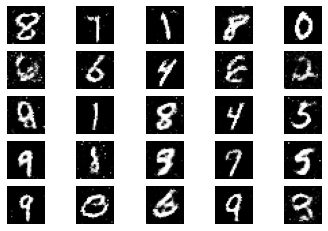

21501 [D loss: 0.672180, acc.: 53.12%] [G loss: 0.913977]
21502 [D loss: 0.671289, acc.: 53.91%] [G loss: 0.945205]
21503 [D loss: 0.620432, acc.: 69.53%] [G loss: 0.900381]
21504 [D loss: 0.663807, acc.: 57.81%] [G loss: 0.941453]
21505 [D loss: 0.606273, acc.: 66.41%] [G loss: 0.980956]
21506 [D loss: 0.628068, acc.: 64.84%] [G loss: 0.916473]
21507 [D loss: 0.642305, acc.: 60.94%] [G loss: 0.900360]
21508 [D loss: 0.625490, acc.: 65.62%] [G loss: 0.945472]
21509 [D loss: 0.667255, acc.: 59.38%] [G loss: 0.861056]
21510 [D loss: 0.660459, acc.: 61.72%] [G loss: 0.891510]
21511 [D loss: 0.700267, acc.: 49.22%] [G loss: 0.919306]
21512 [D loss: 0.612718, acc.: 67.19%] [G loss: 0.904758]
21513 [D loss: 0.605030, acc.: 72.66%] [G loss: 0.938958]
21514 [D loss: 0.676160, acc.: 57.03%] [G loss: 0.872486]
21515 [D loss: 0.657944, acc.: 63.28%] [G loss: 0.948694]
21516 [D loss: 0.673197, acc.: 61.72%] [G loss: 0.929433]
21517 [D loss: 0.677820, acc.: 60.16%] [G loss: 0.947471]
21518 [D loss:

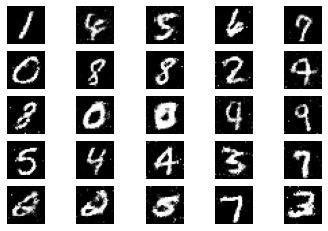

21601 [D loss: 0.650614, acc.: 62.50%] [G loss: 0.871958]
21602 [D loss: 0.661598, acc.: 60.16%] [G loss: 0.934137]
21603 [D loss: 0.627967, acc.: 64.84%] [G loss: 0.976934]
21604 [D loss: 0.687491, acc.: 57.81%] [G loss: 0.893901]
21605 [D loss: 0.686343, acc.: 53.91%] [G loss: 0.919169]
21606 [D loss: 0.653652, acc.: 60.94%] [G loss: 0.952991]
21607 [D loss: 0.653869, acc.: 58.59%] [G loss: 0.956152]
21608 [D loss: 0.646798, acc.: 64.84%] [G loss: 0.971462]
21609 [D loss: 0.623607, acc.: 60.94%] [G loss: 0.921868]
21610 [D loss: 0.666826, acc.: 52.34%] [G loss: 0.893455]
21611 [D loss: 0.651910, acc.: 58.59%] [G loss: 0.858915]
21612 [D loss: 0.647943, acc.: 63.28%] [G loss: 0.944335]
21613 [D loss: 0.639576, acc.: 62.50%] [G loss: 0.941509]
21614 [D loss: 0.660116, acc.: 59.38%] [G loss: 0.922994]
21615 [D loss: 0.691577, acc.: 54.69%] [G loss: 0.935068]
21616 [D loss: 0.679662, acc.: 55.47%] [G loss: 0.869960]
21617 [D loss: 0.695662, acc.: 58.59%] [G loss: 0.924982]
21618 [D loss:

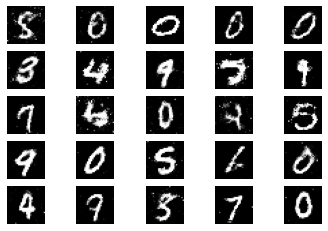

21701 [D loss: 0.655625, acc.: 57.81%] [G loss: 0.853875]
21702 [D loss: 0.709082, acc.: 51.56%] [G loss: 0.884587]
21703 [D loss: 0.667288, acc.: 60.94%] [G loss: 0.927130]
21704 [D loss: 0.661940, acc.: 56.25%] [G loss: 0.864634]
21705 [D loss: 0.686569, acc.: 57.03%] [G loss: 0.818383]
21706 [D loss: 0.649940, acc.: 66.41%] [G loss: 0.855480]
21707 [D loss: 0.697604, acc.: 57.03%] [G loss: 0.936305]
21708 [D loss: 0.688750, acc.: 53.91%] [G loss: 0.880977]
21709 [D loss: 0.695216, acc.: 53.91%] [G loss: 0.840699]
21710 [D loss: 0.631753, acc.: 60.16%] [G loss: 0.813803]
21711 [D loss: 0.653921, acc.: 62.50%] [G loss: 0.952678]
21712 [D loss: 0.649548, acc.: 59.38%] [G loss: 0.934409]
21713 [D loss: 0.659341, acc.: 57.03%] [G loss: 0.860919]
21714 [D loss: 0.653329, acc.: 63.28%] [G loss: 0.899788]
21715 [D loss: 0.611058, acc.: 65.62%] [G loss: 0.937706]
21716 [D loss: 0.636841, acc.: 64.84%] [G loss: 0.925971]
21717 [D loss: 0.641098, acc.: 67.97%] [G loss: 0.938444]
21718 [D loss:

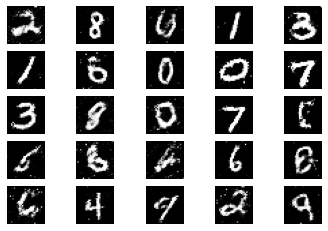

21801 [D loss: 0.707326, acc.: 55.47%] [G loss: 0.868876]
21802 [D loss: 0.690040, acc.: 49.22%] [G loss: 0.946370]
21803 [D loss: 0.634940, acc.: 60.94%] [G loss: 0.882552]
21804 [D loss: 0.682042, acc.: 57.03%] [G loss: 0.821207]
21805 [D loss: 0.680057, acc.: 56.25%] [G loss: 0.886633]
21806 [D loss: 0.683940, acc.: 60.16%] [G loss: 0.925827]
21807 [D loss: 0.642489, acc.: 63.28%] [G loss: 0.967155]
21808 [D loss: 0.682014, acc.: 57.03%] [G loss: 0.903431]
21809 [D loss: 0.650530, acc.: 60.16%] [G loss: 0.870954]
21810 [D loss: 0.688816, acc.: 57.81%] [G loss: 0.872466]
21811 [D loss: 0.619075, acc.: 66.41%] [G loss: 0.874813]
21812 [D loss: 0.647475, acc.: 62.50%] [G loss: 0.845112]
21813 [D loss: 0.655954, acc.: 60.16%] [G loss: 0.881018]
21814 [D loss: 0.601003, acc.: 68.75%] [G loss: 0.869087]
21815 [D loss: 0.645804, acc.: 65.62%] [G loss: 0.936516]
21816 [D loss: 0.657611, acc.: 61.72%] [G loss: 0.971011]
21817 [D loss: 0.667847, acc.: 54.69%] [G loss: 0.918189]
21818 [D loss:

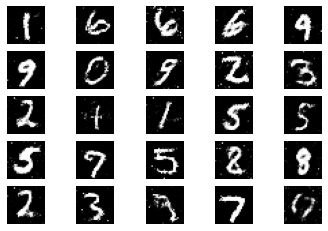

21901 [D loss: 0.690496, acc.: 53.91%] [G loss: 0.923641]
21902 [D loss: 0.647638, acc.: 66.41%] [G loss: 0.881725]
21903 [D loss: 0.660090, acc.: 56.25%] [G loss: 0.924379]
21904 [D loss: 0.650477, acc.: 61.72%] [G loss: 0.890565]
21905 [D loss: 0.660763, acc.: 59.38%] [G loss: 0.862334]
21906 [D loss: 0.669478, acc.: 56.25%] [G loss: 0.924133]
21907 [D loss: 0.656425, acc.: 57.03%] [G loss: 0.925362]
21908 [D loss: 0.635387, acc.: 65.62%] [G loss: 0.913845]
21909 [D loss: 0.682204, acc.: 56.25%] [G loss: 0.937631]
21910 [D loss: 0.647686, acc.: 64.84%] [G loss: 0.908821]
21911 [D loss: 0.686692, acc.: 58.59%] [G loss: 0.845083]
21912 [D loss: 0.678729, acc.: 51.56%] [G loss: 0.911498]
21913 [D loss: 0.633074, acc.: 59.38%] [G loss: 0.949541]
21914 [D loss: 0.646116, acc.: 60.94%] [G loss: 0.892519]
21915 [D loss: 0.656232, acc.: 60.94%] [G loss: 0.941639]
21916 [D loss: 0.648077, acc.: 60.16%] [G loss: 0.975809]
21917 [D loss: 0.667072, acc.: 63.28%] [G loss: 0.916748]
21918 [D loss:

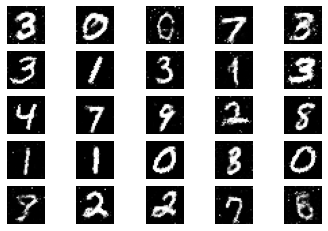

22001 [D loss: 0.704597, acc.: 55.47%] [G loss: 0.901201]
22002 [D loss: 0.657164, acc.: 58.59%] [G loss: 0.914345]
22003 [D loss: 0.651996, acc.: 62.50%] [G loss: 0.870808]
22004 [D loss: 0.659590, acc.: 56.25%] [G loss: 0.943682]
22005 [D loss: 0.684268, acc.: 57.81%] [G loss: 0.933718]
22006 [D loss: 0.618606, acc.: 65.62%] [G loss: 0.981627]
22007 [D loss: 0.695464, acc.: 58.59%] [G loss: 0.952218]
22008 [D loss: 0.685233, acc.: 53.91%] [G loss: 0.957396]
22009 [D loss: 0.655318, acc.: 64.06%] [G loss: 0.903467]
22010 [D loss: 0.695582, acc.: 51.56%] [G loss: 0.882445]
22011 [D loss: 0.669708, acc.: 59.38%] [G loss: 0.907661]
22012 [D loss: 0.637347, acc.: 68.75%] [G loss: 0.947487]
22013 [D loss: 0.620233, acc.: 66.41%] [G loss: 0.967361]
22014 [D loss: 0.639045, acc.: 64.06%] [G loss: 0.916353]
22015 [D loss: 0.650619, acc.: 58.59%] [G loss: 0.916495]
22016 [D loss: 0.612022, acc.: 66.41%] [G loss: 0.951892]
22017 [D loss: 0.650827, acc.: 58.59%] [G loss: 0.925562]
22018 [D loss:

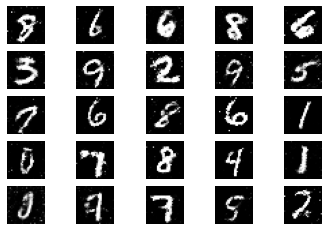

22101 [D loss: 0.618715, acc.: 68.75%] [G loss: 0.854828]
22102 [D loss: 0.621583, acc.: 64.84%] [G loss: 0.894403]
22103 [D loss: 0.662184, acc.: 55.47%] [G loss: 0.955438]
22104 [D loss: 0.664576, acc.: 60.94%] [G loss: 0.906712]
22105 [D loss: 0.641147, acc.: 64.06%] [G loss: 0.884855]
22106 [D loss: 0.716517, acc.: 47.66%] [G loss: 0.967619]
22107 [D loss: 0.659256, acc.: 59.38%] [G loss: 0.867572]
22108 [D loss: 0.624671, acc.: 63.28%] [G loss: 0.922717]
22109 [D loss: 0.678366, acc.: 61.72%] [G loss: 1.013825]
22110 [D loss: 0.670553, acc.: 60.94%] [G loss: 0.940429]
22111 [D loss: 0.655736, acc.: 60.16%] [G loss: 0.897148]
22112 [D loss: 0.654555, acc.: 57.81%] [G loss: 0.889583]
22113 [D loss: 0.714966, acc.: 52.34%] [G loss: 0.910151]
22114 [D loss: 0.616322, acc.: 71.09%] [G loss: 0.970112]
22115 [D loss: 0.657625, acc.: 59.38%] [G loss: 0.908300]
22116 [D loss: 0.674169, acc.: 58.59%] [G loss: 0.928229]
22117 [D loss: 0.701156, acc.: 54.69%] [G loss: 0.865831]
22118 [D loss:

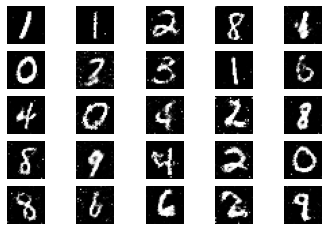

22201 [D loss: 0.649555, acc.: 60.16%] [G loss: 0.900344]
22202 [D loss: 0.624620, acc.: 64.06%] [G loss: 0.861117]
22203 [D loss: 0.636024, acc.: 64.84%] [G loss: 0.867271]
22204 [D loss: 0.663689, acc.: 59.38%] [G loss: 0.918293]
22205 [D loss: 0.660136, acc.: 65.62%] [G loss: 0.897666]
22206 [D loss: 0.637076, acc.: 62.50%] [G loss: 0.977486]
22207 [D loss: 0.673685, acc.: 61.72%] [G loss: 0.907885]
22208 [D loss: 0.665804, acc.: 57.03%] [G loss: 0.906133]
22209 [D loss: 0.662942, acc.: 55.47%] [G loss: 0.904651]
22210 [D loss: 0.622233, acc.: 62.50%] [G loss: 0.892799]
22211 [D loss: 0.658767, acc.: 60.16%] [G loss: 0.921654]
22212 [D loss: 0.658600, acc.: 57.81%] [G loss: 0.901702]
22213 [D loss: 0.650828, acc.: 58.59%] [G loss: 0.892777]
22214 [D loss: 0.650321, acc.: 63.28%] [G loss: 0.881270]
22215 [D loss: 0.676381, acc.: 57.03%] [G loss: 0.924777]
22216 [D loss: 0.598078, acc.: 71.09%] [G loss: 0.898129]
22217 [D loss: 0.656336, acc.: 58.59%] [G loss: 0.876124]
22218 [D loss:

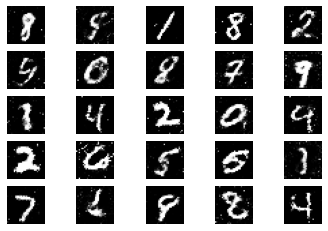

22301 [D loss: 0.618039, acc.: 68.75%] [G loss: 0.873851]
22302 [D loss: 0.625884, acc.: 68.75%] [G loss: 0.999637]
22303 [D loss: 0.660363, acc.: 60.16%] [G loss: 0.932551]
22304 [D loss: 0.692362, acc.: 56.25%] [G loss: 0.921162]
22305 [D loss: 0.648587, acc.: 63.28%] [G loss: 0.872150]
22306 [D loss: 0.636995, acc.: 67.19%] [G loss: 0.967565]
22307 [D loss: 0.688601, acc.: 57.81%] [G loss: 0.844918]
22308 [D loss: 0.678391, acc.: 55.47%] [G loss: 0.937063]
22309 [D loss: 0.660228, acc.: 57.03%] [G loss: 0.929442]
22310 [D loss: 0.630646, acc.: 64.84%] [G loss: 0.975935]
22311 [D loss: 0.677822, acc.: 58.59%] [G loss: 0.936670]
22312 [D loss: 0.662625, acc.: 55.47%] [G loss: 0.891552]
22313 [D loss: 0.673019, acc.: 54.69%] [G loss: 0.993595]
22314 [D loss: 0.640032, acc.: 64.06%] [G loss: 0.919455]
22315 [D loss: 0.667724, acc.: 60.94%] [G loss: 0.893256]
22316 [D loss: 0.623528, acc.: 64.06%] [G loss: 0.974005]
22317 [D loss: 0.670593, acc.: 57.03%] [G loss: 0.945075]
22318 [D loss:

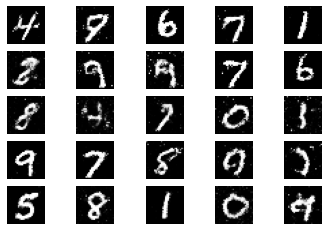

22401 [D loss: 0.672135, acc.: 60.16%] [G loss: 0.925773]
22402 [D loss: 0.654975, acc.: 58.59%] [G loss: 0.892016]
22403 [D loss: 0.661987, acc.: 53.91%] [G loss: 0.897711]
22404 [D loss: 0.661097, acc.: 58.59%] [G loss: 0.947024]
22405 [D loss: 0.662517, acc.: 62.50%] [G loss: 0.969979]
22406 [D loss: 0.708068, acc.: 57.81%] [G loss: 0.890805]
22407 [D loss: 0.623751, acc.: 66.41%] [G loss: 0.903711]
22408 [D loss: 0.680022, acc.: 58.59%] [G loss: 0.959829]
22409 [D loss: 0.689023, acc.: 57.03%] [G loss: 0.904283]
22410 [D loss: 0.634822, acc.: 64.84%] [G loss: 0.950115]
22411 [D loss: 0.729634, acc.: 51.56%] [G loss: 0.912204]
22412 [D loss: 0.675953, acc.: 57.81%] [G loss: 0.916656]
22413 [D loss: 0.591869, acc.: 71.88%] [G loss: 1.001290]
22414 [D loss: 0.644206, acc.: 63.28%] [G loss: 0.944375]
22415 [D loss: 0.669117, acc.: 61.72%] [G loss: 0.906745]
22416 [D loss: 0.642327, acc.: 55.47%] [G loss: 0.933589]
22417 [D loss: 0.679519, acc.: 59.38%] [G loss: 0.922344]
22418 [D loss:

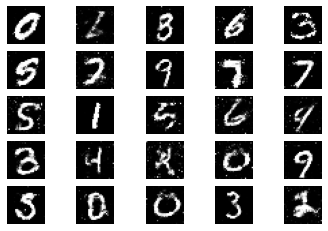

22501 [D loss: 0.644250, acc.: 63.28%] [G loss: 0.978253]
22502 [D loss: 0.638105, acc.: 64.84%] [G loss: 1.073628]
22503 [D loss: 0.720769, acc.: 58.59%] [G loss: 1.012666]
22504 [D loss: 0.701245, acc.: 55.47%] [G loss: 0.935764]
22505 [D loss: 0.657901, acc.: 58.59%] [G loss: 0.938260]
22506 [D loss: 0.653795, acc.: 59.38%] [G loss: 0.966670]
22507 [D loss: 0.608123, acc.: 66.41%] [G loss: 0.856414]
22508 [D loss: 0.671615, acc.: 62.50%] [G loss: 0.898463]
22509 [D loss: 0.644041, acc.: 60.94%] [G loss: 0.855449]
22510 [D loss: 0.598400, acc.: 69.53%] [G loss: 0.960726]
22511 [D loss: 0.706524, acc.: 49.22%] [G loss: 0.954175]
22512 [D loss: 0.642828, acc.: 63.28%] [G loss: 0.945865]
22513 [D loss: 0.611800, acc.: 72.66%] [G loss: 0.958734]
22514 [D loss: 0.679485, acc.: 60.16%] [G loss: 0.933603]
22515 [D loss: 0.636633, acc.: 63.28%] [G loss: 0.907107]
22516 [D loss: 0.626659, acc.: 67.19%] [G loss: 0.880231]
22517 [D loss: 0.586116, acc.: 71.88%] [G loss: 0.958832]
22518 [D loss:

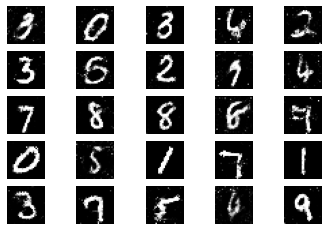

22601 [D loss: 0.622048, acc.: 60.16%] [G loss: 0.962753]
22602 [D loss: 0.661725, acc.: 57.81%] [G loss: 0.880985]
22603 [D loss: 0.640520, acc.: 58.59%] [G loss: 0.881304]
22604 [D loss: 0.688734, acc.: 49.22%] [G loss: 0.963312]
22605 [D loss: 0.647890, acc.: 60.94%] [G loss: 0.884577]
22606 [D loss: 0.637895, acc.: 59.38%] [G loss: 0.863012]
22607 [D loss: 0.703133, acc.: 52.34%] [G loss: 0.820582]
22608 [D loss: 0.693894, acc.: 55.47%] [G loss: 0.859591]
22609 [D loss: 0.664238, acc.: 58.59%] [G loss: 0.892352]
22610 [D loss: 0.642486, acc.: 64.06%] [G loss: 0.928362]
22611 [D loss: 0.681240, acc.: 58.59%] [G loss: 0.870936]
22612 [D loss: 0.658158, acc.: 57.81%] [G loss: 0.905637]
22613 [D loss: 0.655999, acc.: 61.72%] [G loss: 0.929514]
22614 [D loss: 0.681505, acc.: 54.69%] [G loss: 0.925605]
22615 [D loss: 0.660308, acc.: 55.47%] [G loss: 1.018955]
22616 [D loss: 0.634437, acc.: 64.84%] [G loss: 0.943481]
22617 [D loss: 0.693164, acc.: 55.47%] [G loss: 0.913291]
22618 [D loss:

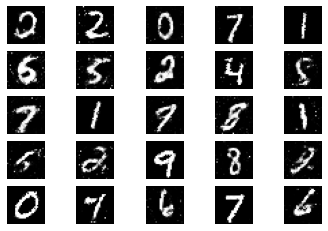

22701 [D loss: 0.662730, acc.: 59.38%] [G loss: 0.900041]
22702 [D loss: 0.704901, acc.: 55.47%] [G loss: 0.926917]
22703 [D loss: 0.633371, acc.: 61.72%] [G loss: 0.856945]
22704 [D loss: 0.647236, acc.: 63.28%] [G loss: 0.912446]
22705 [D loss: 0.663251, acc.: 60.94%] [G loss: 0.918393]
22706 [D loss: 0.692381, acc.: 54.69%] [G loss: 0.932877]
22707 [D loss: 0.649022, acc.: 64.06%] [G loss: 0.933854]
22708 [D loss: 0.666682, acc.: 61.72%] [G loss: 0.991490]
22709 [D loss: 0.659039, acc.: 61.72%] [G loss: 0.922459]
22710 [D loss: 0.648839, acc.: 60.16%] [G loss: 0.933327]
22711 [D loss: 0.729601, acc.: 51.56%] [G loss: 0.889498]
22712 [D loss: 0.665423, acc.: 64.06%] [G loss: 0.862136]
22713 [D loss: 0.636242, acc.: 60.94%] [G loss: 0.925956]
22714 [D loss: 0.684949, acc.: 54.69%] [G loss: 0.837394]
22715 [D loss: 0.635914, acc.: 63.28%] [G loss: 0.832535]
22716 [D loss: 0.634145, acc.: 60.16%] [G loss: 0.921138]
22717 [D loss: 0.666802, acc.: 56.25%] [G loss: 0.902799]
22718 [D loss:

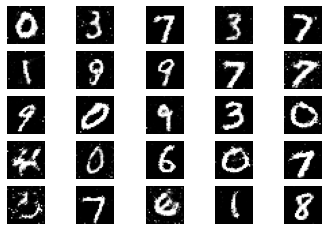

22801 [D loss: 0.607502, acc.: 66.41%] [G loss: 0.947688]
22802 [D loss: 0.657666, acc.: 53.12%] [G loss: 0.923540]
22803 [D loss: 0.669344, acc.: 56.25%] [G loss: 0.882771]
22804 [D loss: 0.641567, acc.: 66.41%] [G loss: 0.880007]
22805 [D loss: 0.656651, acc.: 57.81%] [G loss: 0.916647]
22806 [D loss: 0.654588, acc.: 58.59%] [G loss: 0.948008]
22807 [D loss: 0.635866, acc.: 60.16%] [G loss: 0.973245]
22808 [D loss: 0.694827, acc.: 52.34%] [G loss: 0.878805]
22809 [D loss: 0.645062, acc.: 63.28%] [G loss: 0.882119]
22810 [D loss: 0.684564, acc.: 51.56%] [G loss: 0.924690]
22811 [D loss: 0.632418, acc.: 63.28%] [G loss: 0.920486]
22812 [D loss: 0.681515, acc.: 60.16%] [G loss: 0.946594]
22813 [D loss: 0.629312, acc.: 65.62%] [G loss: 0.925194]
22814 [D loss: 0.645157, acc.: 58.59%] [G loss: 0.892891]
22815 [D loss: 0.661057, acc.: 60.16%] [G loss: 0.918630]
22816 [D loss: 0.651158, acc.: 58.59%] [G loss: 0.933110]
22817 [D loss: 0.643358, acc.: 62.50%] [G loss: 0.977134]
22818 [D loss:

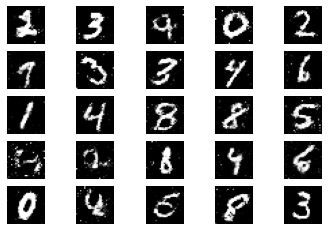

22901 [D loss: 0.638016, acc.: 65.62%] [G loss: 0.902900]
22902 [D loss: 0.659420, acc.: 60.16%] [G loss: 0.897387]
22903 [D loss: 0.647148, acc.: 65.62%] [G loss: 0.893907]
22904 [D loss: 0.671836, acc.: 57.81%] [G loss: 0.917201]
22905 [D loss: 0.669011, acc.: 59.38%] [G loss: 0.906038]
22906 [D loss: 0.642060, acc.: 64.06%] [G loss: 0.900260]
22907 [D loss: 0.604278, acc.: 69.53%] [G loss: 0.901179]
22908 [D loss: 0.617414, acc.: 66.41%] [G loss: 0.960387]
22909 [D loss: 0.709404, acc.: 48.44%] [G loss: 0.941469]
22910 [D loss: 0.671547, acc.: 58.59%] [G loss: 0.935515]
22911 [D loss: 0.649780, acc.: 62.50%] [G loss: 0.959726]
22912 [D loss: 0.633635, acc.: 66.41%] [G loss: 0.995159]
22913 [D loss: 0.656020, acc.: 56.25%] [G loss: 0.951303]
22914 [D loss: 0.680006, acc.: 59.38%] [G loss: 0.888213]
22915 [D loss: 0.678864, acc.: 57.81%] [G loss: 0.917809]
22916 [D loss: 0.667645, acc.: 52.34%] [G loss: 0.941563]
22917 [D loss: 0.656145, acc.: 55.47%] [G loss: 0.895816]
22918 [D loss:

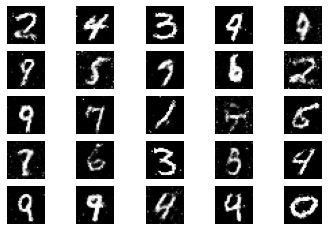

23001 [D loss: 0.605485, acc.: 68.75%] [G loss: 0.920132]
23002 [D loss: 0.651168, acc.: 57.81%] [G loss: 0.907849]
23003 [D loss: 0.652342, acc.: 58.59%] [G loss: 0.919503]
23004 [D loss: 0.650736, acc.: 63.28%] [G loss: 0.940273]
23005 [D loss: 0.640217, acc.: 63.28%] [G loss: 0.968850]
23006 [D loss: 0.635880, acc.: 57.03%] [G loss: 0.913467]
23007 [D loss: 0.649759, acc.: 61.72%] [G loss: 0.880142]
23008 [D loss: 0.660261, acc.: 58.59%] [G loss: 0.930769]
23009 [D loss: 0.640442, acc.: 65.62%] [G loss: 0.981397]
23010 [D loss: 0.680552, acc.: 55.47%] [G loss: 0.927668]
23011 [D loss: 0.694166, acc.: 56.25%] [G loss: 0.942594]
23012 [D loss: 0.647583, acc.: 59.38%] [G loss: 0.917421]
23013 [D loss: 0.679576, acc.: 59.38%] [G loss: 0.948455]
23014 [D loss: 0.594613, acc.: 73.44%] [G loss: 1.007923]
23015 [D loss: 0.662549, acc.: 61.72%] [G loss: 0.967861]
23016 [D loss: 0.682044, acc.: 60.94%] [G loss: 0.951478]
23017 [D loss: 0.702352, acc.: 56.25%] [G loss: 0.881302]
23018 [D loss:

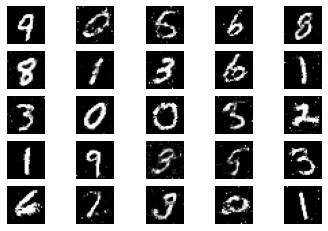

23101 [D loss: 0.610512, acc.: 67.97%] [G loss: 0.933257]
23102 [D loss: 0.653374, acc.: 64.84%] [G loss: 0.936383]
23103 [D loss: 0.606499, acc.: 65.62%] [G loss: 0.892313]
23104 [D loss: 0.629289, acc.: 69.53%] [G loss: 0.923034]
23105 [D loss: 0.621604, acc.: 66.41%] [G loss: 0.913938]
23106 [D loss: 0.643298, acc.: 65.62%] [G loss: 0.885731]
23107 [D loss: 0.698903, acc.: 50.78%] [G loss: 0.935566]
23108 [D loss: 0.647832, acc.: 64.06%] [G loss: 0.904933]
23109 [D loss: 0.640949, acc.: 67.19%] [G loss: 0.872971]
23110 [D loss: 0.638962, acc.: 67.19%] [G loss: 0.960748]
23111 [D loss: 0.652509, acc.: 60.94%] [G loss: 0.883026]
23112 [D loss: 0.693083, acc.: 51.56%] [G loss: 0.921515]
23113 [D loss: 0.669984, acc.: 57.81%] [G loss: 0.900093]
23114 [D loss: 0.691585, acc.: 57.81%] [G loss: 0.900153]
23115 [D loss: 0.593912, acc.: 71.09%] [G loss: 0.927089]
23116 [D loss: 0.657526, acc.: 60.16%] [G loss: 0.897142]
23117 [D loss: 0.636560, acc.: 66.41%] [G loss: 0.892283]
23118 [D loss:

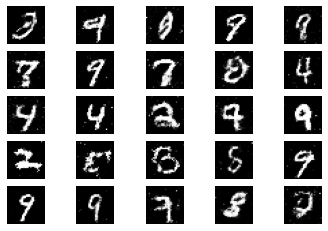

23201 [D loss: 0.666155, acc.: 60.16%] [G loss: 0.920861]
23202 [D loss: 0.641057, acc.: 66.41%] [G loss: 0.897720]
23203 [D loss: 0.657480, acc.: 55.47%] [G loss: 0.958190]
23204 [D loss: 0.633836, acc.: 65.62%] [G loss: 0.951731]
23205 [D loss: 0.624038, acc.: 64.84%] [G loss: 0.955062]
23206 [D loss: 0.643439, acc.: 57.03%] [G loss: 0.917519]
23207 [D loss: 0.670445, acc.: 59.38%] [G loss: 0.922586]
23208 [D loss: 0.658165, acc.: 60.94%] [G loss: 0.928755]
23209 [D loss: 0.678348, acc.: 60.94%] [G loss: 0.890109]
23210 [D loss: 0.656418, acc.: 58.59%] [G loss: 0.910546]
23211 [D loss: 0.579944, acc.: 71.88%] [G loss: 0.897243]
23212 [D loss: 0.676498, acc.: 62.50%] [G loss: 0.876552]
23213 [D loss: 0.653014, acc.: 61.72%] [G loss: 0.941037]
23214 [D loss: 0.633652, acc.: 62.50%] [G loss: 0.919688]
23215 [D loss: 0.658900, acc.: 60.16%] [G loss: 0.989978]
23216 [D loss: 0.651185, acc.: 57.81%] [G loss: 0.950168]
23217 [D loss: 0.639117, acc.: 60.94%] [G loss: 0.918477]
23218 [D loss:

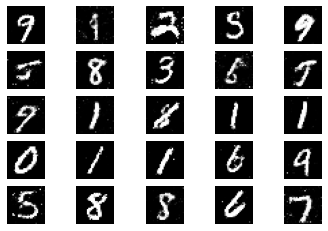

23301 [D loss: 0.641008, acc.: 66.41%] [G loss: 0.872393]
23302 [D loss: 0.635453, acc.: 59.38%] [G loss: 0.951121]
23303 [D loss: 0.690687, acc.: 53.91%] [G loss: 0.874144]
23304 [D loss: 0.665694, acc.: 57.81%] [G loss: 0.983872]
23305 [D loss: 0.634745, acc.: 65.62%] [G loss: 0.974198]
23306 [D loss: 0.673030, acc.: 57.03%] [G loss: 0.914530]
23307 [D loss: 0.603024, acc.: 73.44%] [G loss: 0.889156]
23308 [D loss: 0.659832, acc.: 57.03%] [G loss: 0.962618]
23309 [D loss: 0.636719, acc.: 64.06%] [G loss: 0.924561]
23310 [D loss: 0.671557, acc.: 56.25%] [G loss: 0.883646]
23311 [D loss: 0.645002, acc.: 60.94%] [G loss: 0.937591]
23312 [D loss: 0.615763, acc.: 64.06%] [G loss: 0.954962]
23313 [D loss: 0.646290, acc.: 60.94%] [G loss: 0.933642]
23314 [D loss: 0.669089, acc.: 58.59%] [G loss: 0.922239]
23315 [D loss: 0.672898, acc.: 56.25%] [G loss: 0.899512]
23316 [D loss: 0.627729, acc.: 64.84%] [G loss: 0.853380]
23317 [D loss: 0.673072, acc.: 56.25%] [G loss: 0.850464]
23318 [D loss:

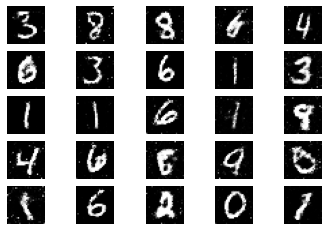

23401 [D loss: 0.594661, acc.: 67.97%] [G loss: 0.846590]
23402 [D loss: 0.653363, acc.: 60.94%] [G loss: 0.929043]
23403 [D loss: 0.647639, acc.: 62.50%] [G loss: 0.946853]
23404 [D loss: 0.615608, acc.: 66.41%] [G loss: 0.841267]
23405 [D loss: 0.664864, acc.: 61.72%] [G loss: 0.930010]
23406 [D loss: 0.691435, acc.: 55.47%] [G loss: 0.888624]
23407 [D loss: 0.660817, acc.: 57.81%] [G loss: 0.854851]
23408 [D loss: 0.644577, acc.: 58.59%] [G loss: 0.889334]
23409 [D loss: 0.628302, acc.: 66.41%] [G loss: 0.895356]
23410 [D loss: 0.641281, acc.: 61.72%] [G loss: 0.902038]
23411 [D loss: 0.655824, acc.: 64.84%] [G loss: 0.884672]
23412 [D loss: 0.635458, acc.: 60.16%] [G loss: 0.932748]
23413 [D loss: 0.661158, acc.: 59.38%] [G loss: 0.959828]
23414 [D loss: 0.628807, acc.: 64.06%] [G loss: 0.881153]
23415 [D loss: 0.625642, acc.: 61.72%] [G loss: 0.909060]
23416 [D loss: 0.655662, acc.: 64.84%] [G loss: 0.918457]
23417 [D loss: 0.669840, acc.: 59.38%] [G loss: 0.937159]
23418 [D loss:

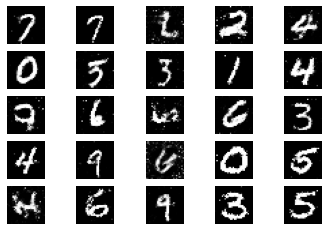

23501 [D loss: 0.651321, acc.: 57.81%] [G loss: 0.979728]
23502 [D loss: 0.661955, acc.: 60.16%] [G loss: 0.935931]
23503 [D loss: 0.695648, acc.: 57.81%] [G loss: 0.796905]
23504 [D loss: 0.646717, acc.: 60.94%] [G loss: 0.828677]
23505 [D loss: 0.643925, acc.: 64.06%] [G loss: 0.850635]
23506 [D loss: 0.669334, acc.: 61.72%] [G loss: 0.899470]
23507 [D loss: 0.632605, acc.: 65.62%] [G loss: 0.910528]
23508 [D loss: 0.655080, acc.: 60.94%] [G loss: 0.874587]
23509 [D loss: 0.660209, acc.: 60.94%] [G loss: 0.863745]
23510 [D loss: 0.651546, acc.: 57.81%] [G loss: 0.899510]
23511 [D loss: 0.656487, acc.: 64.06%] [G loss: 0.973338]
23512 [D loss: 0.638737, acc.: 62.50%] [G loss: 0.951449]
23513 [D loss: 0.688251, acc.: 52.34%] [G loss: 0.858790]
23514 [D loss: 0.671184, acc.: 57.03%] [G loss: 0.977577]
23515 [D loss: 0.663531, acc.: 54.69%] [G loss: 0.954820]
23516 [D loss: 0.612654, acc.: 66.41%] [G loss: 0.935446]
23517 [D loss: 0.654404, acc.: 60.16%] [G loss: 0.944219]
23518 [D loss:

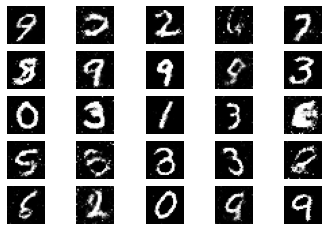

23601 [D loss: 0.632086, acc.: 65.62%] [G loss: 0.851815]
23602 [D loss: 0.705386, acc.: 52.34%] [G loss: 0.927910]
23603 [D loss: 0.635043, acc.: 64.06%] [G loss: 0.892617]
23604 [D loss: 0.687822, acc.: 54.69%] [G loss: 0.924208]
23605 [D loss: 0.639161, acc.: 61.72%] [G loss: 0.939262]
23606 [D loss: 0.662205, acc.: 54.69%] [G loss: 0.926440]
23607 [D loss: 0.640217, acc.: 65.62%] [G loss: 0.854665]
23608 [D loss: 0.646287, acc.: 60.16%] [G loss: 0.946740]
23609 [D loss: 0.614306, acc.: 65.62%] [G loss: 0.855157]
23610 [D loss: 0.604069, acc.: 66.41%] [G loss: 0.918093]
23611 [D loss: 0.608554, acc.: 67.97%] [G loss: 0.916387]
23612 [D loss: 0.643755, acc.: 64.06%] [G loss: 0.891620]
23613 [D loss: 0.650628, acc.: 61.72%] [G loss: 0.944504]
23614 [D loss: 0.619277, acc.: 65.62%] [G loss: 1.001388]
23615 [D loss: 0.636691, acc.: 60.16%] [G loss: 0.895629]
23616 [D loss: 0.591622, acc.: 69.53%] [G loss: 0.914908]
23617 [D loss: 0.674896, acc.: 53.12%] [G loss: 0.880053]
23618 [D loss:

KeyboardInterrupt: ignored

In [3]:
gan = GAN()
gan.train(epochs=30000, batch_size=64, sample_interval=100)

In [0]:
# GAN 模型的困難點是怎麼判斷哪一個參數是好的? 只能一個模型一個模型處理在儲存, 事後判斷最好的那一組參數的模型拿來用
# GAN 的發明人, Ian Goodfellow , 寫了一本 Deep learning 可參考 

In [0]:
plot_model(gan.discriminator)

In [0]:
plot_model(gan.combined)